# Expore data

## Import & definitions

In [1]:
import os
import sys
from pathlib import Path
import re
import random
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json
import joblib
# Third Party
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
# from helpers.ocean_helpers import save_list
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import L1L2
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

# definitions
PAST_HISTORY = int(60 / 5) * 6 #  6 hours in 5mins units : used to predict next values in future
FUTURE_TARGET = 12 + 3 # number of 5 min to predict  : 15
STEP = 1
BATCH_SIZE = 256 #128 #32
TRAIN_SPLIT_RATIO = 0.99 #0.8 #0.9891 # 1-(60/5*24)/50977

#LIST_SEEDS = [1,2,3,4,5]
LIST_SEEDS = [1]
MODE_TRAIN_AE = False #  True
MODE_AUTO_SELECT = 0 #1 #   #0 # 0: False, 1: True, 2: from disk
MODE_TRAIN_PREDICTOR = False # False

MODE_TRAIN_LSTM = False

# paths
path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_features_05m.csv")

path_save_pred_vals = "data/pred_vals.csv"
path_save_auto_select = "data/list_auto_select.csv"

path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")

path_scaler = os.path.join(path_data, "scaler.bin")
path_scaler_y = os.path.join(path_data, "scaler_y.bin")
path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")

In [2]:
PAST_HISTORY

72

In [3]:
print(60/5*24*2)
1-(60/5*24*2)/52981

576.0


0.9891281780260848

In [4]:
# helpers: save/load list
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))
    
def load_list(file_name: str) -> list:
    """Load from a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    s = p.read_text()
    list_ = eval(s)
    return list_

In [5]:
def plot_train_history(history, title, saveFolder=None):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    fig = plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    ax = fig.gca()
    ax.set_xlabel("epoch[-]")
    if saveFolder is not None:
        title_clean = re.sub('[^-a-zA-Z0-9 \.]', ' ', title)
        plt.savefig(os.path.join(saveFolder, f"output_{title_clean}.jpg")) 
    plt.show()


def naming_plot(n_unit_enc, encoding_dim, dropout_autoenc):
    return f"TS {TRAIN_SPLIT_RATIO} - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}"

## Load raw features

In [6]:
# load
df_feat_raw = pd.read_csv(path_save_df_feat)
df_feat_raw

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_61080/3998402900.py:2: DtypeWarning: Columns (118,119,120,121,122,123,124,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df_feat_raw = pd.read_csv(path_save_df_feat)


Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
85817  1698276300000   1786.43   1787.61  1785.59    1785.92    412.2097   
85818  1698276600000   1785.93   1787.83  1785.92    1786.76    806.0853   
85819  1698276900000   1786.76   1787.02  1781.50    1782.37    522.3319   
85820  1698277200000   1782.38   1787.38  1782.37    1787.15    530.5340   
85821  1698277500000   1787.16   1787.30  1784.94    1784.95    392.4814   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1725.587791       1725.167882   
1      2023-01-01 00:05:00       1725.587791       1725.167882   
2      2023-01-01 00:10:00       1725.587791       1725.167882   
3      2023-01-01 00:15:00       1725.587791       1725.167882   
4      2023-01-01 00:20:00       1725.587791       1725.167882   
...                    ...               ...               ...   
85817  2023-10-25 23:25:00       1789.052500       1786.520000   
85818  2023-10-25 23:30:00       1789.052500       1788.065000   
85819  2023-10-25 23:35:00       1789.052500       1788.065000   
85820  2023-10-25 23:40:00       1789.000000       1788.065000   
85821  2023-10-25 23:45:00       1787.527500       1787.875000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0                 NaN  ...   NaN         NaN            NaN           NaN   
1                 NaN  ...   NaN         NaN            NaN           NaN   
2                 NaN  ...   NaN         NaN            NaN           NaN   
3                 NaN  ...   NaN         NaN            NaN           NaN   
4                 NaN  ...   NaN         NaN            NaN           NaN   
...               ...  ...   ...         ...            ...           ...   
85817         1786.23  ...   NaN         NaN            NaN           NaN   
85818         1786.23  ...   NaN         NaN            NaN           NaN   
85819         1786.23  ...   NaN         NaN            NaN           NaN   
85820         1786.23  ...   NaN         NaN            NaN           NaN   
85821         1786.23  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   NaN         0.0               NaN         0.0      0.0   
1                   NaN         0.0               NaN         0.0      0.0   
2                   NaN         0.0               NaN         0.0      0.0   
3                   NaN         0.0               NaN         0.0      0.0   
4                   NaN         0.0               NaN         0.0      0.0   
...                 ...         ...               ...         ...      ...   
85817               NaN         0.0               NaN         0.0      0.0   
85818               NaN         0.0               NaN         0.0      0.0   
85819               NaN         0.0               NaN         0.0      0.0   
85820               NaN         0.0               NaN         0.0      0.0   
85821               NaN         0.0               NaN         0.0      0.0   

       date  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
...     ...  
85817   NaN  
85818   NaN  
85819   NaN  
85820   NaN  
85821   NaN  

[85822 rows x 135 columns]

### drop nan

In [7]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

nb_missing = get_missing(df_feat_raw)

missing data : 
vwap_z_score_ETH        1
vwap_z_score_BTC        1
ichi_tenkan_ETH         8
ichi_tenkan_BTC         8
rsi_h_ETH              13
                    ...  
Actual              85786
Event               85786
Country             85786
keep                85786
date                85786
Length: 65, dtype: int64

on 85822 samples


#### Cheat Backward Filling

In [8]:
df_feat = df_feat_raw.copy()

In [9]:
df_feat = df_feat.bfill(axis ='rows')

In [10]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
85817  1698276300000   1786.43   1787.61  1785.59    1785.92    412.2097   
85818  1698276600000   1785.93   1787.83  1785.92    1786.76    806.0853   
85819  1698276900000   1786.76   1787.02  1781.50    1782.37    522.3319   
85820  1698277200000   1782.38   1787.38  1782.37    1787.15    530.5340   
85821  1698277500000   1787.16   1787.30  1784.94    1784.95    392.4814   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1725.587791       1725.167882   
1      2023-01-01 00:05:00       1725.587791       1725.167882   
2      2023-01-01 00:10:00       1725.587791       1725.167882   
3      2023-01-01 00:15:00       1725.587791       1725.167882   
4      2023-01-01 00:20:00       1725.587791       1725.167882   
...                    ...               ...               ...   
85817  2023-10-25 23:25:00       1789.052500       1786.520000   
85818  2023-10-25 23:30:00       1789.052500       1788.065000   
85819  2023-10-25 23:35:00       1789.052500       1788.065000   
85820  2023-10-25 23:40:00       1789.000000       1788.065000   
85821  2023-10-25 23:45:00       1787.527500       1787.875000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0             1194.71  ...   1.0         0.0            0.0           0.0   
1             1194.71  ...   1.0         0.0            0.0           0.0   
2             1194.71  ...   1.0         0.0            0.0           0.0   
3             1194.71  ...   1.0         0.0            0.0           0.0   
4             1194.71  ...   1.0         0.0            0.0           0.0   
...               ...  ...   ...         ...            ...           ...   
85817         1786.23  ...   NaN         NaN            NaN           NaN   
85818         1786.23  ...   NaN         NaN            NaN           NaN   
85819         1786.23  ...   NaN         NaN            NaN           NaN   
85820         1786.23  ...   NaN         NaN            NaN           NaN   
85821         1786.23  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
85817               NaN         0.0               NaN         0.0      0.0   
85818               NaN         0.0               NaN         0.0      0.0   
85819               NaN         0.0               NaN         0.0      0.0   
85820               NaN         0.0               NaN         0.0      0.0   
85821               NaN         0.0               NaN         0.0      0.0   

                      date  
0      2023-01-02 05:00:00  
1      2023-01-02 05:00:00  
2      2023-01-02 05:00:00  
3      2023-01-02 05:00:00  
4      2023-01-02 05:00:00  
...                    ...  
85817                  NaN  
85818                  NaN  
85819                  NaN  
85820                  NaN  
85821                  NaN  

[85822 rows x 135 columns]

In [11]:
nb_missing = get_missing(df_feat)

missing data : 
Consensus_num       3873
delta_event_real    3873
delta_event_pred    3873
Previous_num        3873
Actual_num          3873
Event               3873
Date                3873
Previous            3873
Consensus           3873
Actual              3873
Country             3873
Time (ET)           3873
keep                3873
date                3873
dtype: int64

on 85822 samples


In [12]:
#print(df_feat.shape)
#df_feat = df_feat.dropna(subset=["Consensus_num"]).copy()
#df_feat.reset_index(inplace=True)
#df_feat.shape

## Features Selection

### Proportional to the Price

In [13]:
list_col = df_feat.columns.to_list()
list_col

['Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_month',
 'day_ratio',
 'da

In [14]:
list_col_ETH = [col for col in list_col if re.search("_ETH", col) is not None]
list_col_ETH

['Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH']

In [15]:
df_feat[list_col_ETH]

Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1196.13   1196.32  1195.65    1196.32    334.5592   
1       1196.31   1196.69  1194.90    1195.38    682.3876   
2       1195.38   1195.81  1194.55    1194.55    228.9387   
3       1194.55   1195.98  1194.31    1195.98    601.8903   
4       1195.98   1196.37  1195.97    1196.06    144.8048   
...         ...       ...      ...        ...         ...   
85817   1786.43   1787.61  1785.59    1785.92    412.2097   
85818   1785.93   1787.83  1785.92    1786.76    806.0853   
85819   1786.76   1787.02  1781.50    1782.37    522.3319   
85820   1782.38   1787.38  1782.37    1787.15    530.5340   
85821   1787.16   1787.30  1784.94    1784.95    392.4814   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1725.587791       1725.167882   
1      2023-01-01 00:05:00       1725.587791       1725.167882   
2      2023-01-01 00:10:00       1725.587791       1725.167882   
3      2023-01-01 00:15:00       1725.587791       1725.167882   
4      2023-01-01 00:20:00       1725.587791       1725.167882   
...                    ...               ...               ...   
85817  2023-10-25 23:25:00       1789.052500       1786.520000   
85818  2023-10-25 23:30:00       1789.052500       1788.065000   
85819  2023-10-25 23:35:00       1789.052500       1788.065000   
85820  2023-10-25 23:40:00       1789.000000       1788.065000   
85821  2023-10-25 23:45:00       1787.527500       1787.875000   

       ichi_kijun_ETH  ichi_tenkan_ETH  ...   vwap_m_ETH  vwap_3m_ETH  \
0             1194.71         1194.710  ...  1196.096667  1196.096667   
1             1194.71         1194.710  ...  1195.801420  1195.801420   
2             1194.71         1194.710  ...  1195.648641  1195.648641   
3             1194.71         1194.710  ...  1195.575250  1195.575250   
4             1194.71         1194.710  ...  1195.615807  1195.615807   
...               ...              ...  ...          ...          ...   
85817         1786.23         1785.630  ...  1642.295197  1634.628547   
85818         1786.23         1785.630  ...  1642.321012  1634.638590   
85819         1786.23         1785.630  ...  1642.337313  1634.644959   
85820         1786.23         1784.570  ...  1642.355898  1634.651517   
85821         1786.23         1784.145  ...  1642.368968  1634.656367   

       vwap_6m_ETH   vwap_y_ETH  vwap_all_ETH  vwap_z_score_ETH  nupl_ETH  \
0      1196.096667  1196.096667   1196.096667         -0.634018  0.000187   
1      1195.801420  1195.801420   1195.801420         -0.634018 -0.000353   
2      1195.648641  1195.648641   1195.648641         -1.240604 -0.000920   
3      1195.575250  1195.575250   1195.575250          0.521593  0.000338   
4      1195.615807  1195.615807   1195.615807          0.626856  0.000371   
...            ...          ...           ...               ...       ...   
85817  1712.635377  1644.921423   1720.104649          0.400151  0.036852   
85818  1712.635857  1644.943761   1720.105133          0.405258  0.037305   
85819  1712.633782  1644.956831   1720.105431          0.378567  0.034934   
85820  1712.633246  1644.970647   1720.105744          0.407629  0.037515   
85821  1712.629889  1644.985580   1720.105975          0.394254  0.036328   

         supply_ETH  act_addr_ETH  market_dom_ETH  
0      1.205043e+08      492363.0       17.338384  
1      1.205043e+08      492363.0       17.338384  
2      1.205043e+08      492363.0       17.338384  
3      1.205043e+08      492363.0       17.338384  
4      1.205043e+08      492363.0       17.338384  
...             ...           ...             ...  
85817  1.202655e+08      462902.0       16.614757  
85818  1.202655e+08      462902.0       16.614757  
85819  1.202655e+08      462902.0       16.614757  
85820  1.202655e+08      462902.0       16.614757  
85821  1.202655e+08      462902.0       16.614757  

[85822 rows x 46 columns]

In [16]:
list_price_dep_ETH = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
    'ichi_cloud_a_ETH',
    'ichi_cloud_b_ETH',
    'ichi_kijun_ETH',
    'ichi_tenkan_ETH',
    'ichi_cloud_a_day_ETH',
    'ichi_cloud_b_day_ETH',
    'ichi_kijun_day_ETH',
    'ichi_tenkan_day_ETH',
    'ichi_cloud_a_week_ETH',
    'ichi_cloud_b_week_ETH',
    'ichi_kijun_week_ETH',
    'ichi_tenkan_week_ETH',
    'max_high_h_ETH',
    'min_low_h_ETH',
    'max_high_d_ETH',
    'min_low_d_ETH',
    'max_high_w_ETH',
    'min_low_w_ETH',
    'vwap_h_ETH',
    'vwap_d_ETH',
    'vwap_w_ETH',
    'vwap_m_ETH',
    'vwap_3m_ETH',
    'vwap_6m_ETH',
    'vwap_y_ETH',
    'vwap_all_ETH',
]


#    'max_high_h_ETH',
#    'ichi_tenkan_week_ETH',

In [17]:
list_col_BTC = [col for col in list_col if re.search("_BTC", col) is not None]
list_col_BTC

['Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'Volume_BTC',
 'date_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'rsi_h_BTC',
 'rsi_d_BTC',
 'rsi_w_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'atr_h_BTC',
 'chop_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'atr_d_BTC',
 'chop_d_BTC',
 'max_high_w_BTC',
 'min_low_w_BTC',
 'atr_w_BTC',
 'chop_w_BTC',
 'vwap_h_BTC',
 'vwap_d_BTC',
 'vwap_w_BTC',
 'vwap_m_BTC',
 'vwap_3m_BTC',
 'vwap_6m_BTC',
 'vwap_y_BTC',
 'vwap_all_BTC',
 'vwap_z_score_BTC',
 'nupl_BTC',
 'supply_BTC',
 'act_addr_BTC',
 'market_dom_BTC']

In [18]:
list_price_dep_BTC = [
    'Open_BTC',
    'High_BTC',
    'Low_BTC',
    'Close_BTC',
    'ichi_cloud_a_BTC',
    'ichi_cloud_b_BTC',
    'ichi_kijun_BTC',
    'ichi_tenkan_BTC',
    'ichi_cloud_a_day_BTC',
    'ichi_cloud_b_day_BTC',
    'ichi_kijun_day_BTC',
    'ichi_tenkan_day_BTC',
    'ichi_cloud_a_week_BTC',
    'ichi_cloud_b_week_BTC',
    'ichi_kijun_week_BTC',
    'ichi_tenkan_week_BTC',
    'max_high_h_BTC',
    'min_low_h_BTC',
    'max_high_d_BTC',
    'min_low_d_BTC',
    'max_high_w_BTC',
    'min_low_w_BTC',
    'vwap_h_BTC',
    'vwap_d_BTC',
    'vwap_w_BTC',
    'vwap_m_BTC',
    'vwap_3m_BTC',
    'vwap_6m_BTC',
    'vwap_y_BTC',
    'vwap_all_BTC',
    'vwap_z_score_BTC',
]

In [19]:
list_col_BNB = [col for col in list_col if re.search("_BNB", col) is not None]
list_col_BNB

['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB', 'Volume_BNB', 'date_BNB']

In [20]:
list_price_dep_BNB = ['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB']

#### add special indices

In [21]:
df_feat[["fvx", "spx", "dxy"]]

fvx          spx         dxy
0      3.910  3823.179932  103.494003
1      3.910  3823.179932  103.494003
2      3.910  3823.179932  103.494003
3      3.910  3823.179932  103.494003
4      3.910  3823.179932  103.494003
...      ...          ...         ...
85817  4.918  4186.770020  106.568001
85818  4.918  4186.770020  106.568001
85819  4.918  4186.770020  106.568001
85820  4.918  4186.770020  106.568001
85821  4.918  4186.770020  106.568001

[85822 rows x 3 columns]

In [22]:
list_price_dep_special = ["fvx", "spx", "dxy"]

### Not proportional to the Price 

In [23]:
set(list_col) - set(list_price_dep_ETH) - set(list_price_dep_BTC) - set(list_price_dep_BNB) - set(list_price_dep_special)

{'Actual',
 'Actual_num',
 'Consensus',
 'Consensus_num',
 'Country',
 'Date',
 'Event',
 'Previous',
 'Previous_num',
 'Time',
 'Time (ET)',
 'Volume_BNB',
 'Volume_BTC',
 'Volume_ETH',
 'act_addr_BTC',
 'act_addr_ETH',
 'atr_d_BTC',
 'atr_d_ETH',
 'atr_h_BTC',
 'atr_h_ETH',
 'atr_w_BTC',
 'atr_w_ETH',
 'chop_d_BTC',
 'chop_d_ETH',
 'chop_h_BTC',
 'chop_h_ETH',
 'chop_w_BTC',
 'chop_w_ETH',
 'date',
 'date_BNB',
 'date_BTC',
 'date_ETH',
 'day',
 'day_in_month_cos',
 'day_in_month_sin',
 'day_off',
 'day_ratio',
 'days_in_month',
 'delta_event_pred',
 'delta_event_real',
 'event_pred',
 'event_real',
 'fear_greed',
 'fear_greed_class',
 'hour',
 'hour_cos',
 'hour_sin',
 'keep',
 'market_dom_BTC',
 'market_dom_ETH',
 'month',
 'month_cos',
 'month_sin',
 'nupl_BTC',
 'nupl_ETH',
 'rsi_d_BTC',
 'rsi_d_ETH',
 'rsi_h_BTC',
 'rsi_h_ETH',
 'rsi_w_BTC',
 'rsi_w_ETH',
 'supply_BTC',
 'supply_ETH',
 'vwap_z_score_ETH',
 'weekday',
 'weekday_cos',
 'weekday_sin'}

In [24]:
list_col_other = [
    'Volume_BNB',
    'Volume_BTC',
    'Volume_ETH',
    'chop_d_BTC',
    'chop_d_ETH',
    'chop_h_BTC',
    'chop_h_ETH',
    'chop_w_BTC',
    'chop_w_ETH',
    'rsi_d_BTC',
    'rsi_d_ETH',
    'rsi_h_BTC',
    'rsi_h_ETH',
    'rsi_w_BTC',
    'rsi_w_ETH',
    'vwap_z_score_ETH',
    #'dxy',
    #'spx',
    #'fvx',
    'act_addr_BTC',
    'act_addr_ETH',
    'market_dom_BTC',
    'market_dom_ETH',
    'nupl_BTC',
    'nupl_ETH',
    'fear_greed',
    'supply_BTC',
    'supply_ETH',
    'hour_cos',
    'hour_sin',
    'weekday_cos',
    'weekday_sin',
    'day_in_month_cos',
    'day_in_month_sin',
    #'month_cos',
    #'month_sin',
    'day_off',
    'event_pred',
    'event_real',
]

### Final selection

In [25]:
list_col_select_simple = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
]

list_col_select_global = (
    list_price_dep_ETH +
    list_price_dep_BTC +
    list_price_dep_BNB +  
    list_price_dep_special +  
    list_col_other
)


# selection
list_col_select = list_col_select_global

# only col in df_feat
list_col_select = [feat for feat in list_col_select if feat in df_feat.columns]
print("num features : ", len(list_col_select))

num features :  102


In [26]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

## Features preparation

df_feat [selected features]   
--> X_train_raw, X_test_raw, y_train_raw, y_test_raw  
--> X_train (with prices ratio of ETH Close price at last lag) <-- used by autoencoder 


X [nb samples, nb lags, nb features]


In [27]:
df_feat.shape[0]

85822

In [28]:
TRAIN_SPLIT = round(TRAIN_SPLIT_RATIO * df_feat.shape[0])
TRAIN_SPLIT

84964

In [29]:
bol_train = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat.shape[0])]
df_feat["train"] = bol_train
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
85817  1698276300000   1786.43   1787.61  1785.59    1785.92    412.2097   
85818  1698276600000   1785.93   1787.83  1785.92    1786.76    806.0853   
85819  1698276900000   1786.76   1787.02  1781.50    1782.37    522.3319   
85820  1698277200000   1782.38   1787.38  1782.37    1787.15    530.5340   
85821  1698277500000   1787.16   1787.30  1784.94    1784.95    392.4814   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1725.587791       1725.167882   
1      2023-01-01 00:05:00       1725.587791       1725.167882   
2      2023-01-01 00:10:00       1725.587791       1725.167882   
3      2023-01-01 00:15:00       1725.587791       1725.167882   
4      2023-01-01 00:20:00       1725.587791       1725.167882   
...                    ...               ...               ...   
85817  2023-10-25 23:25:00       1789.052500       1786.520000   
85818  2023-10-25 23:30:00       1789.052500       1788.065000   
85819  2023-10-25 23:35:00       1789.052500       1788.065000   
85820  2023-10-25 23:40:00       1789.000000       1788.065000   
85821  2023-10-25 23:45:00       1787.527500       1787.875000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0             1194.71  ...         0.0            0.0           0.0   
1             1194.71  ...         0.0            0.0           0.0   
2             1194.71  ...         0.0            0.0           0.0   
3             1194.71  ...         0.0            0.0           0.0   
4             1194.71  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
85817         1786.23  ...         NaN            NaN           NaN   
85818         1786.23  ...         NaN            NaN           NaN   
85819         1786.23  ...         NaN            NaN           NaN   
85820         1786.23  ...         NaN            NaN           NaN   
85821         1786.23  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
85817               NaN         0.0               NaN         0.0      0.0   
85818               NaN         0.0               NaN         0.0      0.0   
85819               NaN         0.0               NaN         0.0      0.0   
85820               NaN         0.0               NaN         0.0      0.0   
85821               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
85817                  NaN  False  
85818                  NaN  False  
85819                  NaN  False  
85820                  NaN  False  
85821                  NaN  False  

[85822 rows x 136 columns]

In [30]:
df_feat[df_feat["train"] == True]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
84960  1698019200000   1663.69   1665.74  1662.72    1665.32   2331.1488   
84961  1698019500000   1665.32   1667.32  1662.46    1664.90   1868.2738   
84962  1698019800000   1664.89   1669.31  1664.80    1666.47   1997.7261   
84963  1698020100000   1666.48   1666.58  1662.74    1664.73   1261.7224   
84964  1698020400000   1664.73   1665.39  1657.80    1658.70   1541.6549   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1725.587791       1725.167882   
1      2023-01-01 00:05:00       1725.587791       1725.167882   
2      2023-01-01 00:10:00       1725.587791       1725.167882   
3      2023-01-01 00:15:00       1725.587791       1725.167882   
4      2023-01-01 00:20:00       1725.587791       1725.167882   
...                    ...               ...               ...   
84960  2023-10-23 00:00:00       1637.865000       1637.505000   
84961  2023-10-23 00:05:00       1637.480000       1637.505000   
84962  2023-10-23 00:10:00       1637.372500       1637.505000   
84963  2023-10-23 00:15:00       1637.557500       1637.505000   
84964  2023-10-23 00:20:00       1637.557500       1637.505000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
84960        1651.005  ...         NaN            NaN           NaN   
84961        1651.005  ...         NaN            NaN           NaN   
84962        1652.195  ...         NaN            NaN           NaN   
84963        1653.265  ...         NaN            NaN           NaN   
84964        1653.590  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
84960               NaN         0.0               NaN         0.0      0.0   
84961               NaN         0.0               NaN         0.0      0.0   
84962               NaN         0.0               NaN         0.0      0.0   
84963               NaN         0.0               NaN         0.0      0.0   
84964               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
84960                  NaN   True  
84961                  NaN   True  
84962                  NaN   True  
84963                  NaN   True  
84964                  NaN   True  

[84965 rows x 136 columns]

In [31]:
df_feat[df_feat["train"] == False]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
84965  1698020700000   1658.70   1661.00  1657.07    1660.70    874.7975   
84966  1698021000000   1660.70   1662.92  1660.39    1662.75    830.5488   
84967  1698021300000   1662.75   1664.07  1661.35    1664.06    860.9320   
84968  1698021600000   1664.07   1666.43  1663.36    1666.23   1024.1623   
84969  1698021900000   1666.22   1673.31  1665.03    1672.69   3465.4708   
...              ...       ...       ...      ...        ...         ...   
85817  1698276300000   1786.43   1787.61  1785.59    1785.92    412.2097   
85818  1698276600000   1785.93   1787.83  1785.92    1786.76    806.0853   
85819  1698276900000   1786.76   1787.02  1781.50    1782.37    522.3319   
85820  1698277200000   1782.38   1787.38  1782.37    1787.15    530.5340   
85821  1698277500000   1787.16   1787.30  1784.94    1784.95    392.4814   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
84965  2023-10-23 00:25:00         1637.5575          1637.505   
84966  2023-10-23 00:30:00         1637.8900          1637.505   
84967  2023-10-23 00:35:00         1637.8750          1637.505   
84968  2023-10-23 00:40:00         1637.8750          1637.505   
84969  2023-10-23 00:45:00         1638.0600          1637.505   
...                    ...               ...               ...   
85817  2023-10-25 23:25:00         1789.0525          1786.520   
85818  2023-10-25 23:30:00         1789.0525          1788.065   
85819  2023-10-25 23:35:00         1789.0525          1788.065   
85820  2023-10-25 23:40:00         1789.0000          1788.065   
85821  2023-10-25 23:45:00         1787.5275          1787.875   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
84965        1654.085  ...         NaN            NaN           NaN   
84966        1654.085  ...         NaN            NaN           NaN   
84967        1654.250  ...         NaN            NaN           NaN   
84968        1654.605  ...         NaN            NaN           NaN   
84969        1657.580  ...         NaN            NaN           NaN   
...               ...  ...         ...            ...           ...   
85817        1786.230  ...         NaN            NaN           NaN   
85818        1786.230  ...         NaN            NaN           NaN   
85819        1786.230  ...         NaN            NaN           NaN   
85820        1786.230  ...         NaN            NaN           NaN   
85821        1786.230  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
84965               NaN         0.0               NaN         0.0      0.0   
84966               NaN         0.0               NaN         0.0      0.0   
84967               NaN         0.0               NaN         0.0      0.0   
84968               NaN         0.0               NaN         0.0      0.0   
84969               NaN         0.0               NaN         0.0      0.0   
...                 ...         ...               ...         ...      ...   
85817               NaN         0.0               NaN         0.0      0.0   
85818               NaN         0.0               NaN         0.0      0.0   
85819               NaN         0.0               NaN         0.0      0.0   
85820               NaN         0.0               NaN         0.0      0.0   
85821               NaN         0.0               NaN         0.0      0.0   

       date  train  
84965   NaN  False  
84966   NaN  False  
84967   NaN  False  
84968   NaN  False  
84969   NaN  False  
...     ...    ...  
85817   NaN  False  
85818   NaN  False  
85819   NaN  False  
85820   NaN  False  
85821   NaN  False  

[857 rows x 136 columns]

In [32]:
def gen_sequence(id_df, seq_length, len_pred, seq_cols, i_price_dep=None):

    data_matrix = id_df[seq_cols].values # data of selected col
    num_elements = data_matrix.shape[0] # nb samples

    for start, stop in zip(
            range(0, num_elements - seq_length - len_pred), 
            range(seq_length, num_elements - len_pred)
        ):
            out_matrix = data_matrix[start:stop, :].copy()
            if i_price_dep is not None:
                out_matrix[:, i_price_dep] = (
                    out_matrix[:, i_price_dep] / out_matrix[-1, 0]
                )
            yield out_matrix

def gen_labels(id_df, seq_length, len_pred, label, divide_price=False):

    data_matrix = id_df[label].values 
    num_elements = data_matrix.shape[0]

    for start, stop in zip(
            range(seq_length, num_elements - len_pred), 
            range(seq_length + len_pred, num_elements)
        ):
        out_matrix = data_matrix[start:stop, :].copy()
        if divide_price:
            out_matrix = out_matrix / data_matrix[start-1, 0]
        yield np.swapaxes(out_matrix,0,1).squeeze()

In [33]:
x = np.array([[1,2,3]])
x = np.swapaxes(x,0,1)
x = np.swapaxes(x,0,1).squeeze()
x

array([1, 2, 3])

In [34]:
i_col_price_dep = [
    (
        (col in list_price_dep_ETH) 
        or (col in list_price_dep_BTC) 
        or (col in list_price_dep_BNB)
        or (col in list_price_dep_special)
    ) 
    for col in list_col_select ]

In [35]:
X_train, X_test = [], []
y_train, y_test = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        i_col_price_dep
        ):
            if is_train:
                X_train.append(seq)
            else:
                X_test.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH'], divide_price=True):

        if is_train:
            y_train.append(seq_y)
        else:
            y_test.append(seq_y)    

X_train = np.asarray(X_train)
y_train = np.array(y_train)
X_test = np.asarray(X_test)
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(84878, 72, 102) (84878, 15)
(770, 72, 102) (770, 15)


In [36]:
X_train

array([[[1.00149011, 1.00133106, 1.00149011, ..., 0.        ,
         0.        , 0.        ],
        [1.0007032 , 1.00148174, 1.00179986, ..., 0.        ,
         0.        , 0.        ],
        [1.00000837, 1.0007032 , 1.00106317, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99983257, 0.99962329, 0.99984094, ..., 0.        ,
         0.        , 0.        ],
        [0.99977397, 0.99984094, 0.99987443, ..., 0.        ,
         0.        , 0.        ],
        [1.        , 0.99978234, 1.00010883, ..., 0.        ,
         0.        , 0.        ]],

       [[1.00024266, 1.00102084, 1.00133881, ..., 0.        ,
         0.        , 0.        ],
        [0.99954815, 1.00024266, 1.00060247, ..., 0.        ,
         0.        , 0.        ],
        [1.00074471, 0.99954815, 1.00074471, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99931386, 0.9993808 , 0.99941427, ..., 0.        ,
         0.        , 0.        ],
        [0.9

In [37]:
seq_y

array([1.00021063, 1.00225673, 0.99877836, 0.99945237, 0.99982548,
       0.99981344, 1.00045736, 1.00145634, 1.00101101, 0.99948848,
       1.00120359, 1.00217849, 1.00192574, 1.00287055, 1.00182343])

In [38]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00268934, 0.99974731, 0.99995789, ..., 1.00095059, 1.00192525,
        1.00167256],
       [0.99706587, 0.99727587, 0.99931597, ..., 0.99923796, 0.99898595,
        0.999928  ],
       [1.00021063, 1.00225673, 0.99877836, ..., 1.00192574, 1.00287055,
        1.00182343]])

In [39]:
seq_y

array([1.00021063, 1.00225673, 0.99877836, 0.99945237, 0.99982548,
       0.99981344, 1.00045736, 1.00145634, 1.00101101, 0.99948848,
       1.00120359, 1.00217849, 1.00192574, 1.00287055, 1.00182343])

In [40]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00268934, 0.99974731, 0.99995789, ..., 1.00095059, 1.00192525,
        1.00167256],
       [0.99706587, 0.99727587, 0.99931597, ..., 0.99923796, 0.99898595,
        0.999928  ],
       [1.00021063, 1.00225673, 0.99877836, ..., 1.00192574, 1.00287055,
        1.00182343]])

In [41]:
df_feat["Close_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_train[0,0]

True

In [42]:
X_train.shape

(84878, 72, 102)

In [43]:
X_train_raw, X_test_raw = [], []
y_train_raw, y_test_raw = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        ):
            if is_train:
                X_train_raw.append(seq)
            else:
                X_test_raw.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH']):

        if is_train:
            y_train_raw.append(seq_y)
        else:
            y_test_raw.append(seq_y)    

X_train_raw = np.asarray(X_train_raw)
y_train_raw = np.array(y_train_raw)
X_test_raw = np.asarray(X_test_raw)
y_test_raw = np.array(y_test_raw)

print(X_train_raw.shape, y_train_raw.shape)
print(X_test_raw.shape, y_test_raw.shape)

(84878, 72, 102) (84878, 15)
(770, 72, 102) (770, 15)


## Standardization

In [44]:
path_scaler

'data/scaler.bin'

In [45]:
if MODE_TRAIN_AE:
    scaler = StandardScaler()
    X_train_sca = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
    joblib.dump(scaler, path_scaler)
    
    scaler_y = StandardScaler()
    y_train_sca = scaler_y.fit_transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
    joblib.dump(scaler_y, path_scaler_y)
else:
    print("Load standardization from disk...")
    scaler = joblib.load(path_scaler)
    X_train_sca = scaler.transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

    scaler_y =  joblib.load(path_scaler_y)
    y_train_sca = scaler_y.transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)

Load standardization from disk...


In [46]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00268934, 0.99974731, 0.99995789, ..., 1.00095059, 1.00192525,
        1.00167256],
       [0.99706587, 0.99727587, 0.99931597, ..., 0.99923796, 0.99898595,
        0.999928  ],
       [1.00021063, 1.00225673, 0.99877836, ..., 1.00192574, 1.00287055,
        1.00182343]])

In [47]:
np.mean(y_train_sca)

0.0004324580334737639

In [48]:
np.std(y_train_sca)

0.9998084106215994

In [49]:
np.mean(y_test_sca)

0.15198753938486118

In [50]:
np.std(y_test_sca)

1.5398929362538873

### Check unscaling

In [51]:
df_feat[list_col_select].head(10)

Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0    1196.32   1196.13   1196.32  1195.65       1725.587791       1725.167882   
1    1195.38   1196.31   1196.69  1194.90       1725.587791       1725.167882   
2    1194.55   1195.38   1195.81  1194.55       1725.587791       1725.167882   
3    1195.98   1194.55   1195.98  1194.31       1725.587791       1725.167882   
4    1196.06   1195.98   1196.37  1195.97       1725.587791       1725.167882   
5    1196.61   1196.06   1196.70  1196.06       1725.587791       1725.167882   
6    1194.36   1196.62   1196.62  1193.72       1725.587791       1725.167882   
7    1194.22   1194.37   1194.43  1192.72       1725.587791       1725.167882   
8    1193.64   1194.22   1194.22  1193.02       1725.587791       1725.167882   
9    1194.64   1193.64   1195.06  1193.63       1725.587791       1725.167882   

   ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0         1194.71          1194.71           1727.689694   
1         1194.71          1194.71           1727.689694   
2         1194.71          1194.71           1727.689694   
3         1194.71          1194.71           1727.689694   
4         1194.71          1194.71           1727.689694   
5         1194.71          1194.71           1727.689694   
6         1194.71          1194.71           1727.689694   
7         1194.71          1194.71           1727.689694   
8         1194.71          1194.71           1727.689694   
9         1194.71          1194.71           1727.689694   

   ichi_cloud_b_day_ETH  ...    supply_ETH  hour_cos  hour_sin  weekday_cos  \
0           1721.310557  ...  1.205043e+08       1.0       0.0      0.62349   
1           1721.310557  ...  1.205043e+08       1.0       0.0      0.62349   
2           1721.310557  ...  1.205043e+08       1.0       0.0      0.62349   
3           1721.310557  ...  1.205043e+08       1.0       0.0      0.62349   
4           1721.310557  ...  1.205043e+08       1.0       0.0      0.62349   
5           1721.310557  ...  1.205043e+08       1.0       0.0      0.62349   
6           1721.310557  ...  1.205043e+08       1.0       0.0      0.62349   
7           1721.310557  ...  1.205043e+08       1.0       0.0      0.62349   
8           1721.310557  ...  1.205043e+08       1.0       0.0      0.62349   
9           1721.310557  ...  1.205043e+08       1.0       0.0      0.62349   

   weekday_sin  day_in_month_cos  day_in_month_sin  day_off  event_pred  \
0    -0.781831           0.97953          0.201299      0.0         0.0   
1    -0.781831           0.97953          0.201299      0.0         0.0   
2    -0.781831           0.97953          0.201299      0.0         0.0   
3    -0.781831           0.97953          0.201299      0.0         0.0   
4    -0.781831           0.97953          0.201299      0.0         0.0   
5    -0.781831           0.97953          0.201299      0.0         0.0   
6    -0.781831           0.97953          0.201299      0.0         0.0   
7    -0.781831           0.97953          0.201299      0.0         0.0   
8    -0.781831           0.97953          0.201299      0.0         0.0   
9    -0.781831           0.97953          0.201299      0.0         0.0   

   event_real  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
5         0.0  
6         0.0  
7         0.0  
8         0.0  
9         0.0  

[10 rows x 102 columns]

In [52]:
df_feat["Close_ETH"].iloc[0:10]

0    1196.32
1    1195.38
2    1194.55
3    1195.98
4    1196.06
5    1196.61
6    1194.36
7    1194.22
8    1193.64
9    1194.64
Name: Close_ETH, dtype: float64

In [53]:
X_train_raw[0,:10, 0] == df_feat["Close_ETH"].iloc[0:10].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [54]:
# Check unscaling
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by  Close price last lag
X_train_unscaled = scaler.inverse_transform(X_train_sca.reshape(-1,X_train_sca.shape[-1])).reshape(X_train_sca.shape)
print("X train unscaled : ", X_train_unscaled[:,-1,0])
print("X train          : ", X_train[:,-1,0])
# Close price ?
if np.testing.assert_array_almost_equal(X_train[0,:10, 0] * X_train_raw[0,-1, 0],
                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
    print("Almost equal")
print("unscaled to raw: ", X_train[0,:10, 0] * X_train_raw[0,-1, 0])
print("X_train_raw:     ", X_train_raw[0,:10, 0])

X train unscaled :  [1. 1. 1. ... 1. 1. 1.]
X train          :  [1. 1. 1. ... 1. 1. 1.]
Almost equal
unscaled to raw:  [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]
X_train_raw:      [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]


In [55]:
# Check unscaling
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by Close price last lag => X_raw
X_test_unscaled = scaler.inverse_transform(X_test_sca.reshape(-1,X_test_sca.shape[-1])).reshape(X_test_sca.shape)
print("X test unscaled: ", X_test_unscaled[:,-1,0])
print("X test         : ", X_test[:,-1,0])
# Close price ?
#if np.testing.assert_array_almost_equal(X_test[0,:10, 0] * X_test_raw[0,-1, 0],
#                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
#    print("Almost equal")
print("unscaled to raw: ", X_test[0,:10, 0] * X_test_raw[0,-1, 0])
print("X_test_raw     : ", X_test_raw[0,:10, 0])

X test unscaled:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

## Check Inputs TRAIN/TEST 

In [56]:
X_train.reshape(-1, X_train.shape[-1]).shape

(6111216, 102)

In [57]:
X_train[:,-1,:].shape

(84878, 102)

In [58]:
X_test[:,-1,:].shape

(770, 102)

In [59]:
df = pd.DataFrame(np.vstack((np.hstack((X_train_sca[:,-1,:], np.ones((X_train_sca.shape[0], 1)))),
           np.hstack((X_test_sca[:,-1,:], np.zeros((X_test_sca.shape[0], 1)))))),
           columns=list_col_select + ["TRAIN"])
df

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0       0.012039 -0.014047 -0.065936  0.078091         -0.048975   
1       0.012039 -0.042290 -0.078150  0.049761         -0.082498   
2       0.012039  0.022293 -0.055767  0.086200         -0.075976   
3       0.012039  0.105117  0.014505  0.093277         -0.005797   
4       0.012039 -0.068540 -0.076115  0.024442         -0.048410   
...          ...       ...       ...       ...               ...   
85643   0.012039 -0.063936 -0.047921 -0.070969         -0.056079   
85644   0.012039 -0.201013 -0.079167 -0.135427         -0.208755   
85645   0.012039 -0.026797  0.114024 -0.058461         -0.231040   
85646   0.012039 -0.012000 -0.011394 -0.053035         -0.230749   
85647   0.012039  0.039098  0.021159  0.104759         -0.211468   

       ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
0              0.011333       -0.152731        -0.042685   
1             -0.026507       -0.184403        -0.075994   
2             -0.020318       -0.169725        -0.041168   
3              0.042319       -0.083541         0.049420   
4             -0.012751       -0.159314        -0.030225   
...                 ...             ...              ...   
85643          0.368459       -0.095016        -0.155716   
85644          0.222920       -0.294457        -0.343784   
85645          0.196723       -0.246034        -0.268075   
85646          0.180645       -0.268084        -0.287576   
85647          0.199020       -0.242884        -0.176573   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
0                  8.719828              8.112099  ...  0.365780  1.365514   
1                  8.706804              8.099915  ... -0.000266  1.413699   
2                  8.708935              8.101908  ... -0.000266  1.413699   
3                  8.730493              8.122076  ... -0.000266  1.413699   
4                  8.711539              8.104344  ... -0.000266  1.413699   
...                     ...                   ...  ...       ...       ...   
85643             -1.325178             -1.670629  ...  1.224546 -0.707506   
85644             -1.357350             -1.700048  ...  1.224546 -0.707506   
85645             -1.363141             -1.705343  ...  1.224546 -0.707506   
85646             -1.366695             -1.708593  ...  1.224546 -0.707506   
85647             -1.353578             -1.701191  ...  1.224546 -0.707506   

       weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin   day_off  \
0         0.881424    -1.105169          1.409396          0.254505 -0.051607   
1         0.881424    -1.105169          1.409396          0.254505 -0.051607   
2         0.881424    -1.105169          1.409396          0.254505 -0.051607   
3         0.881424    -1.105169          1.409396          0.254505 -0.051607   
4         0.881424    -1.105169          1.409396          0.254505 -0.051607   
...            ...          ...               ...               ...       ...   
85643    -0.315071     1.379150          0.516203         -1.359285 -0.051607   
85644    -0.315071     1.379150          0.516203         -1.359285 -0.051607   
85645    -0.315071     1.379150          0.516203         -1.359285 -0.051607   
85646    -0.315071     1.379150          0.516203         -1.359285 -0.051607   
85647    -0.315071     1.379150          0.516203         -1.359285 -0.051607   

       event_pred  event_real  TRAIN  
0        -0.00162    0.000833    1.0  
1        -0.00162    0.000833    1.0  
2        -0.00162    0.000833    1.0  
3        -0.00162    0.000833    1.0  
4        -0.00162    0.000833    1.0  
...           ...         ...    ...  
85643    -0.00162    0.000833    0.0  
85644    -0.00162    0.000833    0.0  
85645    -0.00162    0.000833    0.0  
85646    -0.00162    0.000833    0.0  
85647    -0.00162    0.000833    0.0  

[85648 rows x 103 columns]

In [60]:
df[df["TRAIN"] == 1].describe()

Close_ETH      Open_ETH      High_ETH       Low_ETH  \
count  8.487800e+04  84878.000000  84878.000000  84878.000000   
mean   1.203921e-02      0.011859      0.012016      0.011873   
std    1.570281e-14      0.172741      0.136037      0.133986   
min    1.203921e-02     -5.831779     -0.079167     -5.777620   
25%    1.203921e-02     -0.051676     -0.063130     -0.015695   
50%    1.203921e-02      0.012202     -0.024936      0.050309   
75%    1.203921e-02      0.073982      0.039394      0.088758   
max    1.203921e-02     11.356231     11.598316      0.105434   

       ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count      84878.000000      84878.000000    84878.000000     84878.000000   
mean           0.006121          0.005843        0.011032         0.011679   
std            0.639049          0.689776        0.365379         0.234484   
min           -6.023256         -6.223690       -4.819338        -4.024925   
25%           -0.209235         -0.231541       -0.139056        -0.085799   
50%            0.015783          0.019809        0.022147         0.016190   
75%            0.235779          0.273974        0.173873         0.116168   
max           10.056000         10.299992        6.696946         6.259504   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...      hour_cos  \
count          84878.000000          84878.000000  ...  84878.000000   
mean              -0.003192             -0.002644  ...     -0.001298   
std                0.973167              0.976930  ...      0.999928   
min               -3.684187             -3.159176  ...     -1.414556   
25%               -0.398916             -0.455335  ...     -1.000320   
50%                0.002246             -0.022928  ...     -0.000266   
75%                0.304770              0.406426  ...      0.999789   
max                8.748760              8.139166  ...      1.414025   

           hour_sin   weekday_cos   weekday_sin  day_in_month_cos  \
count  84878.000000  84878.000000  84878.000000      84878.000000   
mean      -0.001033      0.001776     -0.002227         -0.001389   
std        1.000083      0.999780      1.000226          0.998713   
min       -1.414575     -1.274585     -1.378236         -1.387239   
25%       -1.000383     -1.274585     -1.105169         -1.046418   
50%       -0.000438     -0.315071      0.000457         -0.046018   
75%        0.999508      0.881424      1.106083          0.998895   
max        1.413699      1.413914      1.379150          1.438315   

       day_in_month_sin       day_off    event_pred    event_real    TRAIN  
count      84878.000000  84878.000000  84878.000000  84878.000000  84878.0  
mean          -0.003518     -0.000104     -0.000003      0.000002      1.0  
std            1.001370      0.999001      0.998998      0.998998      0.0  
min           -1.447477     -0.051607    -68.601596    -70.587892      1.0  
25%           -1.057567     -0.051607     -0.001620      0.000833      1.0  
50%           -0.030692     -0.051607     -0.001620      0.000833      1.0  
75%            0.996184     -0.051607     -0.001620      0.000833      1.0  
max            1.386093     19.377192     68.598357     70.589559      1.0  

[8 rows x 103 columns]

In [61]:
df[df["TRAIN"] == 0].describe()

Close_ETH    Open_ETH    High_ETH     Low_ETH  ichi_cloud_a_ETH  \
count  7.700000e+02  770.000000  770.000000  770.000000        770.000000   
mean   1.203921e-02    0.003134    0.091457   -0.080444         -0.173955   
std    2.777362e-17    0.274053    0.196623    0.199781          0.982248   
min    1.203921e-02   -2.056102   -0.079167   -1.986205         -3.739394   
25%    1.203921e-02   -0.131577   -0.037462   -0.138606         -0.656921   
50%    1.203921e-02    0.000367    0.036882   -0.035847         -0.120244   
75%    1.203921e-02    0.146700    0.158905    0.049783          0.403339   
max    1.203921e-02    1.545388    1.942899    0.105434          3.640784   

       ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count        770.000000      770.000000       770.000000   
mean          -0.235242       -0.049434        -0.013049   
std            1.161695        0.535282         0.384289   
min           -4.110406       -2.392985        -1.965064   
25%           -0.750005       -0.376946        -0.226862   
50%           -0.194220       -0.066990        -0.025115   
75%            0.464409        0.305259         0.204633   
max            3.381988        2.185261         2.174725   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...    hour_cos  \
count            770.000000            770.000000  ...  770.000000   
mean              -1.579223             -1.718817  ...   -0.125829   
std                0.423934              0.439528  ...    0.978673   
min               -2.482026             -2.545874  ...   -1.414556   
25%               -1.827292             -1.987102  ...   -1.000320   
50%               -1.548868             -1.764538  ...   -0.366311   
75%               -1.288928             -1.426269  ...    0.706880   
max               -0.843470             -0.865652  ...    1.414025   

         hour_sin  weekday_cos  weekday_sin  day_in_month_cos  \
count  770.000000   770.000000   770.000000        770.000000   
mean    -0.069250     0.608482     0.897427          0.257905   
std      1.012060     0.711489     0.565317          0.221397   
min     -1.414575    -0.315071     0.000457         -0.046018   
25%     -1.000383    -0.315071     0.000457         -0.046018   
50%     -0.000438     0.881424     1.106083          0.239472   
75%      0.999508     1.413914     1.379150          0.516203   
max      1.413699     1.413914     1.379150          0.516203   

       day_in_month_sin       day_off    event_pred    event_real  TRAIN  
count        770.000000  7.700000e+02  7.700000e+02  7.700000e+02  770.0  
mean          -1.409941 -5.160707e-02 -1.619700e-03  8.333281e-04    0.0  
std            0.037695  2.916230e-16  4.773590e-18  7.051895e-18    0.0  
min           -1.445659 -5.160707e-02 -1.619700e-03  8.333281e-04    0.0  
25%           -1.445659 -5.160707e-02 -1.619700e-03  8.333281e-04    0.0  
50%           -1.431139 -5.160707e-02 -1.619700e-03  8.333281e-04    0.0  
75%           -1.359285 -5.160707e-02 -1.619700e-03  8.333281e-04    0.0  
max           -1.359285 -5.160707e-02 -1.619700e-03  8.333281e-04    0.0  

[8 rows x 103 columns]

Text(0.5, 1.0, 'Features scaled boxplot')

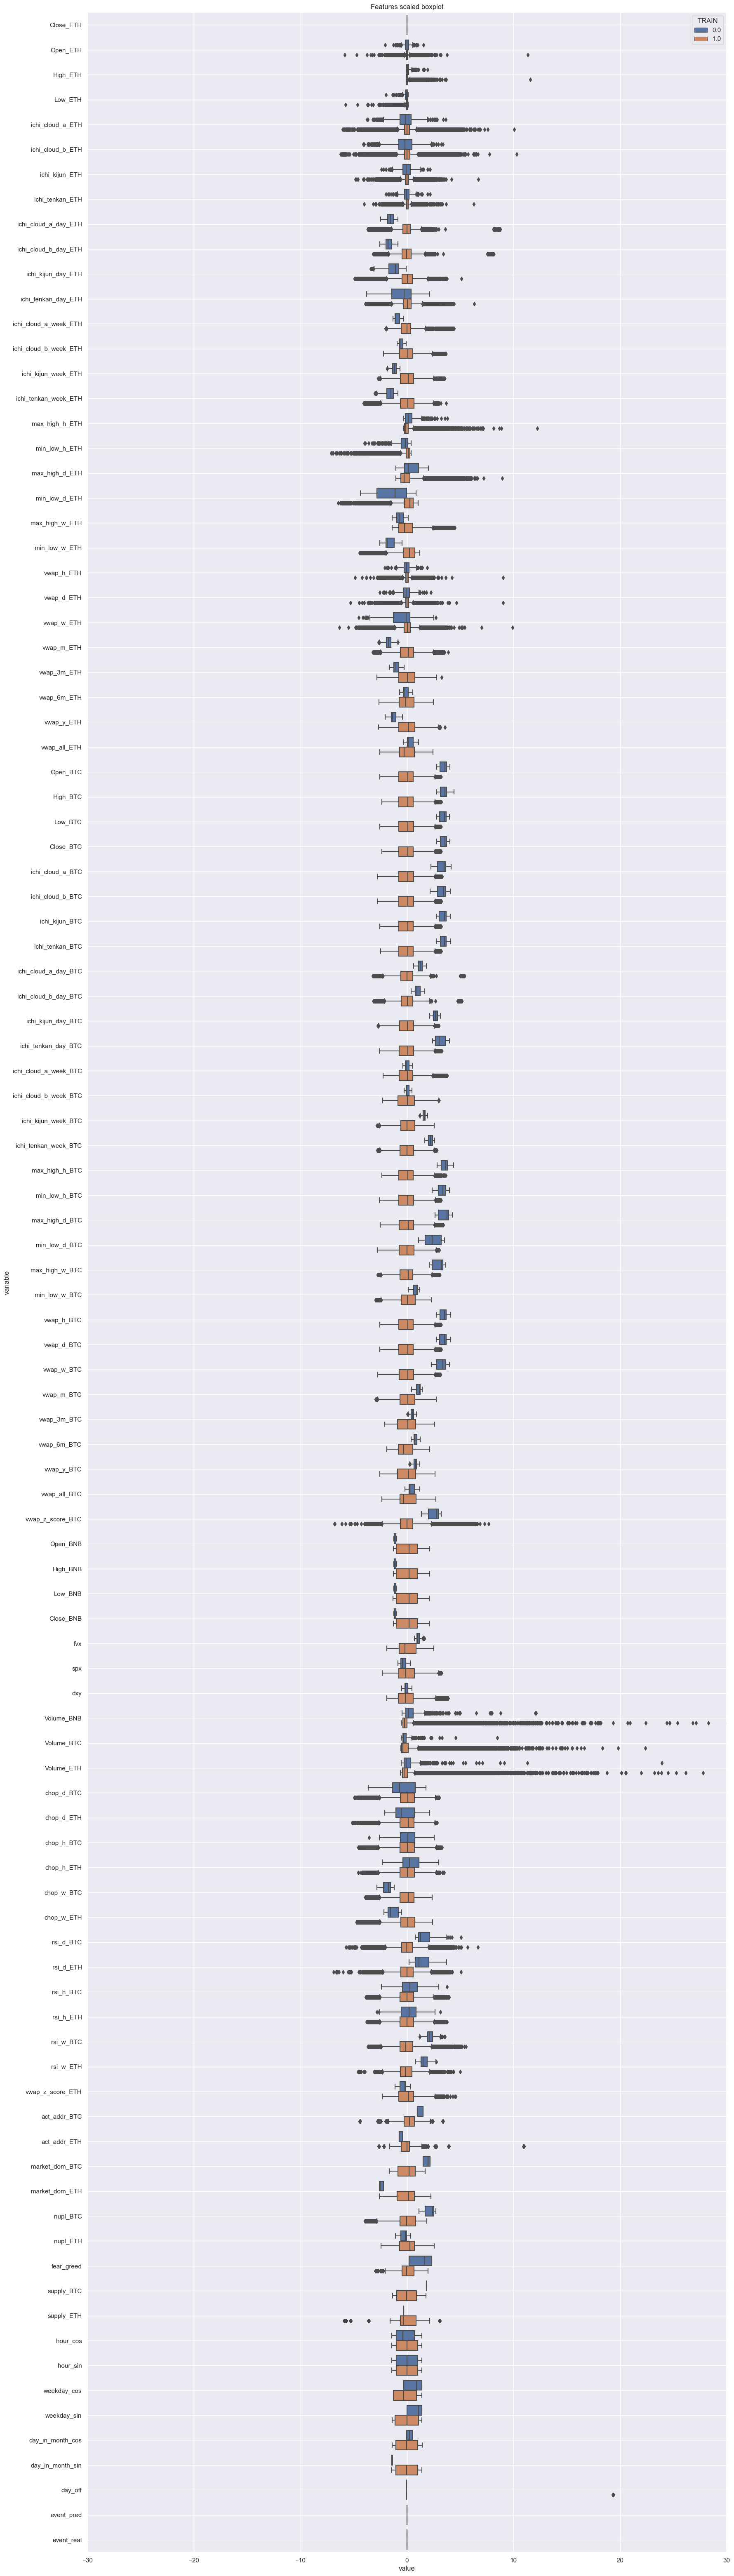

In [62]:
df_comp = df.melt(id_vars=["TRAIN"], value_vars=list_col_select, value_name="value")
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="value", y="variable" , hue="TRAIN")
fig = plt.gcf()
ax = fig.gca()
ax.set_xlim([-30,30])
ax.yaxis.grid(True)
plt.title("Features scaled boxplot")

<AxesSubplot: >

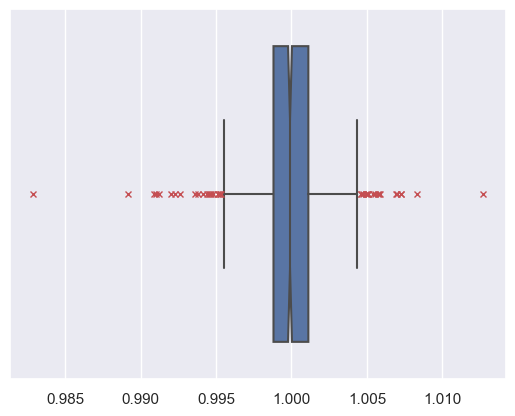

In [63]:
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    notch=True,
    flierprops={"markeredgecolor":"r", "marker": "x"}
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


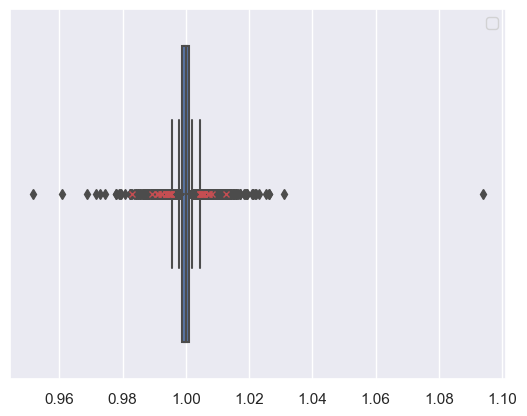

In [64]:
ax = sns.boxplot(
    x=X_train[:,-1,:][:,1],  
)
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    ax=ax, 
    flierprops={"markeredgecolor":"r", "marker": "x"},
)
plt.legend(loc='upper right')

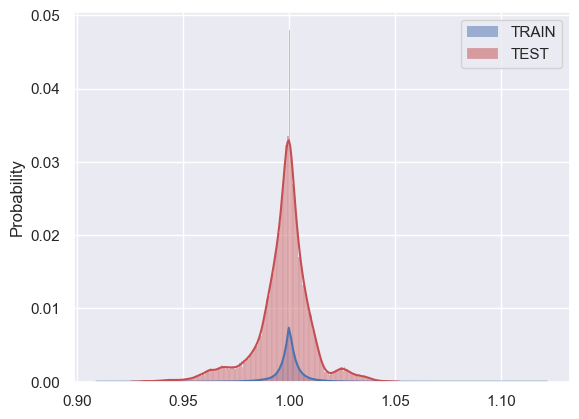

In [65]:

ax = sns.histplot(x=X_train.reshape(-1, X_train.shape[-1])[:,0],  stat="probability", kde=True, label="TRAIN")
sns.histplot(
    x=X_test.reshape(-1, X_test.shape[-1])[:,0],  
    stat="probability", 
    kde=True, 
    ax=ax, 
    color="r",
    label="TEST")
plt.legend(loc='upper right')

## Correlation

To simplify, we try to find correlation between all features X t-0 and target y t+1

In [66]:
X_train_sca.shape

(84878, 72, 102)

In [67]:
X_train_sca[:,-1,:].shape

(84878, 102)

In [68]:
y_train_sca[:,0][:, np.newaxis]

array([[ 0.1080562 ],
       [-0.02870231],
       [-0.20386949],
       ...,
       [ 0.67703409],
       [-0.75848079],
       [ 0.0442891 ]])

In [69]:
np.hstack((X_train_sca[:,-1,:], y_train_sca[:,0][:, np.newaxis])).shape

(84878, 103)

In [70]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [71]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [72]:
def plot_corr(corr_matrix, title='Corrélation with 2 variables', aspect=None):
    # Afficher la matrice de corrélation
    if aspect is None:
        aspect = 1
    fig_size = (16, 16*len(corr_matrix.index)/len(corr_matrix.columns))
    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.matshow(corr_matrix, aspect=aspect)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
    plt.title(title)
    fig.colorbar(im)
    plt.show()

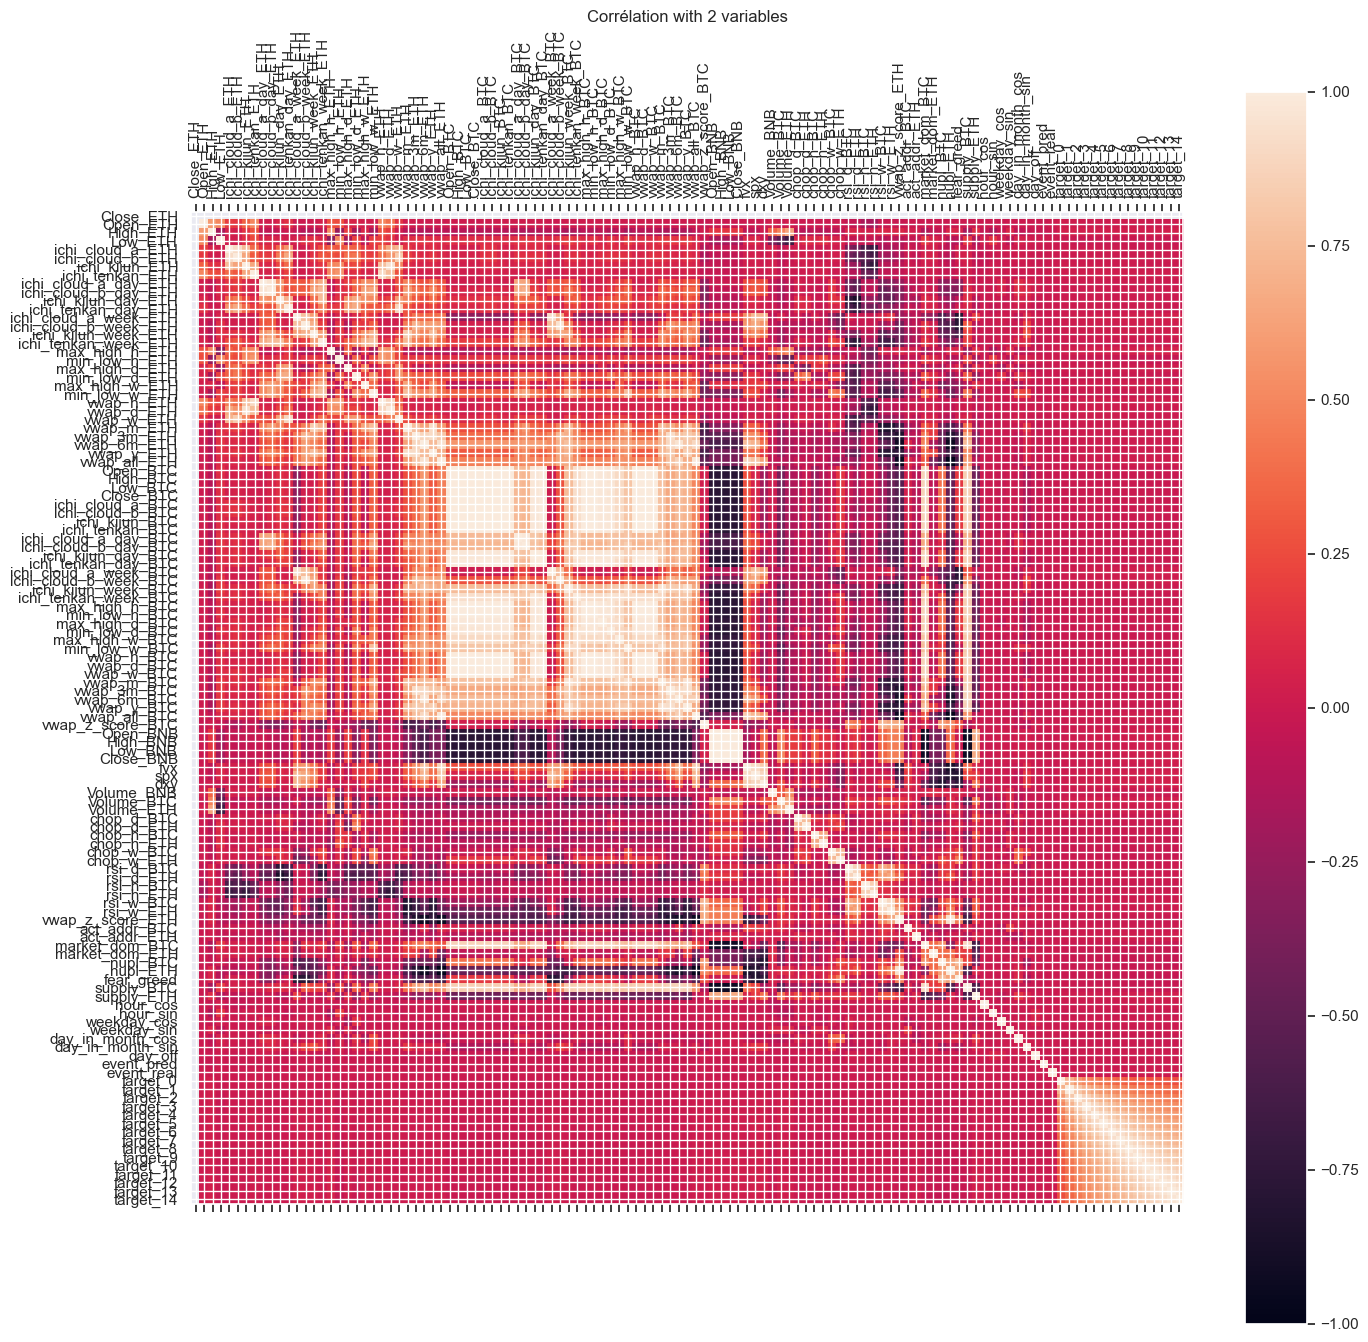

In [73]:

nb_plot = len(list_col_select)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_select[:nb_plot] + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)


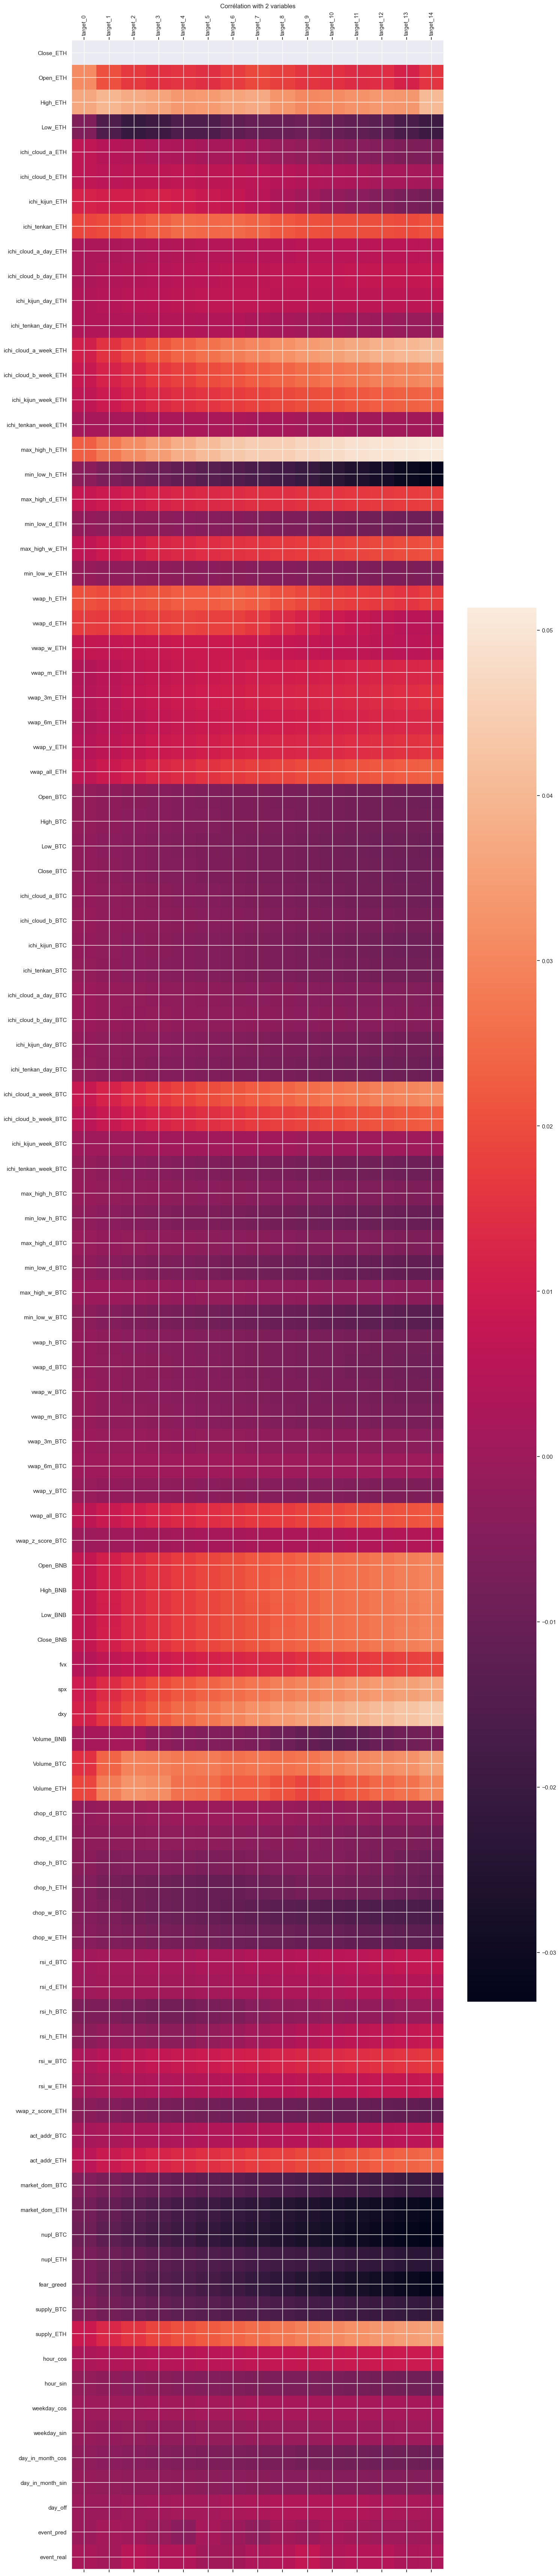

In [74]:
corr_matrix_targets = corr_matrix.copy().loc[list_col_select[:nb_plot], list_col_targets]
fig = plot_corr(corr_matrix_targets)


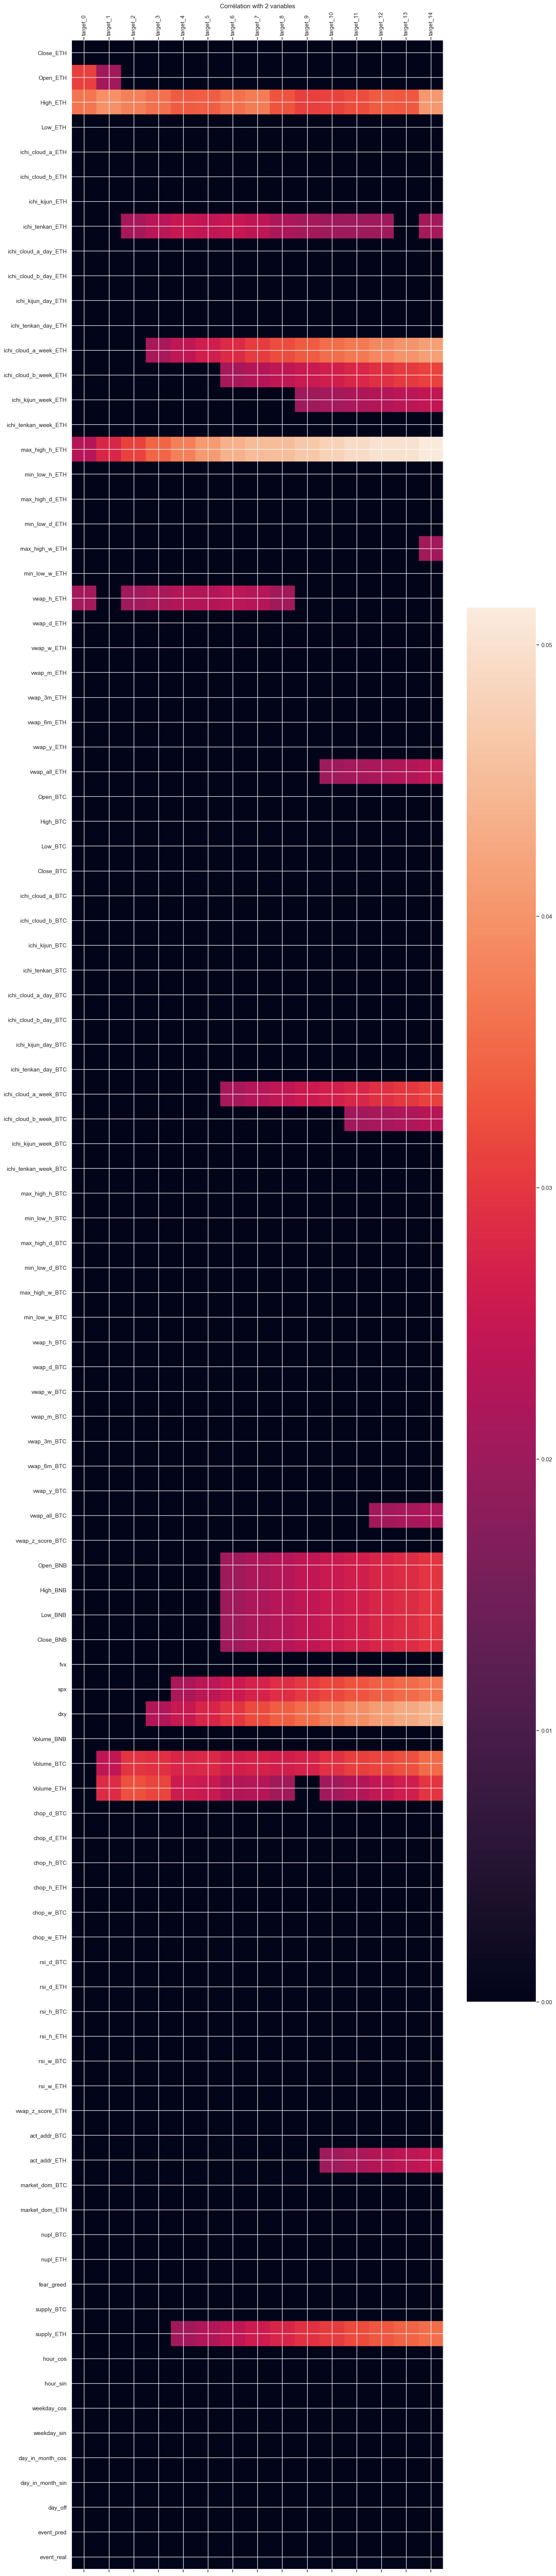

In [75]:
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0))

In [76]:
list_ichi_level=["lower", "neutral", "higher"]
df["ichi_cloud_a_week_cat"] = "neutral"
df.loc[df["ichi_cloud_a_week_ETH"] >= 1.05, "ichi_cloud_a_week_cat"] = "lower"
df.loc[df["ichi_cloud_a_week_ETH"] <= 0.95, "ichi_cloud_a_week_cat"] = "higher"

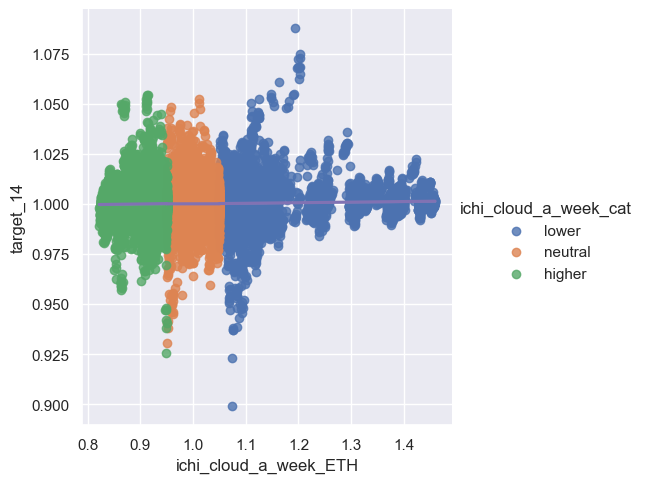

In [77]:
sns.lmplot(x="ichi_cloud_a_week_ETH", y="target_14",
            hue="ichi_cloud_a_week_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='ichi_cloud_a_week_cat'>

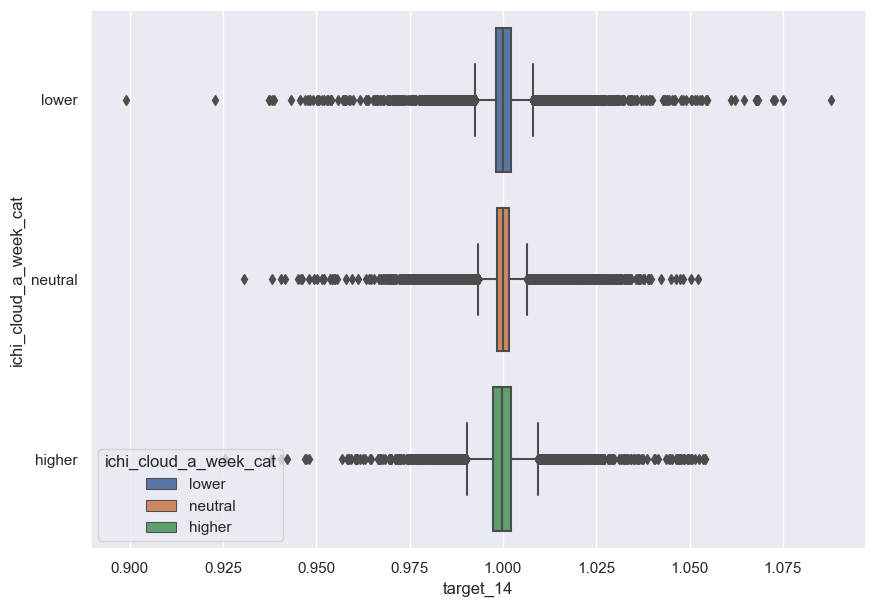

In [78]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="ichi_cloud_a_week_cat", 
    hue="ichi_cloud_a_week_cat", dodge=False, 
    order=list_ichi_level, hue_order=list_ichi_level)

In [79]:
"""df["vwap_all_ETH_under"] = df["vwap_all_ETH"] >= 1.05
df["vwap_all_ETH_above"] = df["vwap_all_ETH"] <= 0.95
df["vwap_all_ETH_neutral"] = ((df["vwap_all_ETH"] > 0.95) & (df["vwap_all_ETH"] < 1.05))
"""
list_vwap_level=["lower", "neutral", "higher"]
df["vwap_all_ETH_cat"] = "neutral"
df.loc[df["vwap_all_ETH"] >= 1.05, "vwap_all_ETH_cat"] = "lower"
df.loc[df["vwap_all_ETH"] <= 0.95, "vwap_all_ETH_cat"] = "higher"


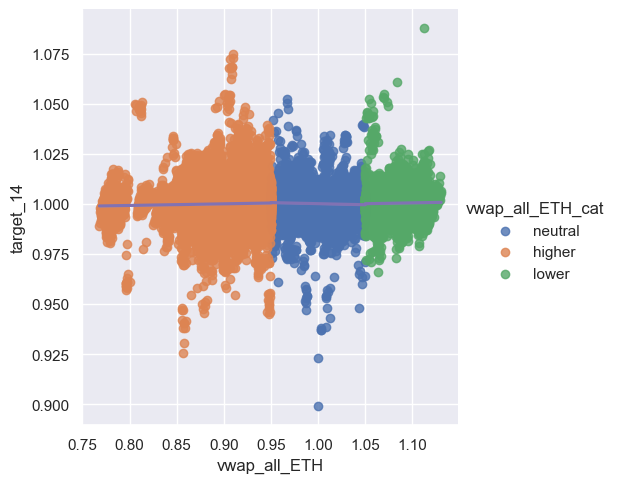

In [80]:
sns.lmplot(x="vwap_all_ETH", y="target_14", hue="vwap_all_ETH_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='vwap_all_ETH_cat'>

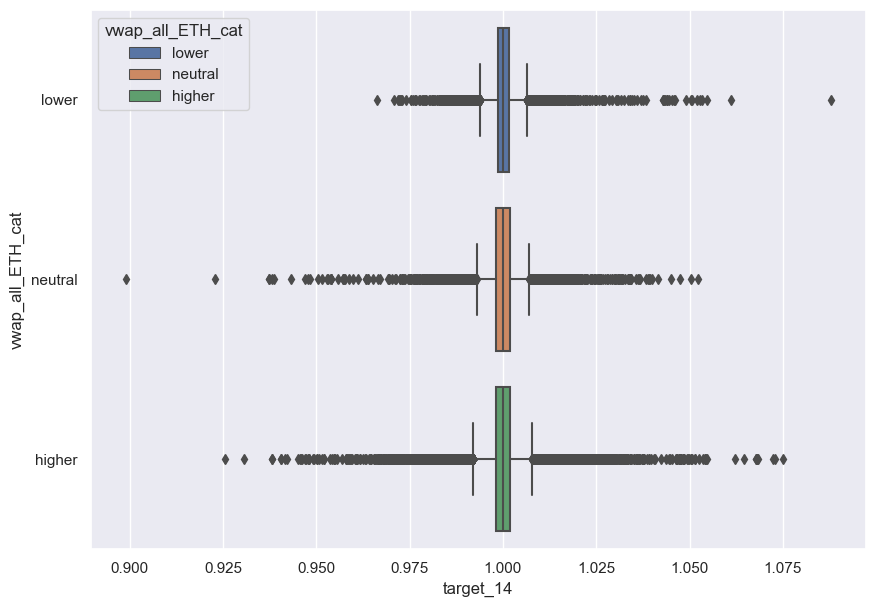

In [81]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="vwap_all_ETH_cat", 
    hue="vwap_all_ETH_cat", dodge=False, 
    order=list_vwap_level, hue_order=list_vwap_level)

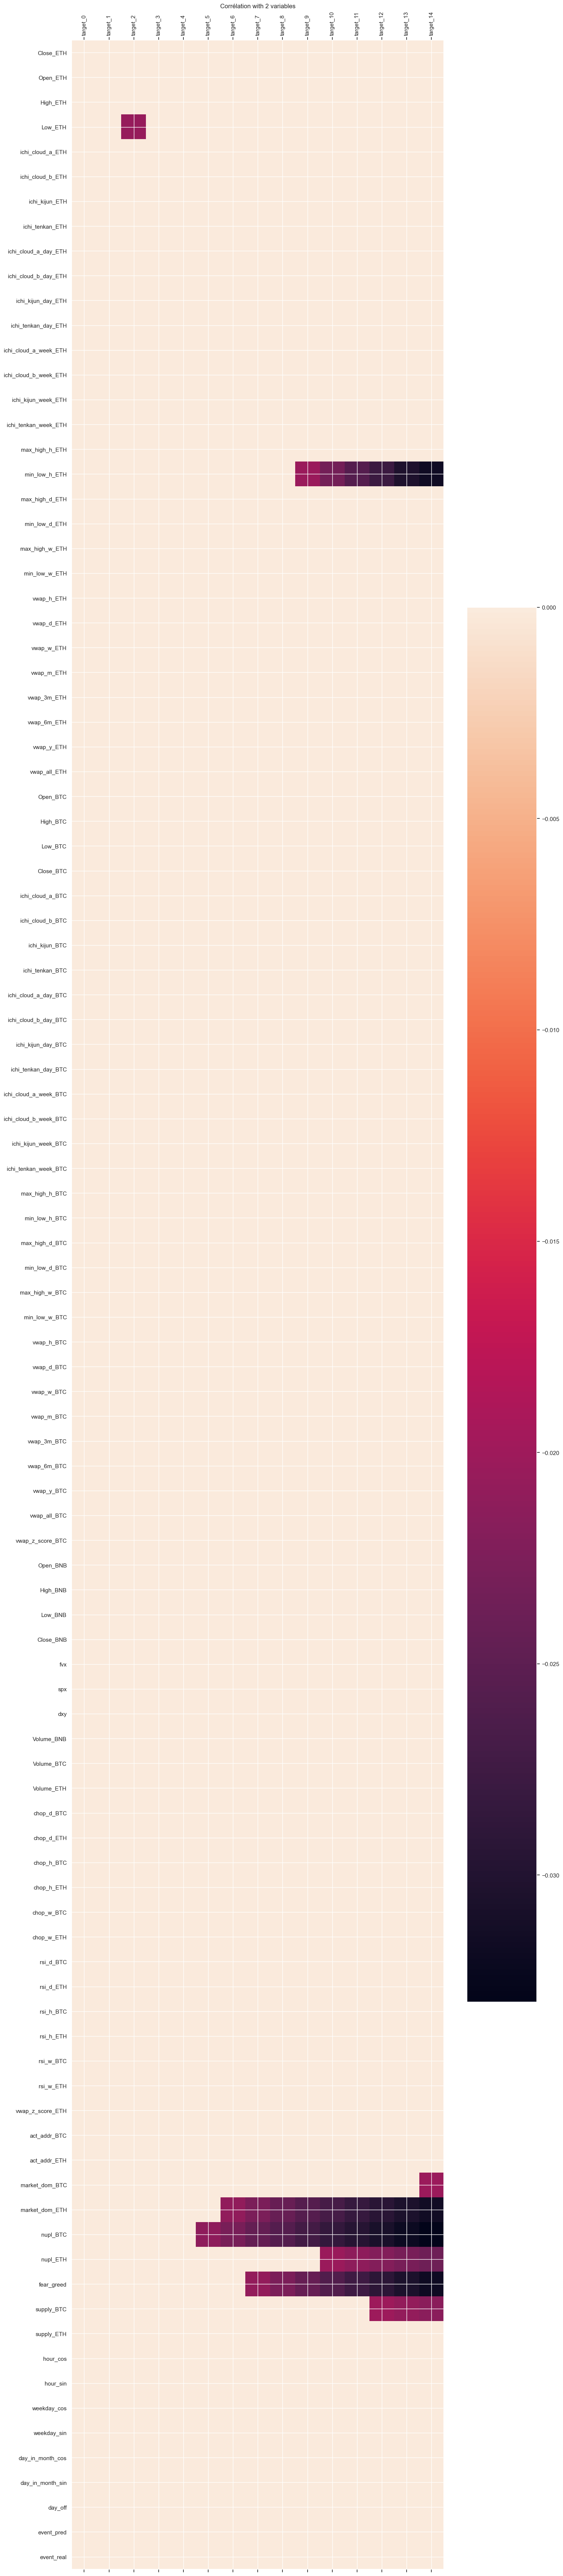

In [82]:
plot_corr(corr_matrix_targets.where(corr_matrix_targets<-0.02, 0))

Text(0.5, 1.0, 'Net Unrealized Profit/Loss impact : ETH price = f(NUPL)')

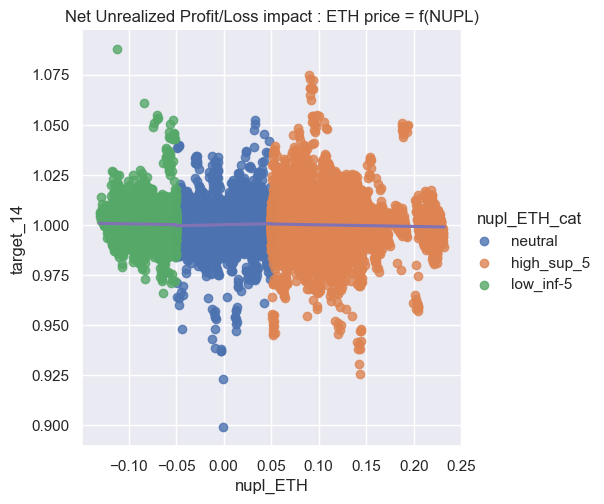

In [83]:
list_nupl_level=["low_inf-5", "neutral", "high_sup_5"]
df["nupl_ETH_cat"] = "neutral"
df.loc[df["nupl_ETH"] <= -0.05, "nupl_ETH_cat"] = "low_inf-5"
df.loc[df["nupl_ETH"] >= 0.05, "nupl_ETH_cat"] = "high_sup_5"

sns.lmplot(x="nupl_ETH", y="target_14", hue="nupl_ETH_cat", data=df,
           line_kws={"color": "C4"})
plt.title("Net Unrealized Profit/Loss impact : ETH price = f(NUPL)")

(0.98, 1.02)

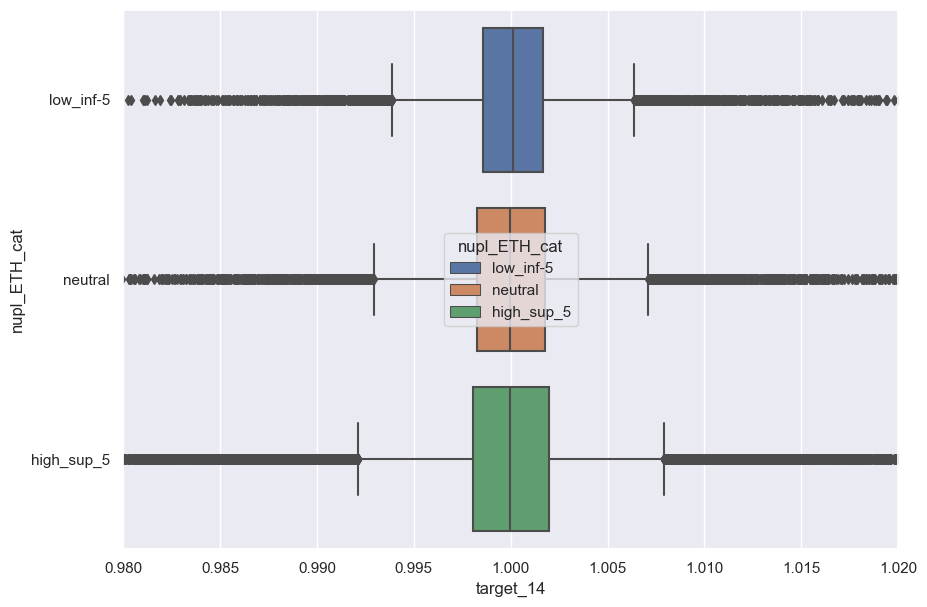

In [84]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="nupl_ETH_cat", 
    hue="nupl_ETH_cat", dodge=False, 
    order=list_nupl_level, hue_order=list_nupl_level)
ax = fig.gca()
ax.set_xlim([0.98,1.02])

In [85]:
df["target_14"].describe()

count    84878.000000
mean         1.000073
std          0.005334
min          0.899006
25%          0.998175
50%          1.000007
75%          1.001880
max          1.087790
Name: target_14, dtype: float64

In [86]:
df["target_1"].describe()

count    84878.000000
mean         1.000010
std          0.001988
min          0.907143
25%          0.999291
50%          1.000000
75%          1.000728
max          1.053076
Name: target_1, dtype: float64

<AxesSubplot: xlabel='target_14'>

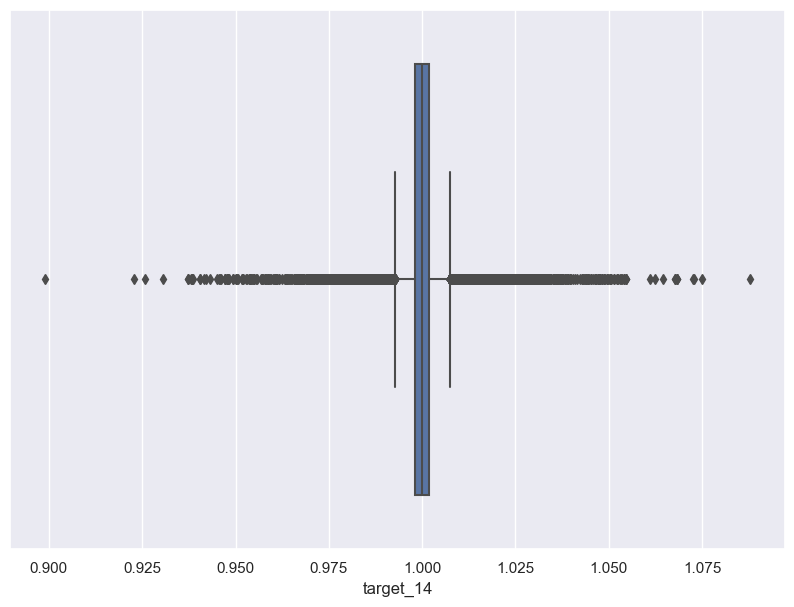

In [87]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(x=df["target_14"]) 

In [88]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00268934, 0.99974731, 0.99995789, ..., 1.00095059, 1.00192525,
        1.00167256],
       [0.99706587, 0.99727587, 0.99931597, ..., 0.99923796, 0.99898595,
        0.999928  ],
       [1.00021063, 1.00225673, 0.99877836, ..., 1.00192574, 1.00287055,
        1.00182343]])

In [89]:
y_train_sca

array([[ 0.1080562 ,  0.08882329, -0.1056428 , ..., -0.03725912,
         0.02898757, -0.04580708],
       [-0.02870231, -0.22307891, -0.05219838, ..., -0.08851049,
        -0.16327072, -0.31492719],
       [-0.20386949, -0.03297609, -0.15473764, ..., -0.1440568 ,
        -0.29572469, -0.36835438],
       ...,
       [ 0.67703409, -0.07398276, -0.020229  , ...,  0.23318159,
         0.48198472,  0.41748021],
       [-0.75848079, -0.7048712 , -0.18409234, ..., -0.20400447,
        -0.26833598, -0.02785868],
       [ 0.0442891 ,  0.56660049, -0.32132887, ...,  0.48210894,
         0.72329391,  0.45599337]])

## Autoencoder

### Model creation

### Training

In [90]:
X_train_sca.shape

(84878, 72, 102)

In [91]:
3*3*3*10*35/3600

2.625

In [92]:
#tf.keras.optimizers.AdamW()

In [93]:
#tf.keras.optimizers.legacy.AdamW()

In [94]:
#n_unit_enc = 16
#encoding_dim = 4
#dropout_autoenc = 0.5

epochs = 500 #100 #150 #6 #300
patience = 0 #30 #20 #40 #3 #100
mse_curr_min = None
if MODE_TRAIN_AE:
    for n_unit_enc in [128]: #[32, 64, 128]: #[104]: #
        for encoding_dim in [32]:#[16, 20, 32]:
            for dropout_autoenc in [0.25]: #[0.05, 0.15, 0.25]: #[0.25]:
                for seed in LIST_SEEDS:
                    # check already done ? 
                    #ie: output_MSE autoencoder - units 16 - enc_dim 4 - drop 0.25.jpg
                    plt_name = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
                    path_jpg = os.path.join(path_data,
                        f"output_MSE autoencoder - {plt_name}.jpg")
                    if (MODE_TRAIN_AE == False):
                        print(f"BE CAREFUL ! training inactivated => no training done...")
                        continue
                    print(f"Training: {plt_name} ...")
                    # Init
                    tf.keras.backend.clear_session()
                    np.random.seed(seed)
                    random.seed(seed)
                    tf.random.set_seed(seed)
                    # Input dimension
                    input_dim = X_train.shape[-1]
                    # Reduced encoded input dimension
                    # 64/8/0.5
                    # Définir l'encodeur
                    encoder_inputs = keras.Input(shape=(None, input_dim))
                    encoder = layers.LSTM(n_unit_enc, return_sequences=True)(encoder_inputs)
                    #encoder = layers.LayerNormalization()(encoder)
                    #encoder = layers.Dense(encoding_dim, activation='relu')
                    encoder = layers.Dropout(dropout_autoenc)(encoder)
                    encoder_outputs = layers.Dense(encoding_dim)(encoder)
                    encoder_model = keras.Model(encoder_inputs, encoder_outputs)
                    print(encoder_model.summary())
                    # Définir le décodeur
                    decoder_inputs = keras.Input(shape=(None, encoding_dim))
                    decoder = layers.LSTM(n_unit_enc, return_sequences=True)(decoder_inputs)
                    #decoder = layers.LayerNormalization()(decoder)
                    #decoder = layers.Dense(n_unit_enc, activation='relu')
                    decoder = layers.Dropout(dropout_autoenc)(decoder)
                    decoder_outputs = layers.Dense(input_dim)(decoder)
                    decoder_model = keras.Model(decoder_inputs, decoder_outputs)
                    print(decoder_model.summary())
                    # Define complete autoencoder 
                    autoencoder_inputs = keras.Input(shape=(None, input_dim))
                    encoded = encoder_model(autoencoder_inputs)
                    decoded = decoder_model(encoded)
                    autoencoder = keras.Model(autoencoder_inputs, decoded)
                    # Compile : autoencoder
                    optim = tf.keras.optimizers.legacy.Adam()
                    #optim = tf.keras.optimizers.AdamW()
                    #optim = tf.keras.optimizers.Adam()
                    autoencoder.compile(optimizer=optim, loss="mse")
                    # earlystop 
                    es = EarlyStopping(patience=patience, verbose=2, min_delta=0.001, 
                                    monitor='val_loss', mode='auto', restore_best_weights=True)
                    # Train
                    if patience == 0:
                        autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                        epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                        verbose=1)
                    else:
                        autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                            epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                            verbose=1, callbacks=[es])

                    plot_train_history(
                        autoenc_step_history,f"MSE autoencoder - {plt_name}",
                        saveFolder=path_data)
                    #autoencoder.save(f"{path_mdl_autoencoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
                    #encoder_model.save(f"{path_mdl_encoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
                                # save the best
                    mse_curr = np.min(autoenc_step_history.history['val_loss'])
                    print("MSE TEST : ", mse_curr)

                    if mse_curr_min == None:
                        seed_min = seed
                        autoenc_step_history_min = autoenc_step_history
                        mse_curr_min = mse_curr
                        n_unit_enc_min = n_unit_enc
                        encoding_dim_min = encoding_dim
                        dropout_autoenc_min = dropout_autoenc
                        print("Save autoencoder: ", path_mdl_autoencoder)
                        autoencoder.save(path_mdl_autoencoder)
                        print("Save encoder: ", path_mdl_encoder)
                        encoder_model.save(path_mdl_encoder)
                    else:
                        if mse_curr < mse_curr_min:
                            seed_min = seed
                            autoenc_step_history_min = autoenc_step_history
                            mse_curr_min = mse_curr
                            n_unit_enc_min = n_unit_enc
                            encoding_dim_min = encoding_dim
                            dropout_autoenc_min = dropout_autoenc
                            print("Save autoencoder: ", path_mdl_autoencoder)
                            autoencoder.save(path_mdl_autoencoder)
                            print("Save encoder: ", path_mdl_encoder)
                            encoder_model.save(path_mdl_encoder)

    mse_curr = mse_curr_min 
    n_unit_enc = n_unit_enc_min 
    encoding_dim = encoding_dim_min
    dropout_autoenc = dropout_autoenc_min

print("Load models...")
autoencoder = tf.keras.models.load_model(path_mdl_autoencoder)
print(autoencoder.summary())
encoder_model = tf.keras.models.load_model(path_mdl_encoder)
print(encoder_model.summary())
n_unit_enc = encoder_model.layers[1].units
dropout_autoenc = encoder_model.layers[2].rate
encoding_dim = encoder_model.layers[3].units
print(f"Model : n_unit:{n_unit_enc} / enc_dim: {encoding_dim} / dropout: {dropout_autoenc}")

if MODE_TRAIN_AE:
    print(f"Best model : seed:{seed} / n_unit:{n_unit_enc} / enc_dim: {encoding_dim} / dropout: {dropout_autoenc}")
    plot_train_history(
        autoenc_step_history_min, 
        f"Best MSE autoencoder - {plt_name}",
        saveFolder=path_data,
    )

Load models...


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 102)]       0         
                                                                 
 model (Functional)          (None, None, 32)          122400    
                                                                 
 model_1 (Functional)        (None, None, 102)         95590     
                                                                 
Total params: 217990 (851.52 KB)
Trainable params: 217990 (851.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 102)]       0         
                                                                 

In [95]:
path_mdl_autoencoder

'data/mdl_autoencoder'

In [96]:
#autoencoder.save(path_mdl_autoencoder)
#encoder_model.save(path_mdl_encoder)


In [97]:
X_train_sca_pred = autoencoder.predict(X_train_sca)
X_train_sca_pred.shape

2653/2653 [==============================] - 62s 23ms/step


(84878, 72, 102)

### Results

In [98]:
X_train[:,-1,0]

array([1., 1., 1., ..., 1., 1., 1.])

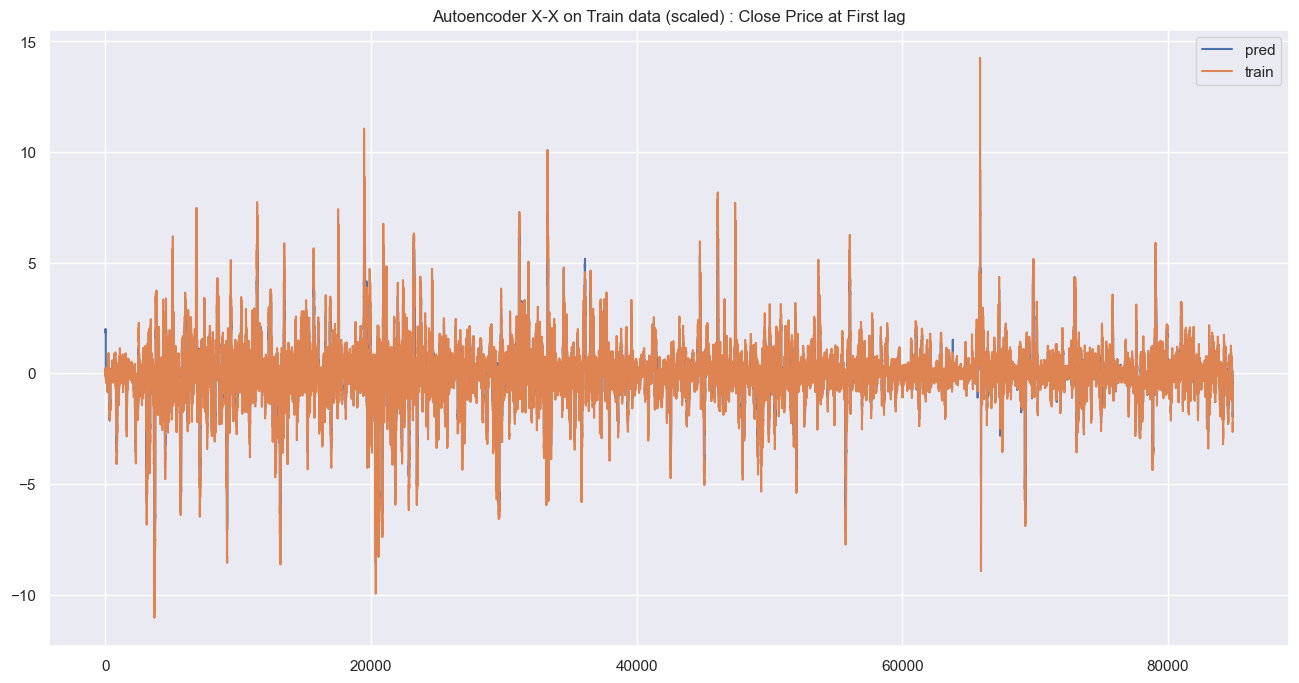

In [99]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data (scaled) : Close Price at First lag")
plt.plot(X_train_sca_pred[:,0,0], label="pred")
plt.plot(X_train_sca[:,0,0], label="train")
plt.legend(loc='upper right')

##### MAE TRAIN by lags and by features

In [100]:
print(X_train_sca_pred.shape) 
print(X_train_sca.shape)

mae_ae_train = np.mean(np.abs(X_train_sca_pred - X_train_sca), 0)
print(mae_ae_train.shape)

df_mae_ae_train = pd.DataFrame(mae_ae_train, columns=list_col_select)
df_mae_ae_train.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_ae_train.index))]
mae_ae_train_feat = np.mean(mae_ae_train, 0)[np.newaxis,:]
print(mae_ae_train_feat.shape)

df_mae_ae_train_feat = pd.DataFrame(mae_ae_train_feat, columns=list_col_select)

(84878, 72, 102)
(84878, 72, 102)
(72, 102)
(1, 102)


In [101]:
df_mae_ae_train

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.198163  0.201894  0.196528  0.198504          0.224376   
lag_1    0.188152  0.182679  0.180723  0.185127          0.190113   
lag_2    0.195650  0.188365  0.186875  0.193111          0.178215   
lag_3    0.196647  0.189529  0.187559  0.194726          0.170840   
lag_4    0.194338  0.186897  0.185156  0.192198          0.166101   
...           ...       ...       ...       ...               ...   
lag_67   0.110705  0.118434  0.107157  0.114061          0.133237   
lag_68   0.108165  0.116403  0.104688  0.111639          0.132874   
lag_69   0.105498  0.114264  0.102185  0.109234          0.132532   
lag_70   0.102956  0.112047  0.099704  0.106832          0.132165   
lag_71   0.100235  0.110023  0.097139  0.104459          0.131840   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.231812        0.182349         0.191164   
lag_1           0.194838        0.177882         0.180607   
lag_2           0.178185        0.181572         0.184439   
lag_3           0.168821        0.179820         0.184041   
lag_4           0.163027        0.176927         0.180755   
...                  ...             ...              ...   
lag_67          0.142235        0.118728         0.113034   
lag_68          0.142028        0.117314         0.111186   
lag_69          0.141827        0.115886         0.109347   
lag_70          0.141608        0.114500         0.107505   
lag_71          0.141406        0.113004         0.105505   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  \
lag_0               0.208956              0.190193  ...    0.161524  0.418493   
lag_1               0.175143              0.162514  ...    0.115109  0.380273   
lag_2               0.167330              0.154411  ...    0.095715  0.348182   
lag_3               0.160410              0.150613  ...    0.088970  0.332228   
lag_4               0.156458              0.146891  ...    0.088892  0.323527   
...                      ...                   ...  ...         ...       ...   
lag_67              0.147255              0.145188  ...    0.085532  0.314942   
lag_68              0.147265              0.145187  ...    0.085531  0.314916   
lag_69              0.147269              0.145184  ...    0.085529  0.314887   
lag_70              0.147273              0.145186  ...    0.085525  0.314849   
lag_71              0.147283              0.145191  ...    0.085521  0.314823   

        hour_sin  weekday_cos  weekday_sin  day_in_month_cos  \
lag_0   0.416336     0.427594     0.423093          0.310168   
lag_1   0.374555     0.384716     0.369421          0.222127   
lag_2   0.348365     0.366483     0.356851          0.203918   
lag_3   0.334280     0.355342     0.345184          0.193291   
lag_4   0.326112     0.344289     0.339082          0.191915   
...          ...          ...          ...               ...   
lag_67  0.304690     0.336343     0.341330          0.189191   
lag_68  0.304681     0.336325     0.341329          0.189196   
lag_69  0.304668     0.336302     0.341324          0.189205   
lag_70  0.304659     0.336292     0.341311          0.189220   
lag_71  0.304637     0.336265     0.341293          0.189233   

        day_in_month_sin   day_off  event_pred  event_real  
lag_0           0.259485  0.040582    0.101181    0.071191  
lag_1           0.158082  0.028982    0.068540    0.033870  
lag_2           0.141784  0.027284    0.046740    0.031237  
lag_3           0.132020  0.025515    0.036967    0.027168  
lag_4           0.130889  0.024308    0.032258    0.024765  
...                  ...       ...         ...         ...  
lag_67          0.129489  0.022215    0.025896    0.022051  
lag_68          0.129484  0.022218    0.025883    0.022053  
lag_69          0.129481  0.022219    0.025872    0.022049  
lag_70          0.129480  0.022213    0.025861    0.022028  
lag_71          0.129475  0.02221

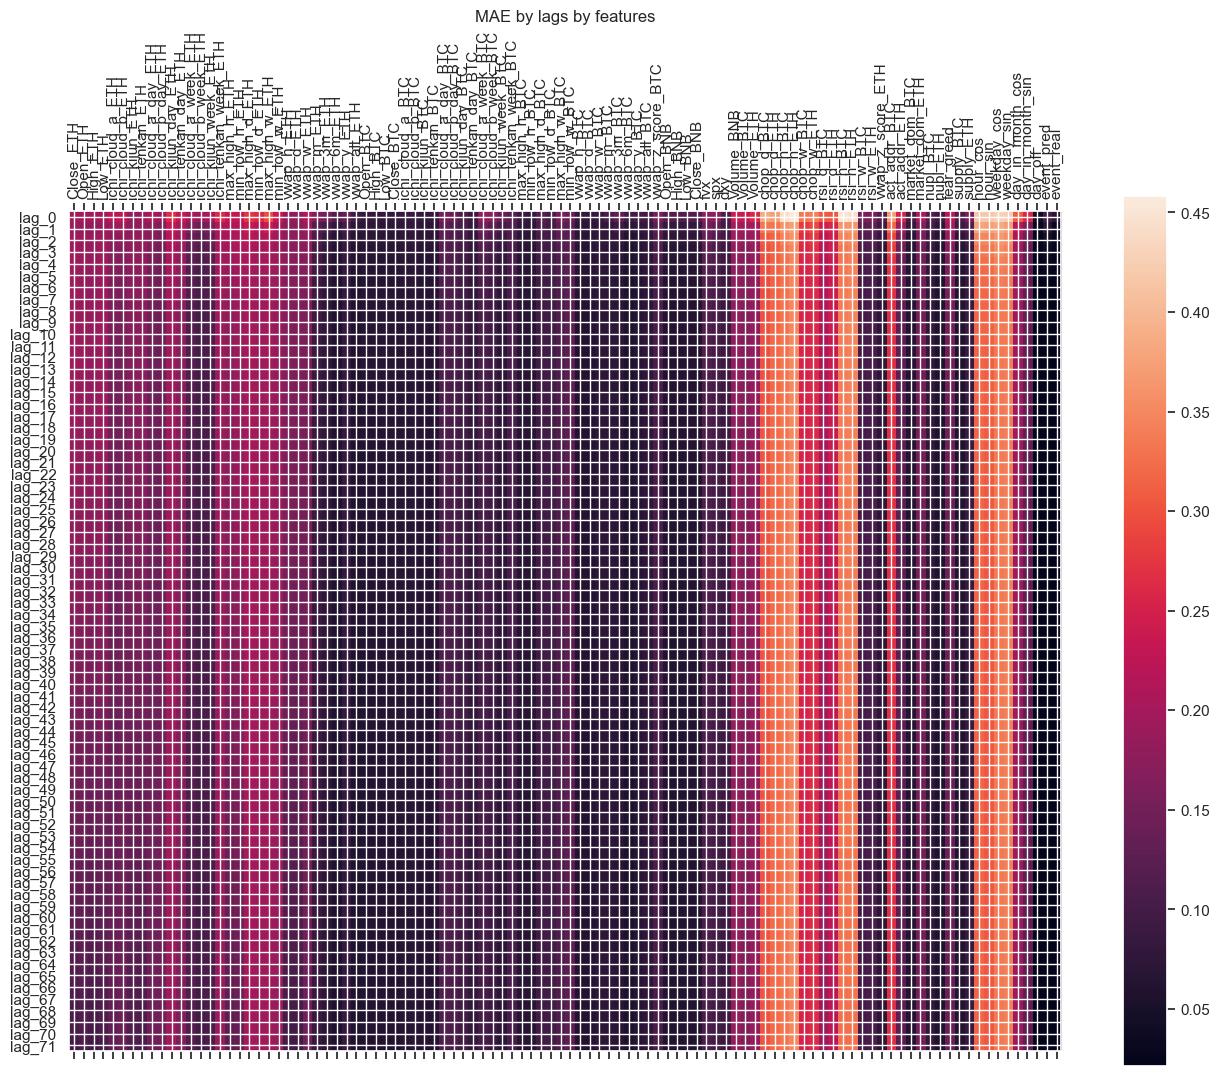

In [102]:
plot_corr(df_mae_ae_train, "MAE by lags by features", aspect=1.2 )

/Users/gregory/miniforge3/envs/ocean_tf_new/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

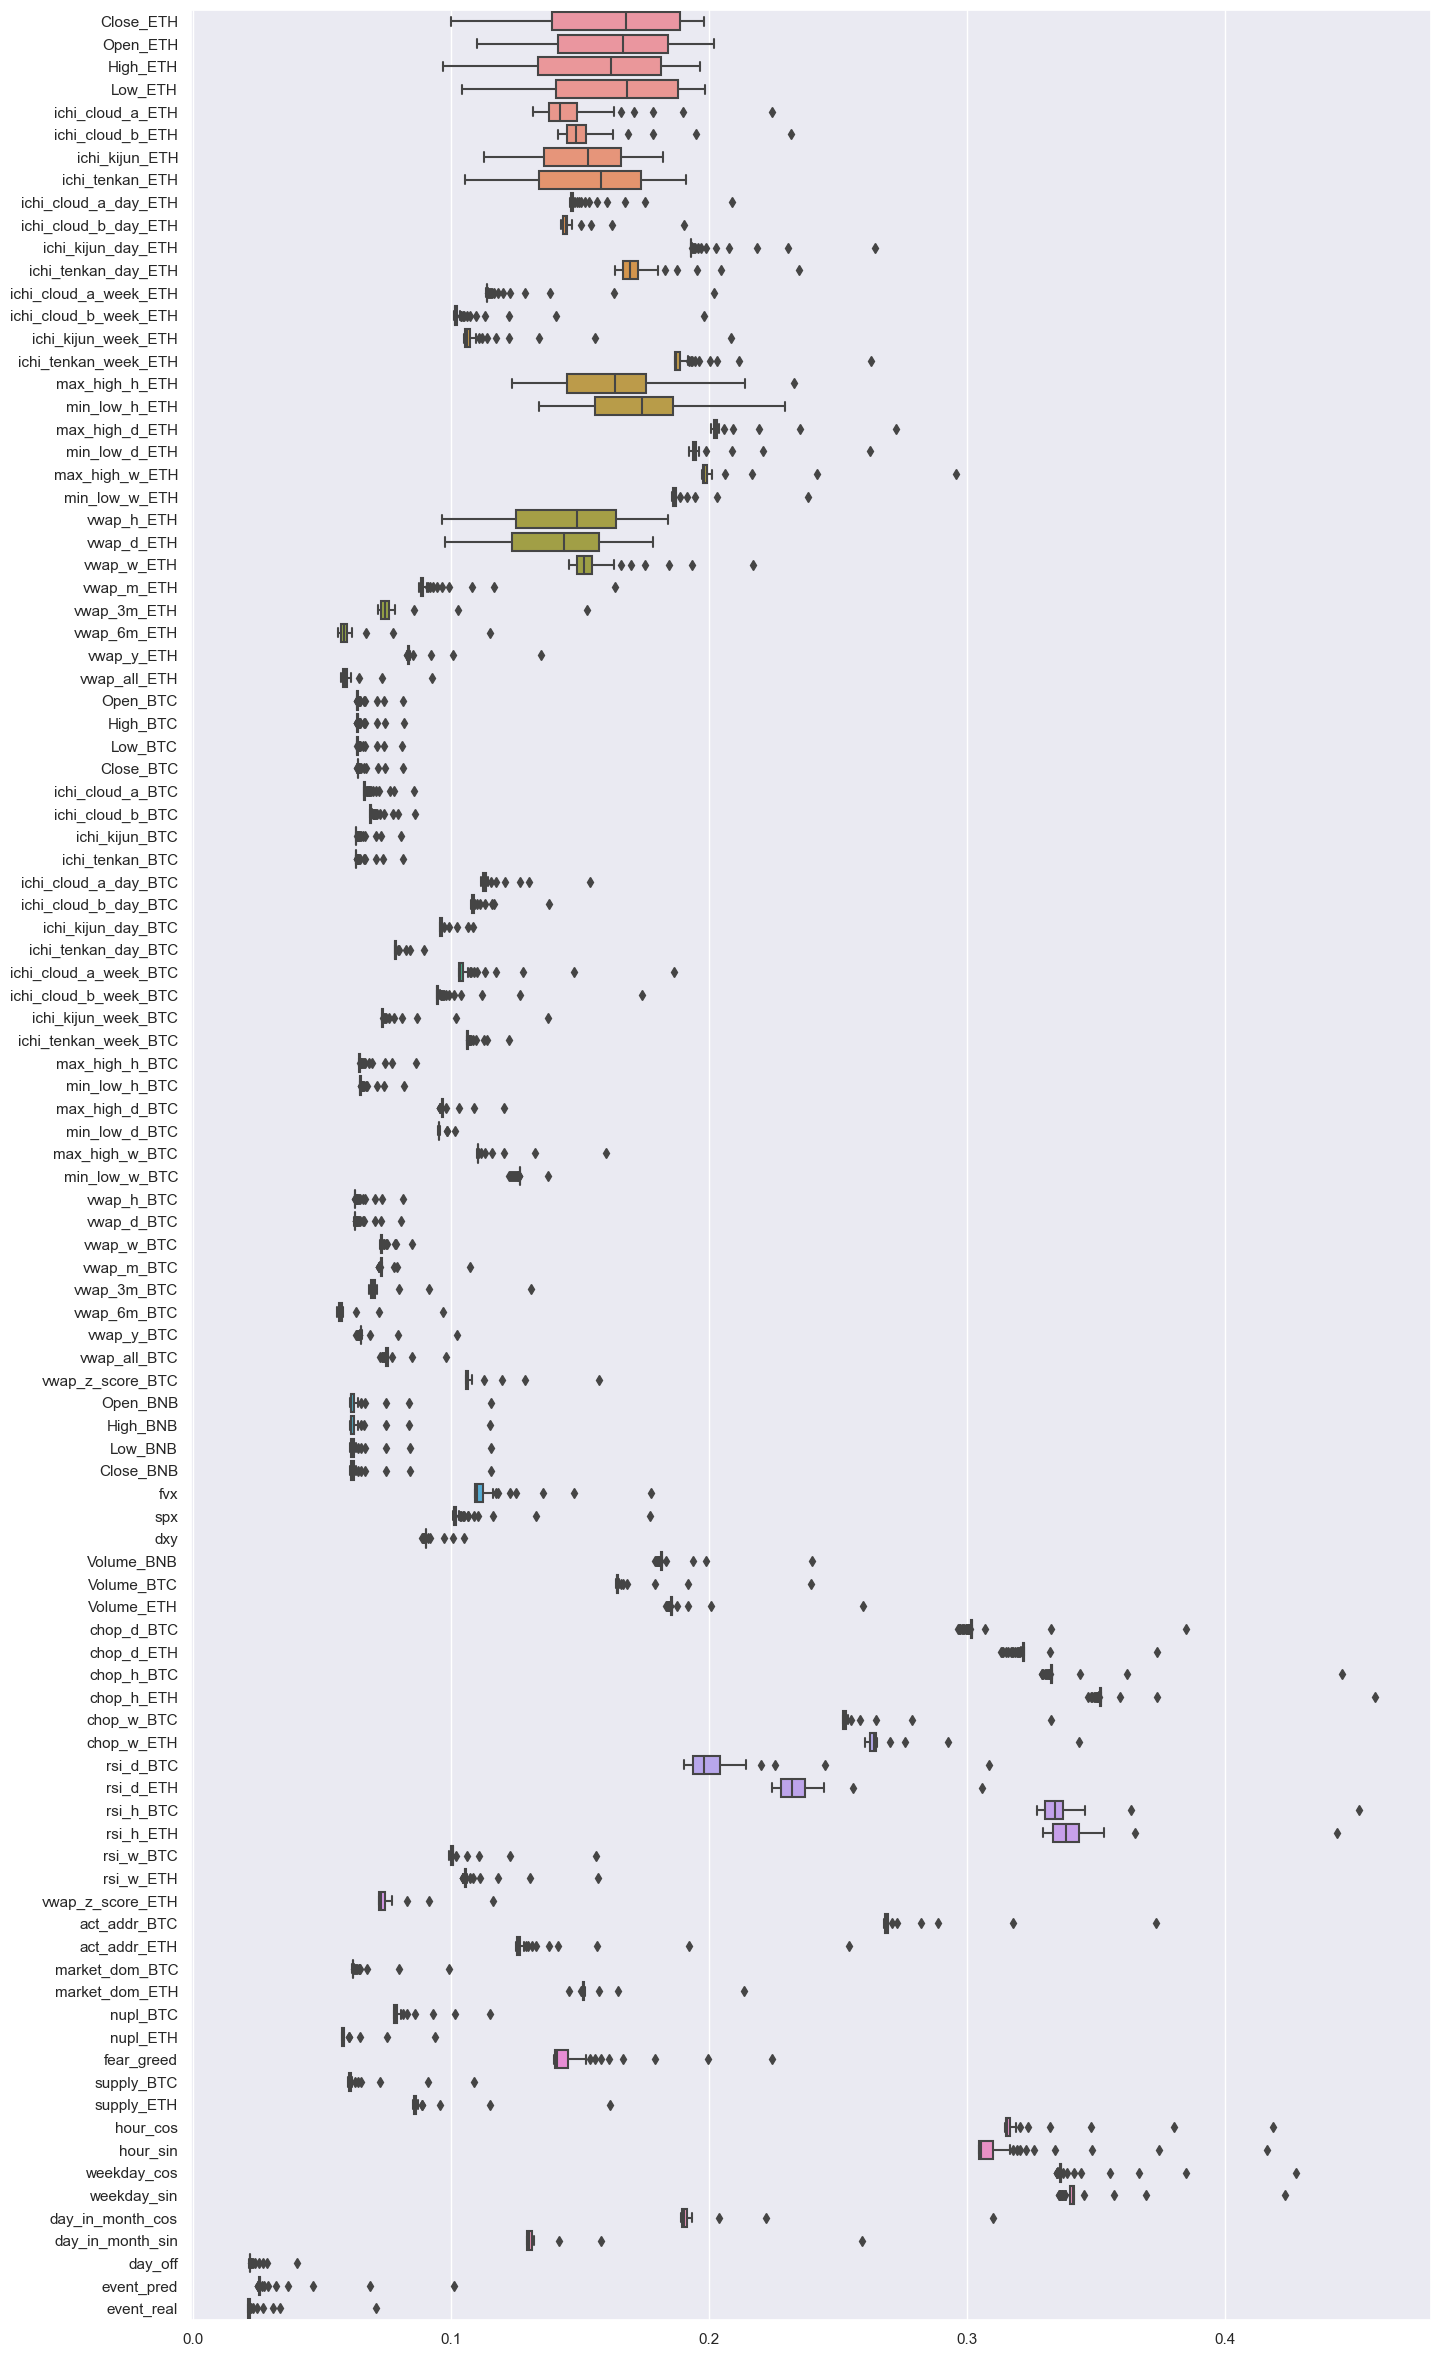

In [103]:
plt.figure(figsize=(16, 30))
sns.boxplot(data=df_mae_ae_train, orient="h")

In [104]:
df_mae_ae_train_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.161741  0.161165  0.155603  0.162114          0.145915   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.151202        0.150409         0.152838              0.148934   

   ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  hour_sin  weekday_cos  \
0              0.145425  ...    0.087722  0.318943  0.311113     0.338918   

   weekday_sin  day_in_month_cos  day_in_month_sin   day_off  event_pred  \
0     0.342085          0.192723          0.132782  0.022651    0.028086   

   event_real  
0     0.02291  

[1 rows x 102 columns]

Text(0.5, 1.0, 'MAE per feature')

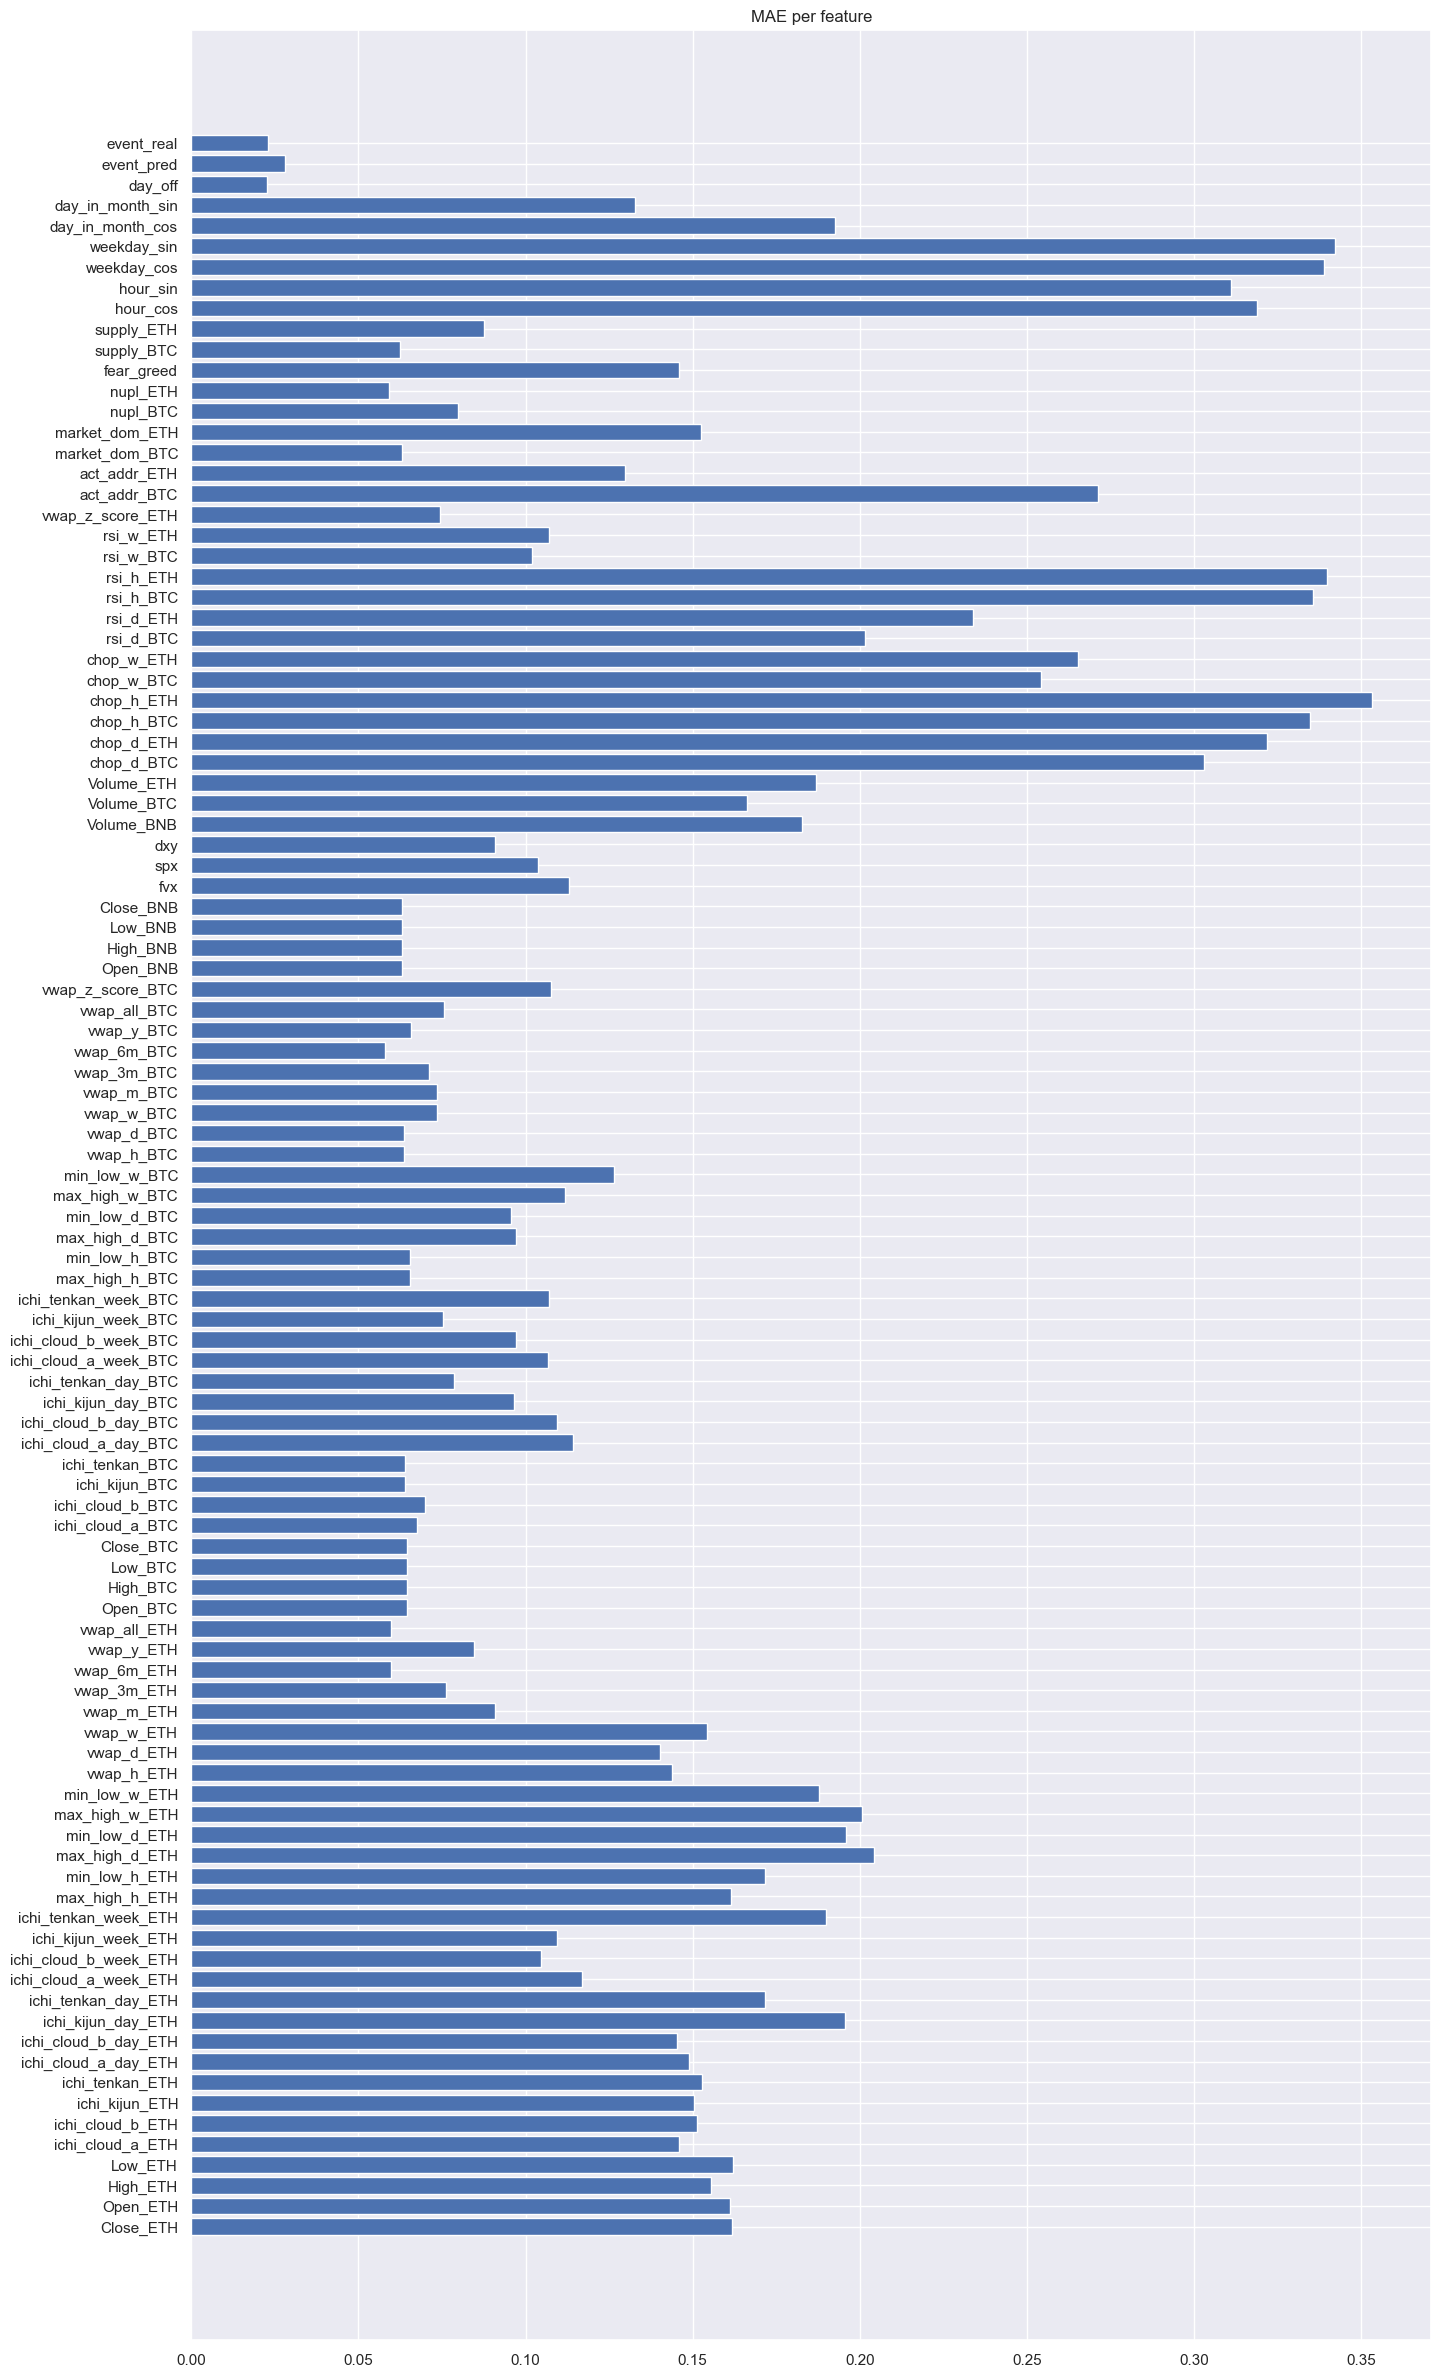

In [105]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_ae_train_feat.columns, df_mae_ae_train_feat.values[0])
plt.title("MAE per feature")

In [106]:
# X_train_raw
# X_train[0,:10, 0] * X_train_raw[0,-1, 0]
# [samples, lags, features]
print(X_train[:,0, 0].shape)
print(X_train_raw[:,-1, 0].shape)
print(X_train[:,0, 0] * X_train_raw[:,-1, 0])
print(df_feat["Close_ETH"].values[:3])

(84878,)
(84878,)
[1196.32 1195.38 1194.55 ... 1631.21 1630.36 1631.37]
[1196.32 1195.38 1194.55]


In [107]:
X_train_pred = scaler.inverse_transform(X_train_sca_pred.reshape(-1,X_train_sca_pred.shape[-1])).reshape(X_train_sca_pred.shape)
X_train_pred[:,-1,0]

array([0.9993438 , 0.99942154, 0.9995343 , ..., 0.996173  , 0.9963938 ,
       0.9990044 ], dtype=float32)

[1196.32 1195.38 1194.55 ... 1631.21 1630.36 1631.37]
[1213.71661645 1214.06416908 1214.16092336 ... 1637.61026228 1639.71748868
 1637.78805165]


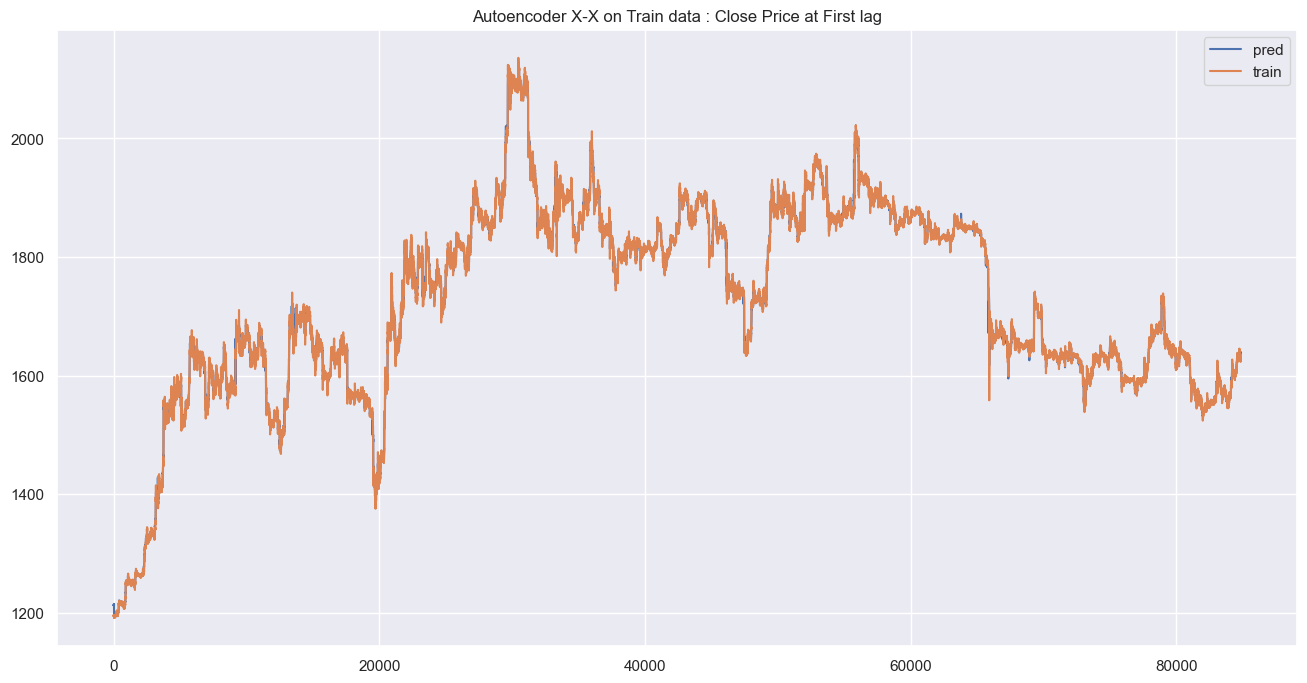

In [108]:
print(X_train_raw[:,0, 0])
print(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data : Close Price at First lag")
plt.plot(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0], label="pred")
plt.plot(X_train_raw[:,0,0], label="train")
plt.legend(loc='upper right')

#### MAE TEST per features

In [109]:
X_test_sca_pred = autoencoder.predict(X_test_sca)
X_test_sca_pred.shape

25/25 [==============================] - 1s 33ms/step


(770, 72, 102)

In [110]:
df_feat["date_ETH"].iloc[TRAIN_SPLIT]

'2023-10-23 00:20:00'

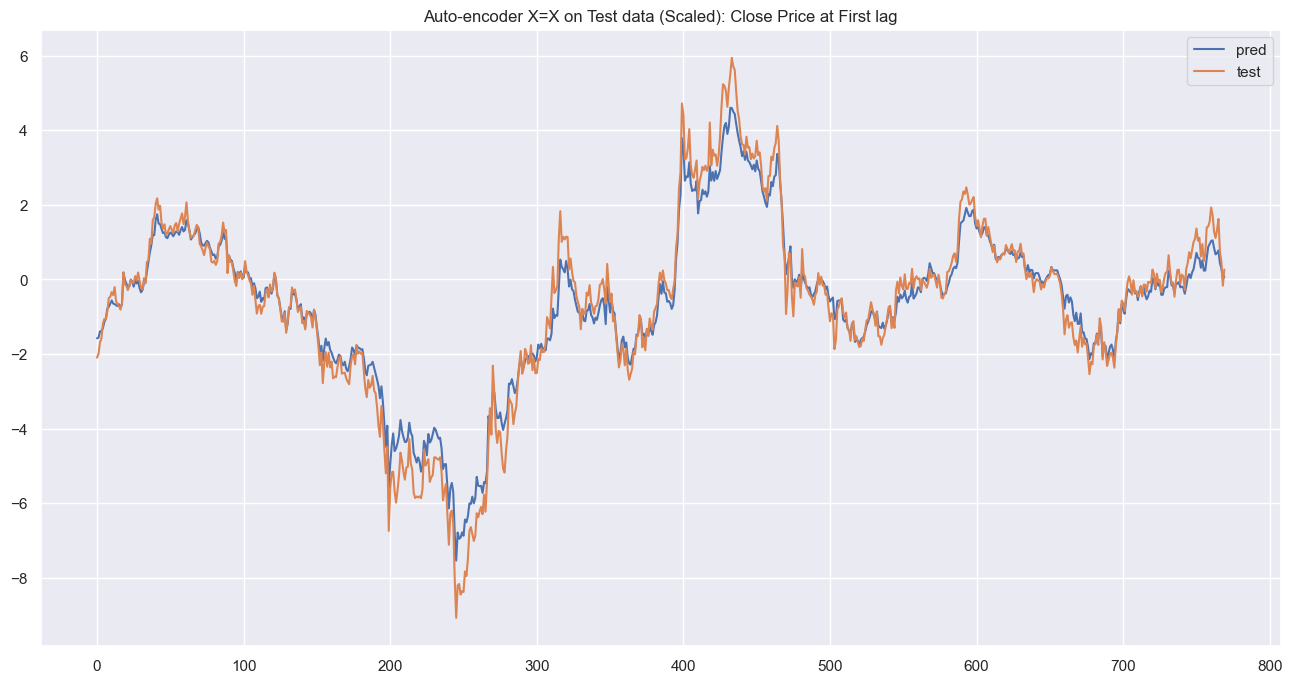

In [111]:
fig = plt.figure(figsize=(16, 8))
plt.title("Auto-encoder X=X on Test data (Scaled): Close Price at First lag")
plt.plot(X_test_sca_pred[:,0,0], label="pred")
plt.plot(X_test_sca[:,0,0], label="test")
plt.legend(loc='upper right')

In [112]:
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
X_test_pred = scaler.inverse_transform(X_test_sca_pred.reshape(-1,X_test_sca_pred.shape[-1])).reshape(X_test_sca_pred.shape)
print("X test raw  : ", X_test_raw[:,0, 0][:9])
print("X test pred : ", (X_test_pred[:,0,0] * X_test_raw[:,-1, 0])[:9])

X test raw  :  [1660.7  1662.75 1664.06 1666.23 1672.69 1672.64 1672.99 1670.74 1676.14]
X test pred :  [1667.87699524 1668.70969828 1668.12020168 1668.96417619 1670.99270283
 1671.59248346 1673.27397934 1671.78522982 1672.89965502]


[1660.7  1662.75 1664.06 1666.23 1672.69 1672.64 1672.99 1670.74 1676.14
 1676.35 1678.49 1679.24 1683.32 1677.55 1677.67 1675.95 1674.37 1676.62
 1676.31 1674.12 1674.13 1673.93 1675.8  1675.92 1675.6  1677.67 1679.71
 1677.97 1680.35 1680.51 1679.7  1679.12 1680.58 1677.92 1684.12 1683.65
 1691.39 1685.64 1690.01 1693.66 1696.42 1695.45 1694.54 1697.87 1692.31
 1691.47 1693.17 1691.23 1691.63 1692.33 1693.13 1692.01 1691.12 1694.49
 1694.81 1690.23 1694.9  1696.14 1697.79 1695.92 1697.76 1703.68 1698.
 1694.23 1695.72 1694.92 1693.17 1694.66 1696.62 1695.12 1688.86 1689.85
 1690.47 1687.5  1688.27 1689.17 1687.39 1687.99 1682.74 1683.17 1682.93
 1683.3  1685.21 1686.32 1685.96 1686.73 1686.01 1685.72 1685.63 1673.95
 1676.15 1676.67 1678.01 1678.28 1676.27 1676.89 1679.2  1678.62 1678.45
 1677.94 1681.12 1682.98 1682.91 1680.26 1679.49 1677.89 1676.84 1676.56
 1672.61 1668.46 1671.01 1668.93 1665.96 1669.11 1671.03 1671.75 1673.
 1673.07 1674.83 1674.88 1674.09 1673.68 1673.97 1674.2

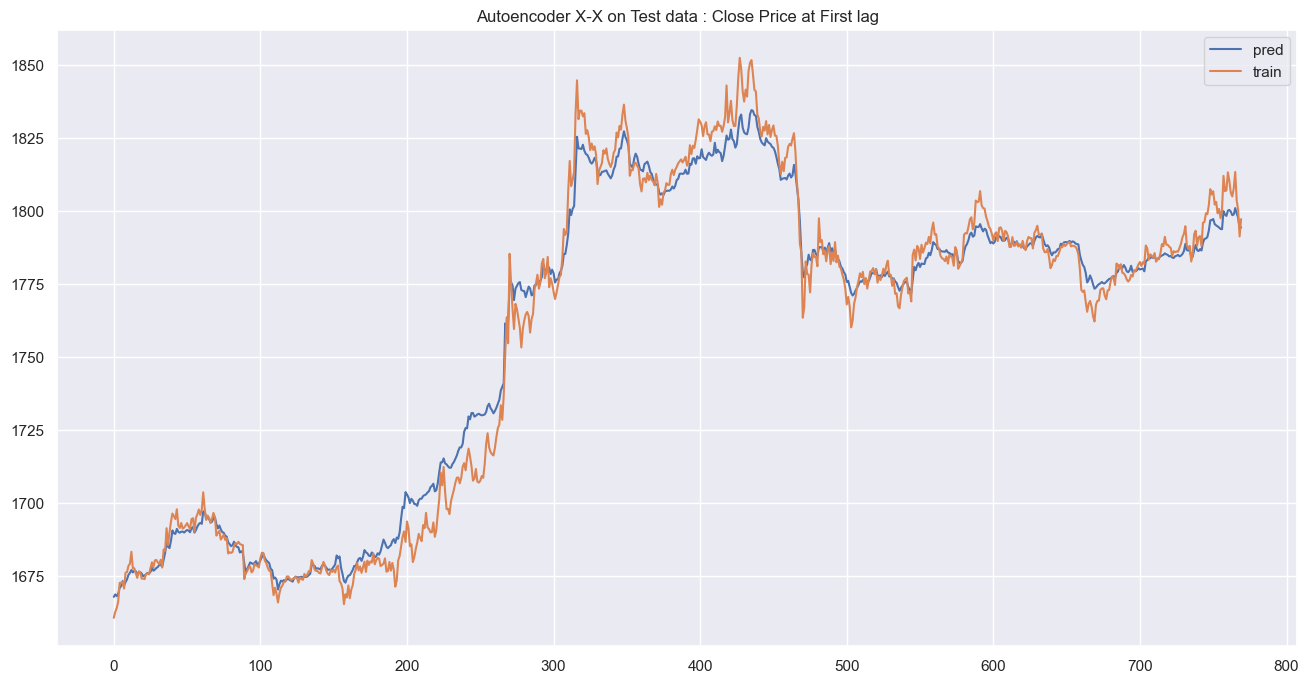

In [113]:
print(X_test_raw[:,0, 0])
print(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Test data : Close Price at First lag")
plt.plot(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0], label="pred")
plt.plot(X_test_raw[:,0,0], label="train")
plt.legend(loc='upper right')

In [114]:
X_test_sca.shape

(770, 72, 102)

In [115]:
mean_absolute_error(X_test_sca[:,0,:], X_test_sca_pred[:,0,:])

0.42183084893875084

In [116]:
print(X_test_sca_pred.shape) 
print(X_test_sca.shape)
mae_ae_test = np.mean(np.abs(X_test_sca_pred - X_test_sca), 0)
print(mae_ae_test.shape)
mae_ae_test_feat = np.mean(mae_ae_test, 0)[np.newaxis,:]
print(mae_ae_test_feat.shape)
df_mae_ae_test = pd.DataFrame(mae_ae_test, columns=list_col_select)
df_mae_ae_test.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_ae_test.index))]
df_mae_ae_test_feat = pd.DataFrame(mae_ae_test_feat, columns=list_col_select)
df_mae_ae_test["dataset"] = "TEST"
df_mae_ae_train["dataset"] = "TRAIN"
df_mae_ae_comp = pd.concat([df_mae_ae_train, df_mae_ae_test], ignore_index=False)
df_mae_ae_comp

(770, 72, 102)
(770, 72, 102)
(72, 102)
(1, 102)


Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.198163  0.201894  0.196528  0.198504          0.224376   
lag_1    0.188152  0.182679  0.180723  0.185127          0.190113   
lag_2    0.195650  0.188365  0.186875  0.193111          0.178215   
lag_3    0.196647  0.189529  0.187559  0.194726          0.170840   
lag_4    0.194338  0.186897  0.185156  0.192198          0.166101   
...           ...       ...       ...       ...               ...   
lag_67   0.378617  0.391891  0.358421  0.390992          0.407383   
lag_68   0.374976  0.377803  0.354620  0.378659          0.367400   
lag_69   0.376071  0.392214  0.357404  0.391178          0.412246   
lag_70   0.371518  0.374837  0.351664  0.376103          0.371929   
lag_71   0.373350  0.390341  0.356157  0.388052          0.417141   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.231812        0.182349         0.191164   
lag_1           0.194838        0.177882         0.180607   
lag_2           0.178185        0.181572         0.184439   
lag_3           0.168821        0.179820         0.184041   
lag_4           0.163027        0.176927         0.180755   
...                  ...             ...              ...   
lag_67          0.339650        0.400877         0.370086   
lag_68          0.309722        0.384333         0.354450   
lag_69          0.342024        0.402072         0.372012   
lag_70          0.312122        0.385562         0.353923   
lag_71          0.344169        0.402956         0.372476   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
lag_0               0.208956              0.190193  ...  0.418493  0.416336   
lag_1               0.175143              0.162514  ...  0.380273  0.374555   
lag_2               0.167330              0.154411  ...  0.348182  0.348365   
lag_3               0.160410              0.150613  ...  0.332228  0.334280   
lag_4               0.156458              0.146891  ...  0.323527  0.326112   
...                      ...                   ...  ...       ...       ...   
lag_67              0.284492              0.175464  ...  0.326550  0.317342   
lag_68              0.487844              0.339719  ...  0.310879  0.300651   
lag_69              0.282161              0.172797  ...  0.326220  0.316426   
lag_70              0.488203              0.339192  ...  0.310342  0.300356   
lag_71              0.279495              0.170739  ...  0.327250  0.315336   

        weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  \
lag_0      0.427594     0.423093          0.310168          0.259485   
lag_1      0.384716     0.369421          0.222127          0.158082   
lag_2      0.366483     0.356851          0.203918          0.141784   
lag_3      0.355342     0.345184          0.193291          0.132020   
lag_4      0.344289     0.339082          0.191915          0.130889   
...             ...          ...               ...               ...   
lag_67     0.364506     0.423867          0.652270          0.270114   
lag_68     0.362905     0.328964          0.843471          0.376098   
lag_69     0.365437     0.425574          0.652216          0.268405   
lag_70     0.361897     0.331341          0.845354          0.374859   
lag_71     0.365513     0.427083          0.652724          0.267347   

         day_off  event_pred  event_real  dataset  
lag_0   0.040582    0.101181    0.071191    TRAIN  
lag_1   0.028982    0.068540    0.033870    TRAIN  
lag_2   0.027284    0.046740    0.031237    TRAIN  
lag_3   0.025515    0.036967    0.027168    TRAIN  
lag_4   0.024308    0.032258    0.024765    TRAIN  
...          ...         ...         ...      ...  
lag_67  0.028397    0.075838    0.033291     TEST  
lag_68  0.023120    0.093457    0.037002     TEST  
lag_69  0.028268    0.076554    0.033445     TEST  
lag_70  0.023008    0.092356    0.037518     TEST  
lag_71  0.028190    0.077037    0.033747     TEST  

[144 ro

In [117]:
df_mae_ae_test_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0    0.38699  0.387508  0.362011  0.399013          0.361327   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.336589         0.38869         0.369472              0.336565   

   ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  hour_sin  weekday_cos  \
0              0.252613  ...    0.094493  0.347942  0.341275     0.380548   

   weekday_sin  day_in_month_cos  day_in_month_sin   day_off  event_pred  \
0     0.354962          0.766698          0.422868  0.025704    0.079284   

   event_real  
0    0.030685  

[1 rows x 102 columns]

Text(0.5, 1.0, 'MAE per feature on TEST')

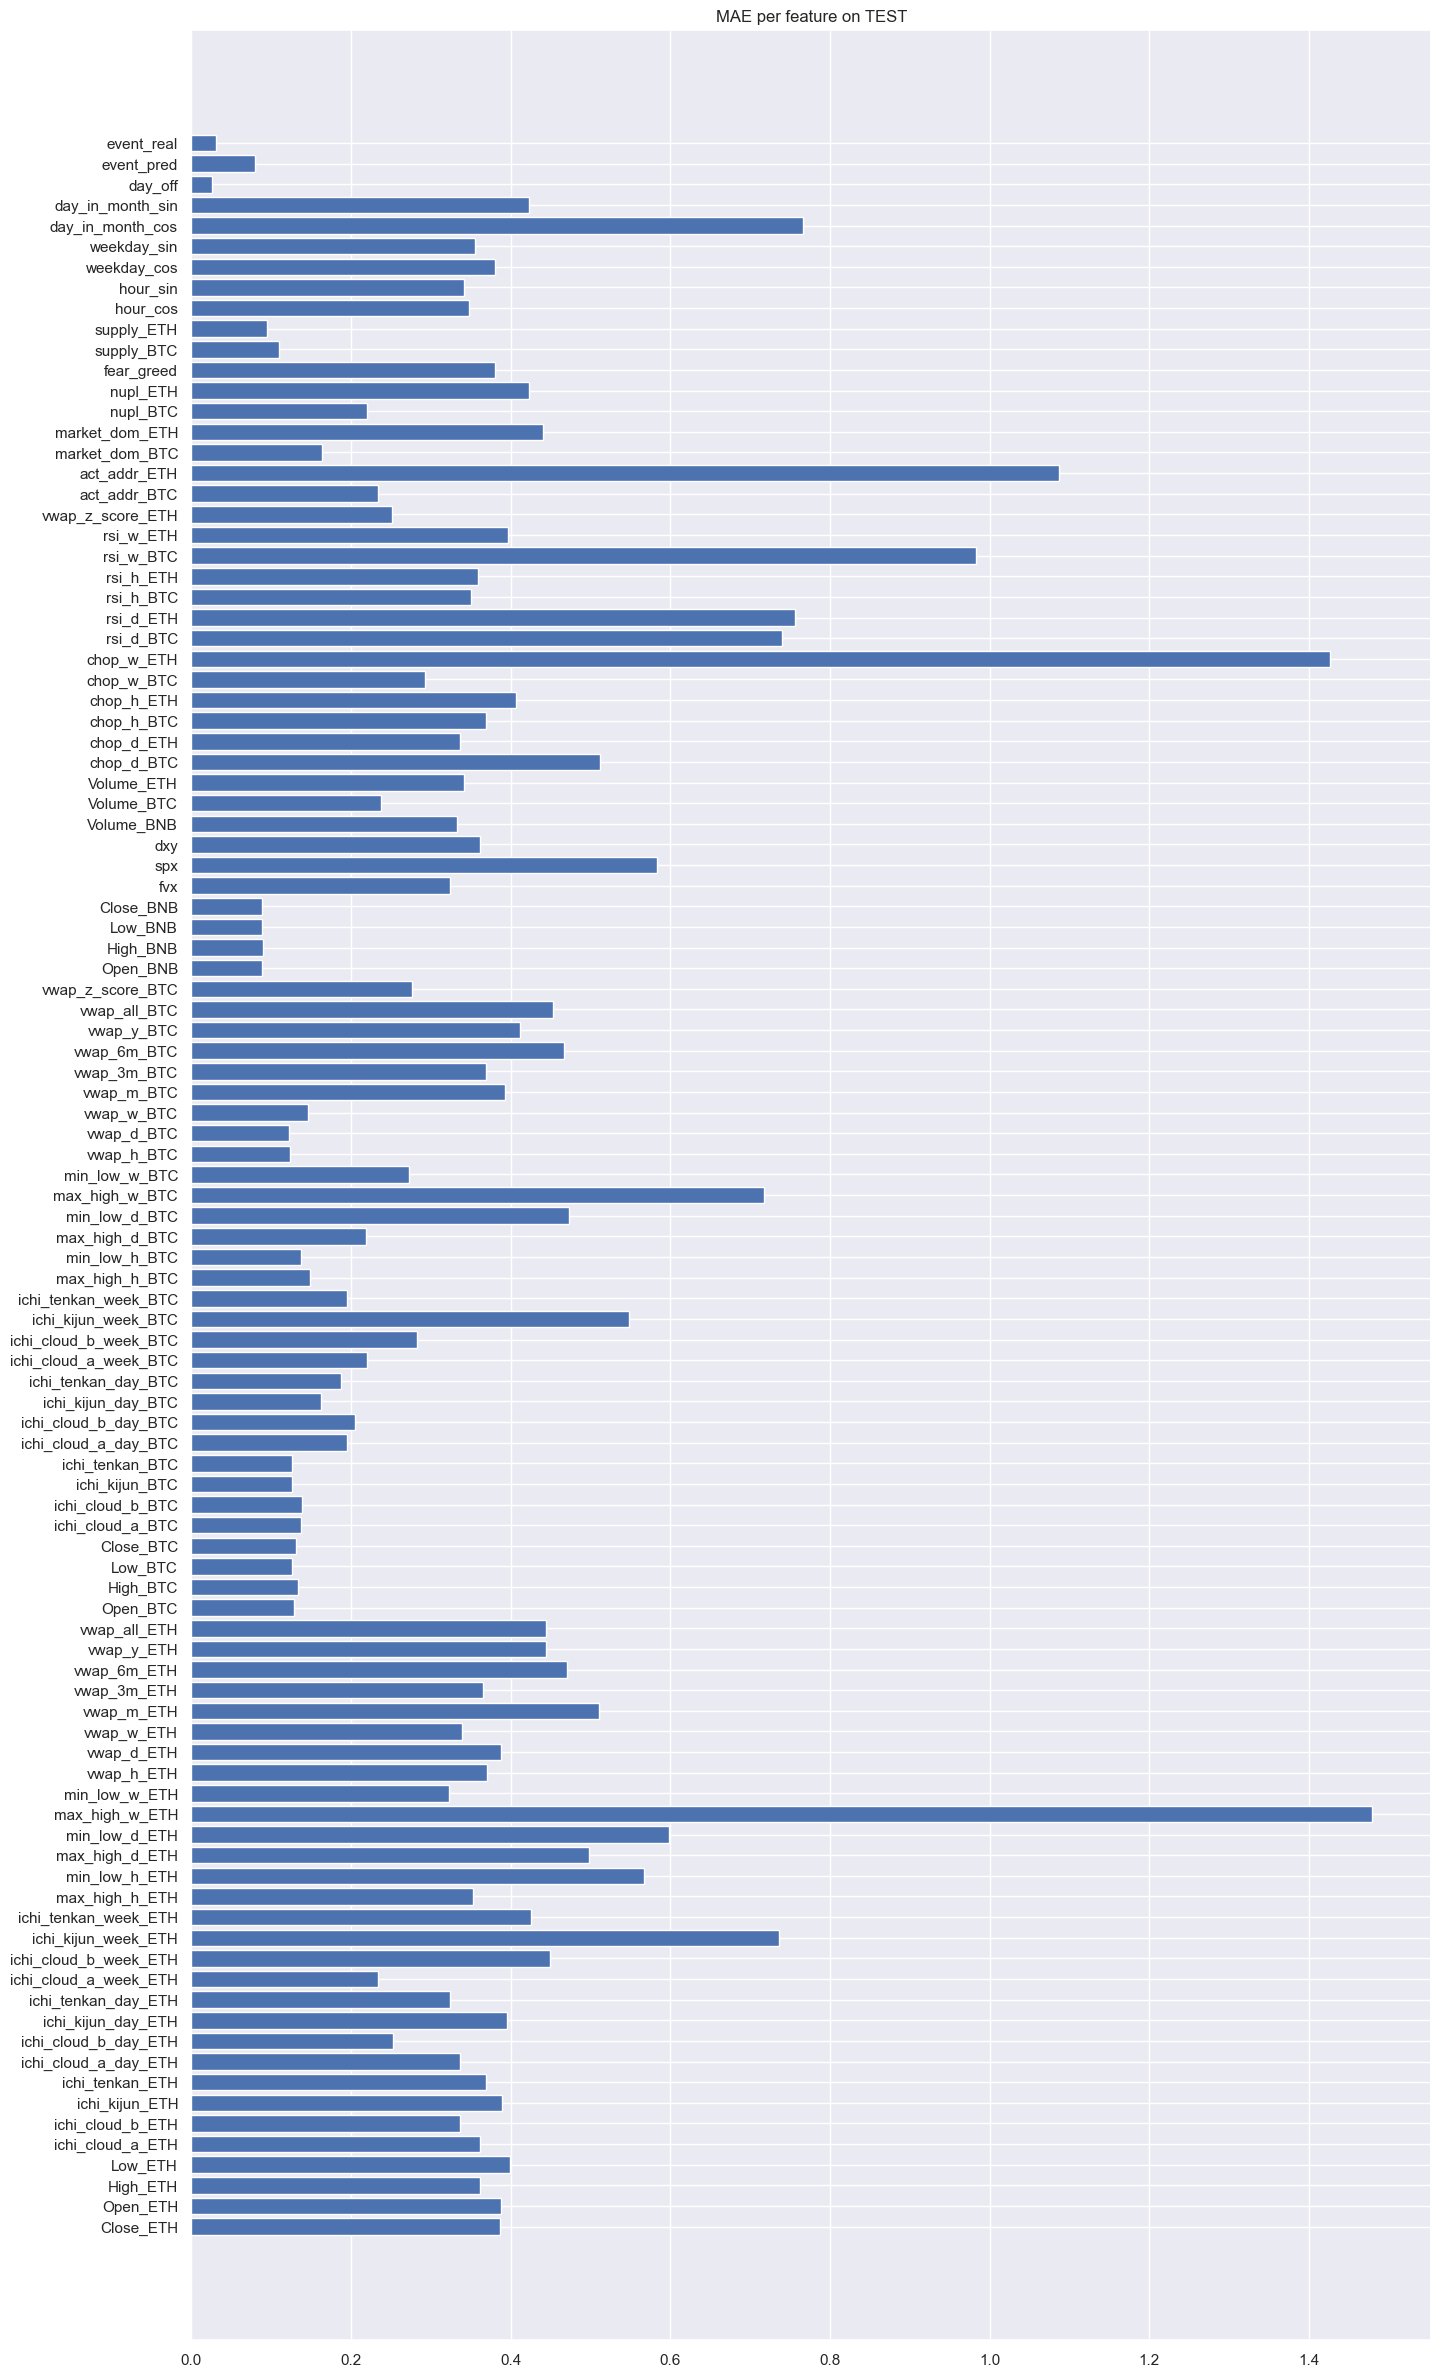

In [118]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_ae_test_feat.columns, df_mae_ae_test_feat.values[0])
plt.title("MAE per feature on TEST")

In [119]:
df_mae_ae_test_feat.values[0]

array([0.3869899 , 0.38750843, 0.36201056, 0.39901325, 0.36132728,
       0.33658922, 0.38868964, 0.3694725 , 0.33656501, 0.25261275,
       0.39521975, 0.32344292, 0.23414138, 0.44875211, 0.73617646,
       0.42595758, 0.35234901, 0.56674884, 0.4979721 , 0.59846283,
       1.47925696, 0.3230972 , 0.37066013, 0.38827753, 0.33919569,
       0.51105936, 0.3656546 , 0.47116134, 0.44411344, 0.44476415,
       0.1291866 , 0.13370774, 0.12667528, 0.13100297, 0.13747023,
       0.13886715, 0.12605668, 0.12558766, 0.19472468, 0.20523115,
       0.16206927, 0.18731191, 0.22004915, 0.28231341, 0.54820549,
       0.19534874, 0.14855084, 0.13766225, 0.21922622, 0.47252141,
       0.71777215, 0.2728319 , 0.12422605, 0.12272791, 0.14642081,
       0.3931071 , 0.36878752, 0.4664139 , 0.41135479, 0.45329557,
       0.27598476, 0.08839521, 0.08926068, 0.08808554, 0.08886553,
       0.32462167, 0.5827909 , 0.36165648, 0.33310156, 0.23789145,
       0.34152404, 0.51155163, 0.33694816, 0.36864019, 0.40711

In [120]:
2/df_mae_ae_test_feat.values[0].sum()

0.054510027405241045

In [121]:
df_comp = df_mae_ae_comp.melt(id_vars=["dataset"], value_vars=list_col_select, value_name="MAE")
df_comp

dataset    variable       MAE
0       TRAIN   Close_ETH  0.198163
1       TRAIN   Close_ETH  0.188152
2       TRAIN   Close_ETH  0.195650
3       TRAIN   Close_ETH  0.196647
4       TRAIN   Close_ETH  0.194338
...       ...         ...       ...
14683    TEST  event_real  0.033291
14684    TEST  event_real  0.037002
14685    TEST  event_real  0.033445
14686    TEST  event_real  0.037518
14687    TEST  event_real  0.033747

[14688 rows x 3 columns]

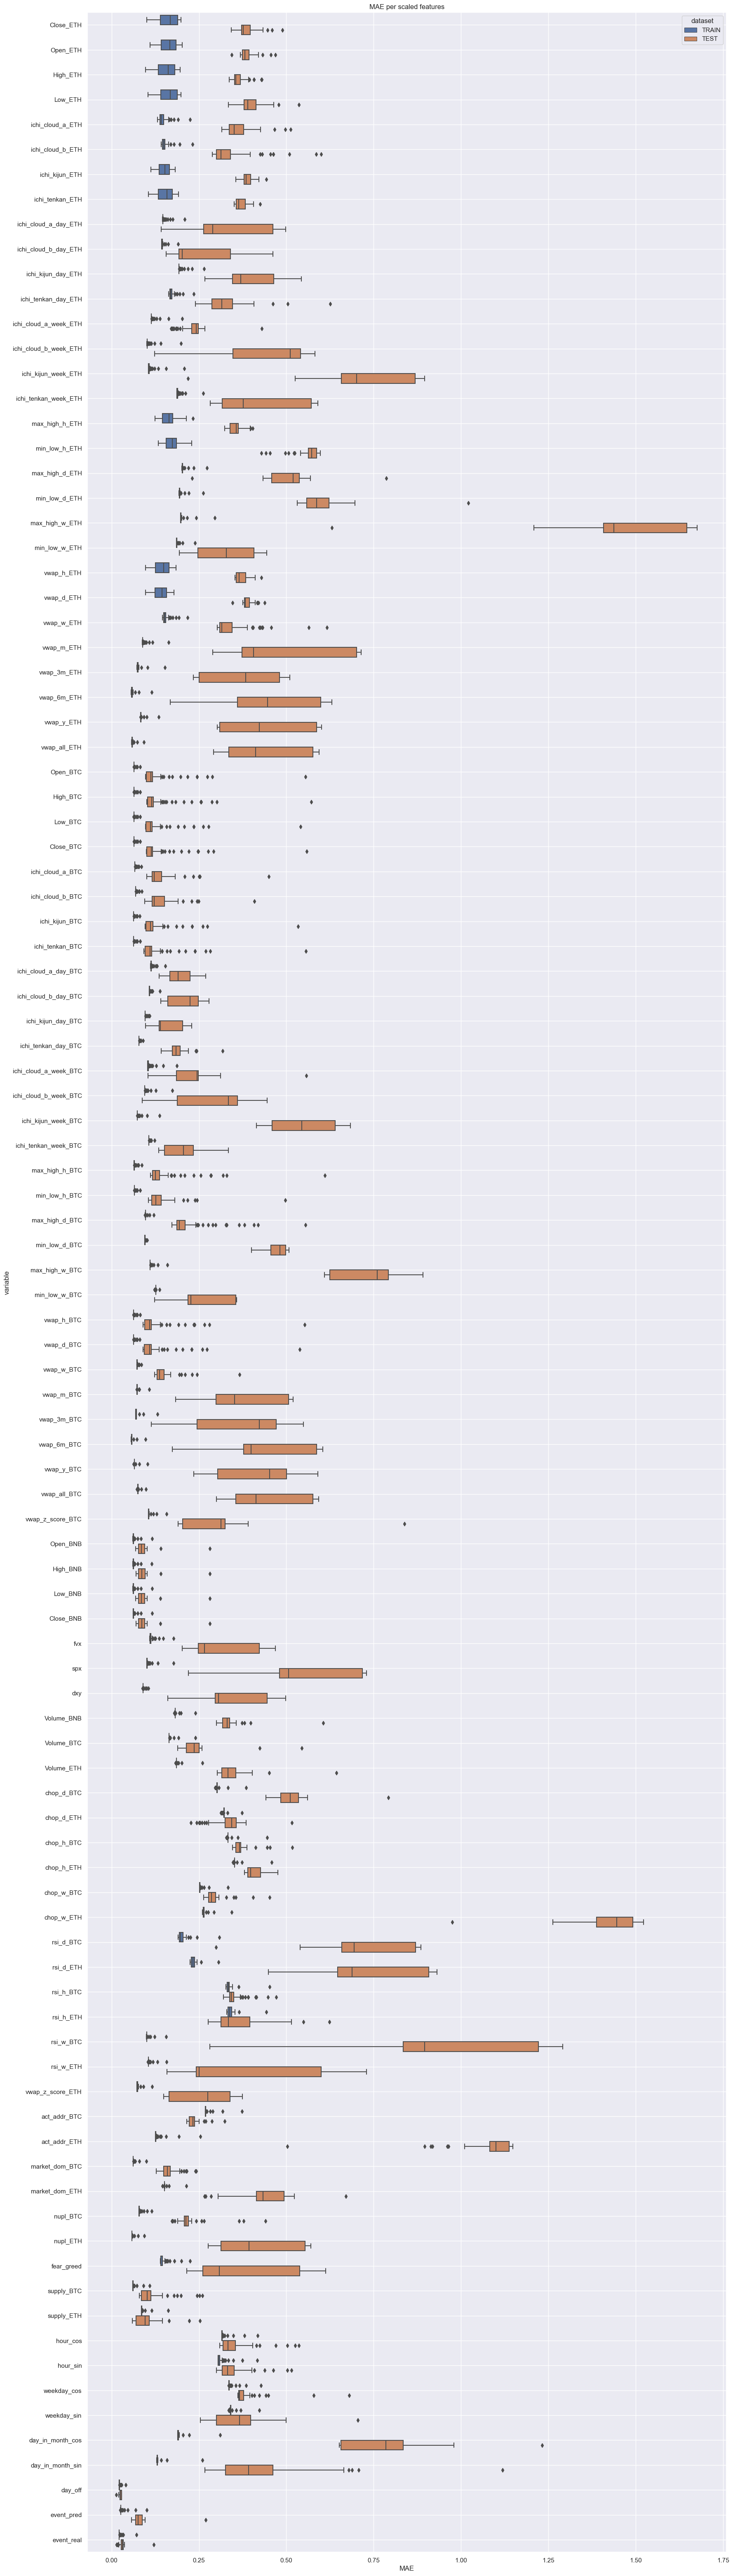

In [122]:
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="MAE", y="variable" , hue="dataset")
fig = plt.gcf()
ax = fig.gca()
ax.yaxis.grid(True)
#ax.set_xlim([-30,30])
plt.title("MAE per scaled features")

name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE_MAE - {name_plt}.jpg")
)

#### MSE  per features

In [123]:
# values per feat.
print(X_train_sca_pred.shape) 
print(X_train_sca.shape)
mse_ae_train = np.mean(np.square(X_train_sca_pred - X_train_sca), 0)
print(mse_ae_train.shape)
df_mse_ae_train = pd.DataFrame(mse_ae_train, columns=list_col_select)
df_mse_ae_train.index = [f"lag_{i_lag}" for i_lag in range(len(df_mse_ae_train.index))]

print(X_test_sca_pred.shape) 
print(X_test_sca.shape)
mse_ae_test = np.mean(np.square(X_test_sca_pred - X_test_sca), 0)
print(mse_ae_test.shape)
df_mse_ae_test = pd.DataFrame(mse_ae_test, columns=list_col_select)
df_mse_ae_test.index = [f"lag_{i_lag}" for i_lag in range(len(df_mse_ae_test.index))]

# mean per feat.
mse_ae_train_feat = np.mean(mse_ae_train, 0)[np.newaxis,:]
print(mse_ae_train_feat.shape)
df_mse_ae_train_feat = pd.DataFrame(mse_ae_train_feat, columns=list_col_select)

mse_ae_test_feat = np.mean(mse_ae_test, 0)[np.newaxis,:]
print(mse_ae_test_feat.shape)
df_mse_ae_test_feat = pd.DataFrame(mse_ae_test_feat, columns=list_col_select)

# comp train/test
df_mse_ae_test["dataset"] = "TEST"
df_mse_ae_train["dataset"] = "TRAIN"
df_mse_ae_comp = pd.concat([df_mse_ae_train, df_mse_ae_test], ignore_index=False)

df_mse_ae_test_feat["dataset"] = "TEST"
df_mse_ae_train_feat["dataset"] = "TRAIN"
df_mse_ae_comp_feat = pd.concat([df_mse_ae_train_feat, df_mse_ae_test_feat], ignore_index=False)

df_mse_ae_comp = df_mse_ae_comp.melt(id_vars=["dataset"], value_vars=list_col_select, value_name="MSE")



(84878, 72, 102)
(84878, 72, 102)
(72, 102)
(770, 72, 102)
(770, 72, 102)
(72, 102)
(1, 102)
(1, 102)


In [124]:
df_mse_ae_comp_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.060384  0.058059  0.055333  0.060005          0.047956   
0   0.244223  0.245652  0.211308  0.259607          0.205930   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.051009        0.048488         0.050687              0.049179   
0          0.177599        0.233078         0.221487              0.215610   

   ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  weekday_cos  weekday_sin  \
0              0.044889  ...  0.126998  0.120922     0.142560     0.148277   
0              0.121306  ...  0.160994  0.156357     0.187752     0.188258   

   day_in_month_cos  day_in_month_sin   day_off  event_pred  event_real  \
0          0.064475          0.028113  0.060977    0.006029    0.008730   
0          0.652146          0.212058  0.000787    0.011036    0.001632   

   dataset  
0    TRAIN  
0     TEST  

[2 rows x 103 columns]

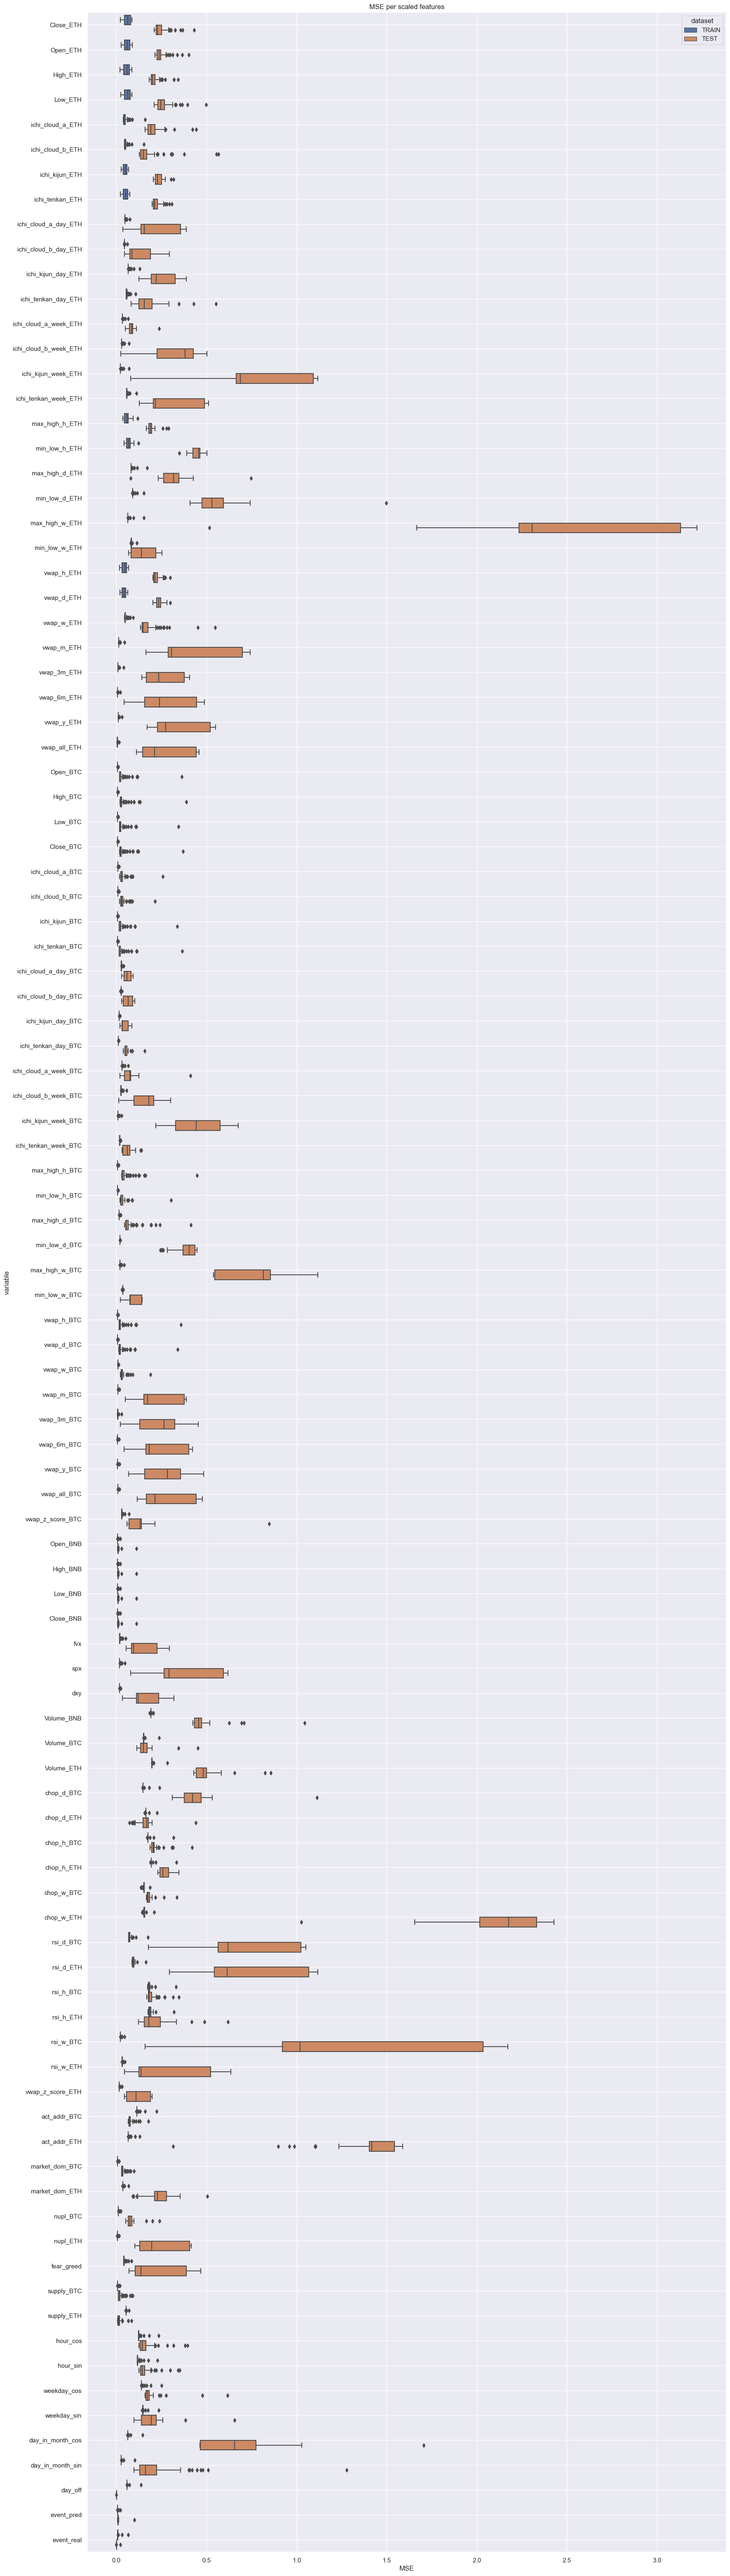

In [125]:
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_mse_ae_comp, x="MSE", y="variable" , hue="dataset")
fig = plt.gcf()
ax = fig.gca()
ax.yaxis.grid(True)
#ax.set_xlim([-30,30])
plt.title("MSE per scaled features")

name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE_MSE - {name_plt}.jpg")
)

Text(0.5, 1.0, 'MSE per feature on TRAIN')

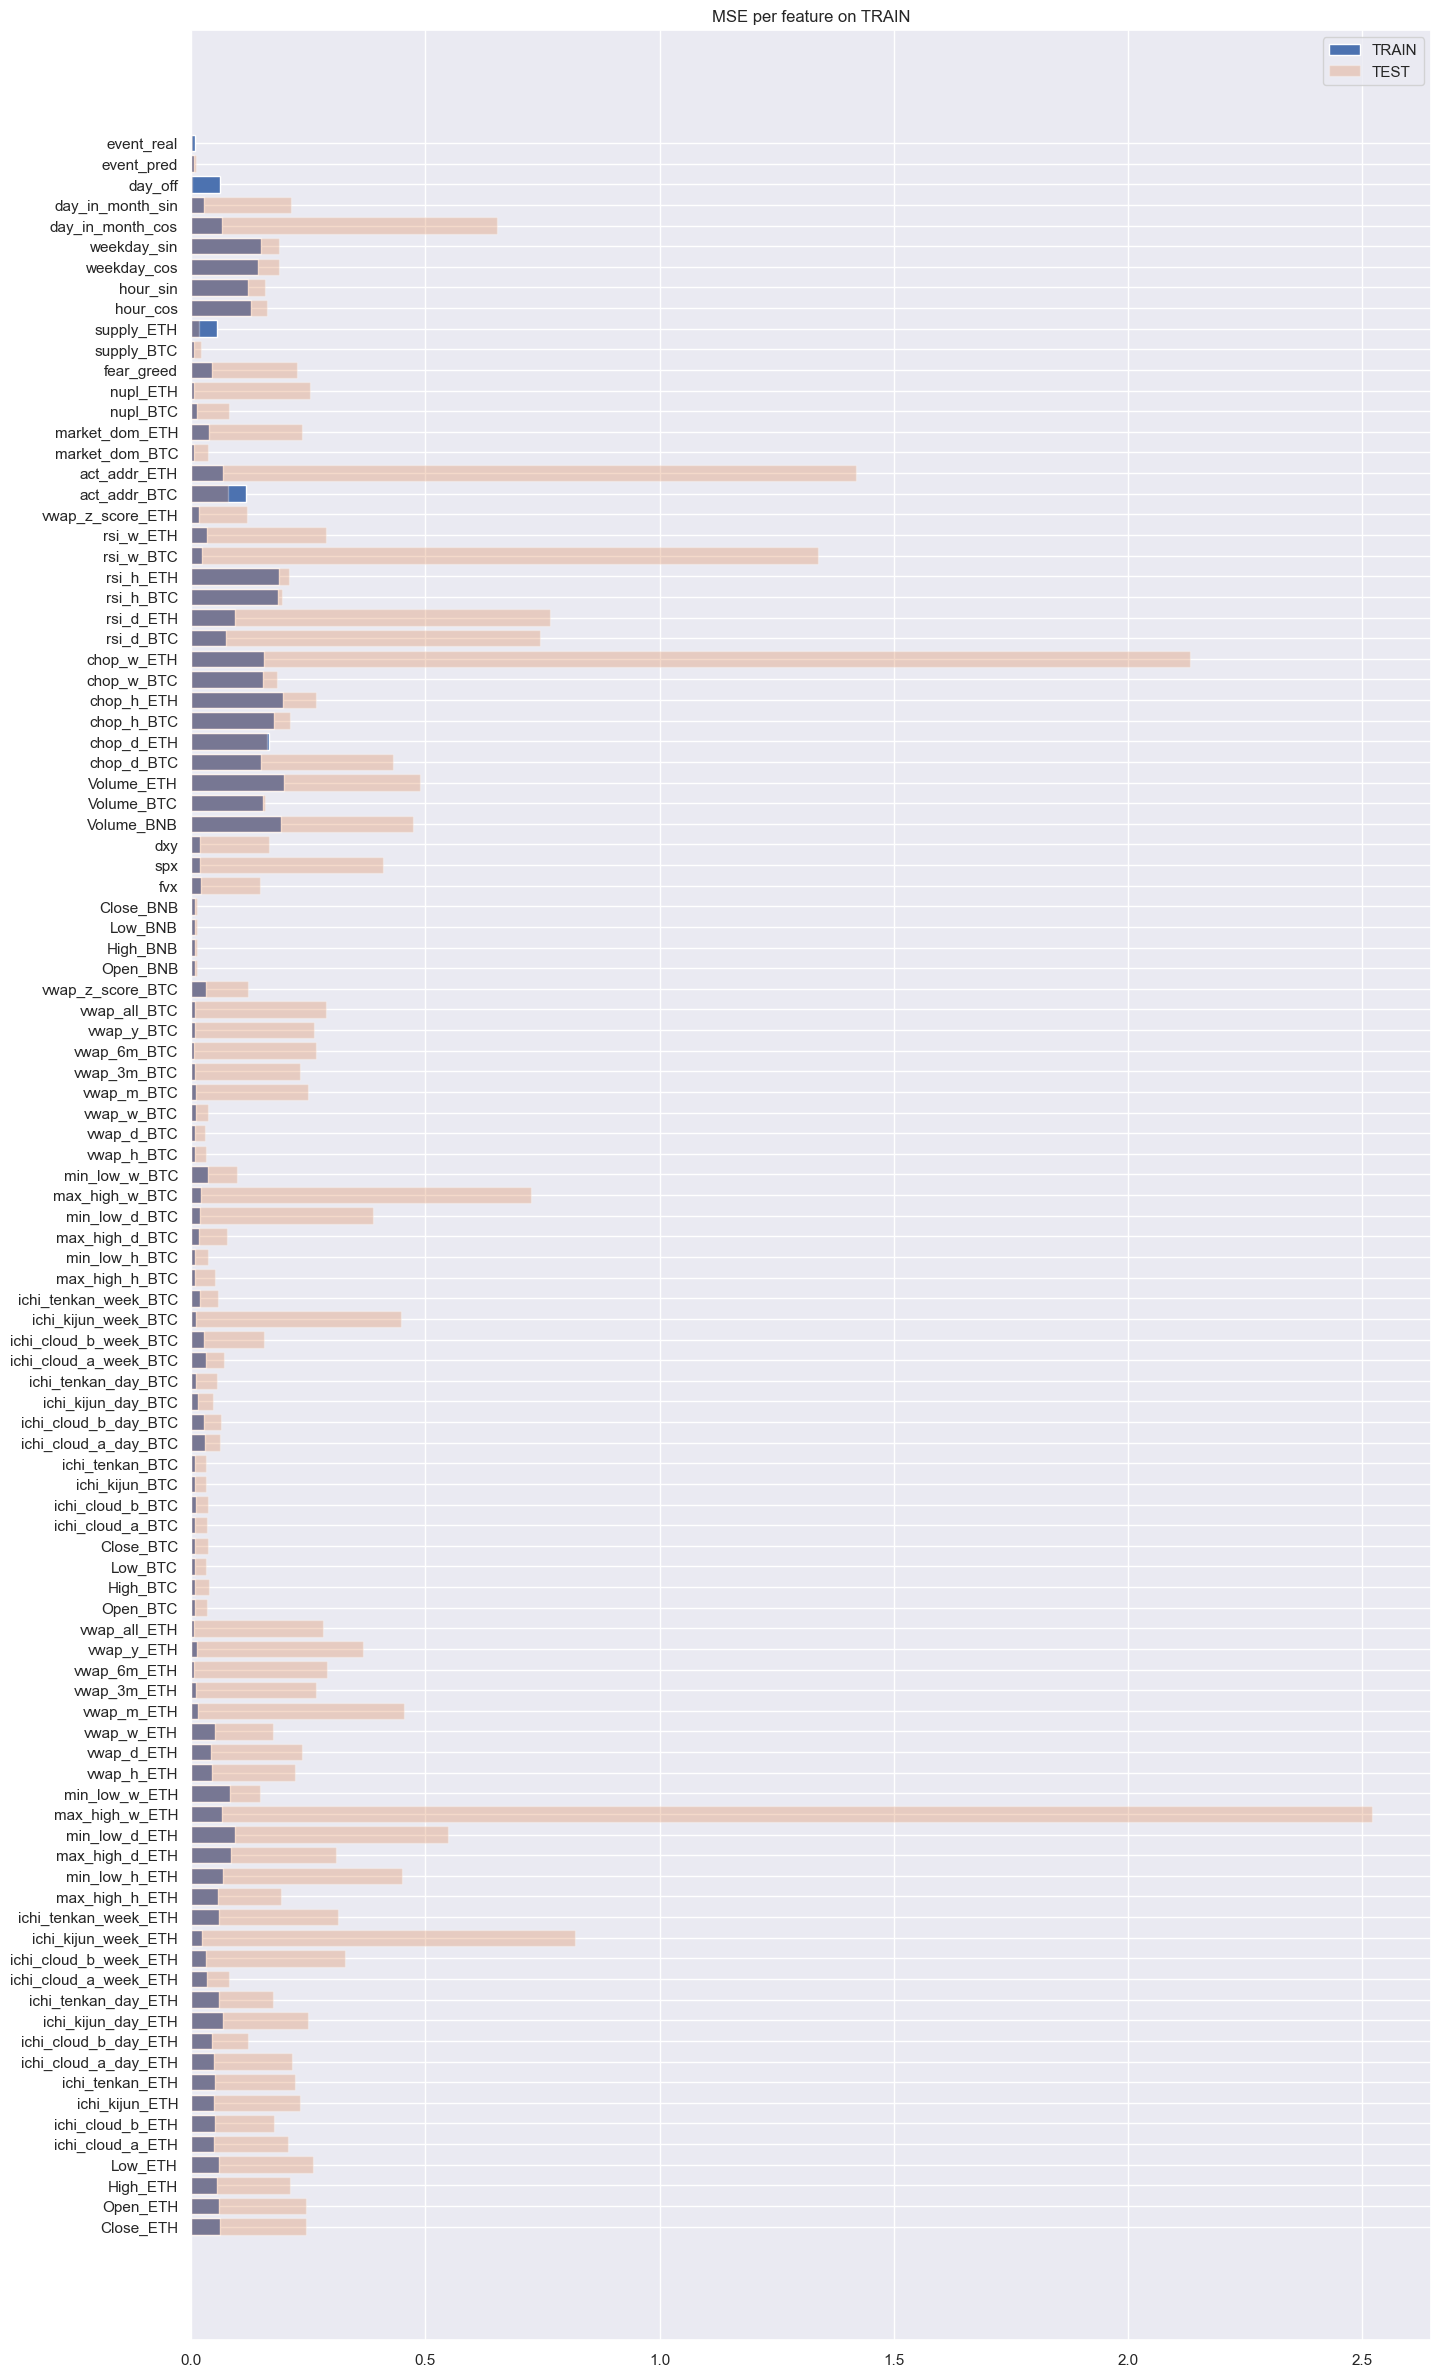

In [126]:
plt.figure(figsize=(16, 30))
plt.barh(list_col_select, df_mse_ae_train_feat.values[0,:-1], label="TRAIN")
plt.barh(list_col_select, df_mse_ae_test_feat.values[0,:-1], label="TEST", alpha=0.3)
plt.legend(loc='upper right')
#plt.barh(df_mse_ae_test_feat.columns, df_mse_ae_test_feat.values[0])
plt.title("MSE per feature on TRAIN")

In [127]:
encoder_model.layers[3].get_weights()

[array([[ 0.40565744,  0.20940717, -0.0124934 , ...,  0.37625152,
         -0.2535546 ,  0.20702814],
        [-0.51308423, -0.00992074, -0.25232735, ..., -0.06986912,
          0.0970002 , -0.32120755],
        [ 0.0959057 , -0.06163099,  0.25679415, ...,  0.25501606,
         -0.07564641, -0.34137082],
        ...,
        [-0.0045608 ,  0.03577103, -0.08584972, ...,  0.1431808 ,
          0.00106979, -0.01074271],
        [-0.2848426 , -0.27251443, -0.17855503, ..., -0.64492154,
          0.92562336,  0.07243153],
        [-0.5309976 ,  0.27139458, -0.23918667, ...,  0.26812407,
          0.78054297, -0.37104106]], dtype=float32),
 array([ 0.24692242,  0.06026156, -0.07360088, -0.4596111 ,  0.12127468,
        -0.22765963,  0.55604905,  0.38311577, -0.08017755,  0.0464628 ,
         0.12751353, -0.13582693,  0.09677448,  0.1962485 ,  0.20190136,
        -0.3703293 ,  0.21293153, -0.38452485, -0.15918086, -0.09637537,
         0.12144352,  0.07699045,  0.18661672,  0.15141925, -0.153

## Prediction Models

### LSTM all features

In [128]:
X_train_sca.shape

(84878, 72, 102)

In [129]:
X_train_sca.shape[-1]

102

In [130]:
X_train_sca.shape[-2:]

(72, 102)

In [131]:
# Init
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
if MODE_TRAIN_LSTM:
    EPOCHS = 5
    patience = 0
    dropout_rate = 0.05
    n_units = 128
    seed = 0
    tf.keras.backend.clear_session()
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    # optimizer def 
    optim = tf.optimizers.Adam()

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                    verbose=1, patience=patience,
                                    restore_best_weights=True)
    # create model
    multi_step_model_1 = tf.keras.models.Sequential()
    multi_step_model_1.add(tf.keras.layers.LSTM(n_units, 
                        return_sequences=False,
                        input_shape=X_train_sca.shape[-2:],
                        dropout=dropout_rate))
    multi_step_model_1.add(tf.keras.layers.LayerNormalization())
    multi_step_model_1.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
    # compile
    multi_step_model_1.compile(optimizer=optim, loss='mse')
    # fitting
    if patience == 0:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1
        )
    else:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1, callbacks=[es])

    # eval
    mse_curr_1 = np.min(multi_step_history_1.history['val_loss'])
    print("mse_curr_1 = ", mse_curr_1)
    # plot mse
    plot_train_history(multi_step_history_1,
                        'Multi Step Training and validation loss', "data")
    # save mdl
    multi_step_model_1.save(path_mdl_predict_lstm)
    # results
    # _train_sca -> unscaler -> _train -> multiply by  Close price last lag
    y_train_pred_1 = multi_step_model_1.predict(X_train_sca)
    y_train_pred_unscaled_1 = scaler_y.inverse_transform(y_train_pred_1.reshape(-1,y_train_pred_1.shape[-1])).reshape(y_train_pred_1.shape)
    y_train_pred_raw_1 = y_train_pred_unscaled_1 * X_train_raw[:,-1, 0][:, np.newaxis]

    y_test_pred_1 = multi_step_model_1.predict(X_test_sca)
    y_test_pred_unscaled_1 = scaler_y.inverse_transform(y_test_pred_1.reshape(-1,y_test_pred_1.shape[-1])).reshape(y_test_pred_1.shape)
    y_test_pred_raw_1 = y_test_pred_unscaled_1 * X_test_raw[:,-1, 0][:, np.newaxis]
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TRAIN data : Close Price at 6th lag")
    plt.plot(y_train_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_train_raw[:1000, 5], label="TRAIN")
    plt.legend(loc='upper right')
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TEST data : Close Price at 6th lag")
    plt.plot(y_test_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_test_raw[:1000, 5], label="TEST")
    plt.legend(loc='upper right')


### Autoencoder + LSTM reduced features

In [132]:
encoder_model = tf.keras.models.load_model(path_mdl_encoder)
encoder_model.layers

Concatenate 

In [133]:
X_train_encoded = encoder_model.predict(X_train_sca)
X_train_encoded.shape

2653/2653 [==============================] - 31s 12ms/step


(84878, 72, 32)

In [134]:
X_test_encoded = encoder_model.predict(X_test_sca)
X_test_encoded.shape

25/25 [==============================] - 0s 16ms/step


(770, 72, 32)

In [135]:
if MODE_TRAIN_AE:
    scaler_enc = StandardScaler()
    X_train_encoded_sca = scaler_enc.fit_transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)

    joblib.dump(scaler_enc, path_scaler_enc)
    
else:
    print("reloading scaler_enc...")
    scaler_enc = joblib.load(path_scaler_enc)
    X_train_encoded_sca = scaler_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)    



reloading scaler_enc...


In [136]:
"""path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")
joblib.dump(scaler_enc, path_scaler_enc)
sc_enc = joblib.load(path_scaler_enc)
sc_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)"""

'path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")\njoblib.dump(scaler_enc, path_scaler_enc)\nsc_enc = joblib.load(path_scaler_enc)\nsc_enc.transform(\n        X_train_encoded.reshape(\n            -1, \n            X_train_encoded.shape[-1]\n        )\n    ).reshape(X_train_encoded.shape)'

In [137]:
"""# scale encoded data
scaler_enc = StandardScaler()
X_train_encoded_sca = scaler_enc.fit_transform(
    X_train_encoded.reshape(
        -1, 
        X_train_encoded.shape[-1]
    )
).reshape(X_train_encoded.shape)

X_test_encoded_sca = scaler_enc.transform(
    X_test_encoded.reshape(
        -1, 
        X_test_encoded.shape[-1]
    )
).reshape(X_test_encoded.shape)"""

'# scale encoded data\nscaler_enc = StandardScaler()\nX_train_encoded_sca = scaler_enc.fit_transform(\n    X_train_encoded.reshape(\n        -1, \n        X_train_encoded.shape[-1]\n    )\n).reshape(X_train_encoded.shape)\n\nX_test_encoded_sca = scaler_enc.transform(\n    X_test_encoded.reshape(\n        -1, \n        X_test_encoded.shape[-1]\n    )\n).reshape(X_test_encoded.shape)'

In [138]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
X_train_ = np.concatenate([X_train_sca[:,:,0:4], X_train_encoded_sca], axis=-1)
X_test_ = np.concatenate([X_test_sca[:,:,0:4], X_test_encoded_sca], axis=-1)

X_train_.shape, X_test_.shape

((84878, 72, 36), (770, 72, 36))

#### Correlations

In [139]:
list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

list_corr = []
for i_lag in range(X_train_.shape[1]):

    df = pd.DataFrame(np.hstack((X_train_[:,i_lag,:], y_train)), 
        columns=list_col_corr)
    # Calculer la matrice de corrélation
    corr_matrix = df.corr()
    if len(list_corr) > 0:
        corr_matrix_min = list_corr[-1].combine(corr_matrix, np.minimum)
        corr_matrix_max = list_corr[-1].combine(corr_matrix, np.maximum)
    
    list_corr.append(corr_matrix)



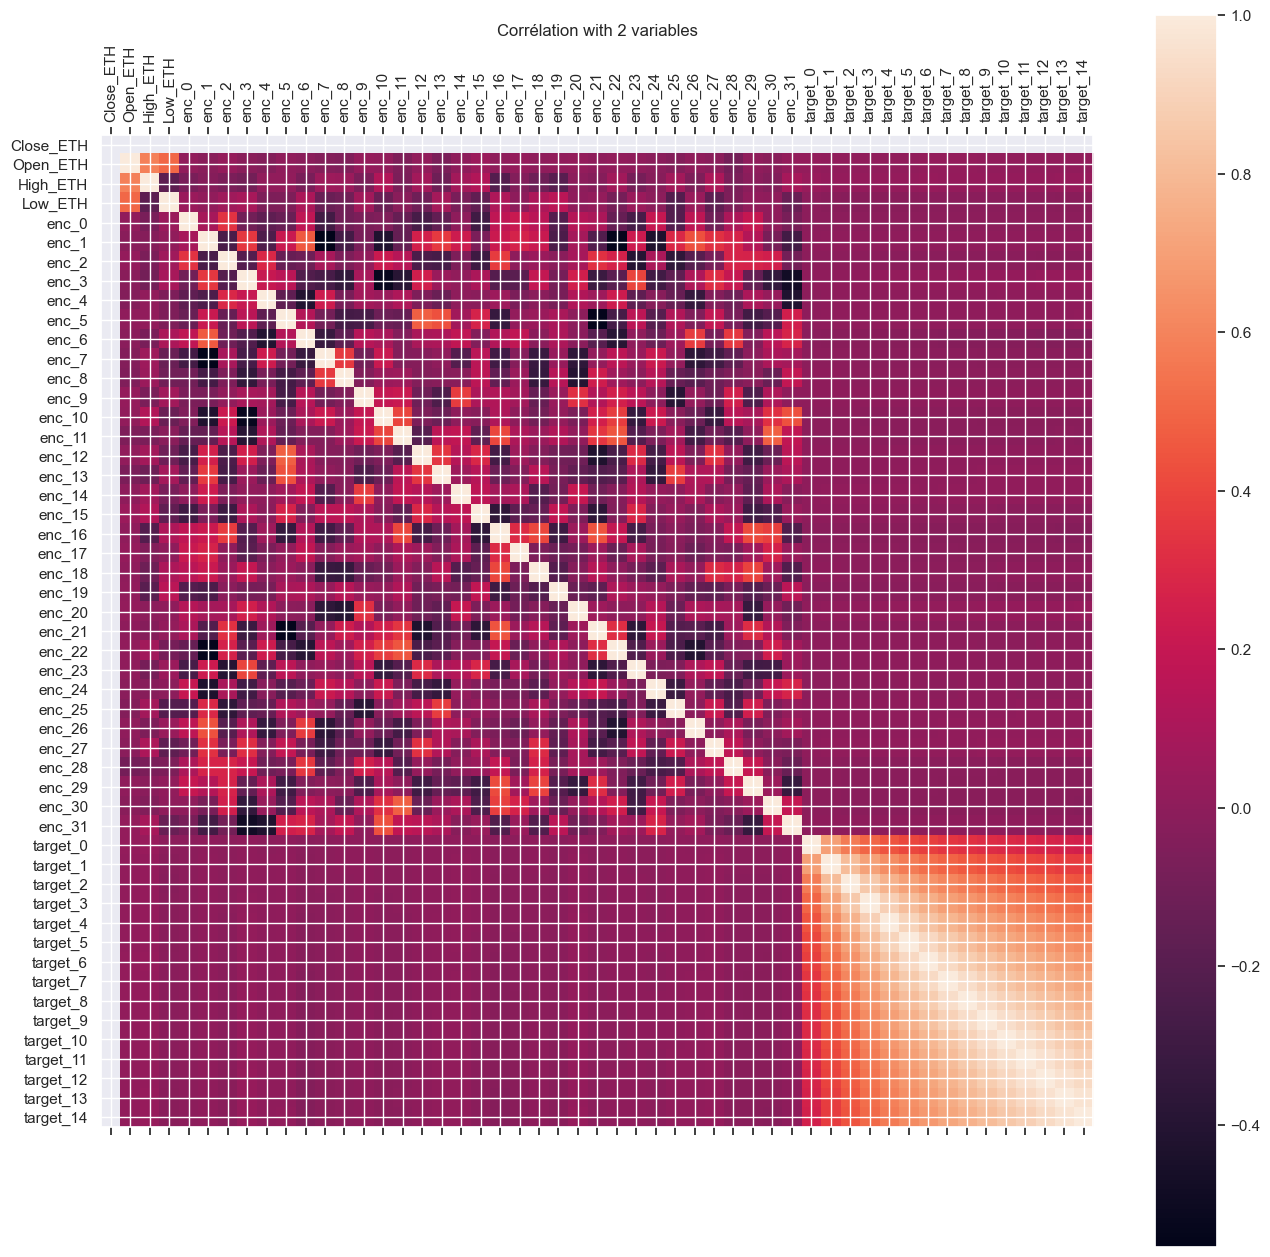

In [140]:
fig = plot_corr(corr_matrix_min)

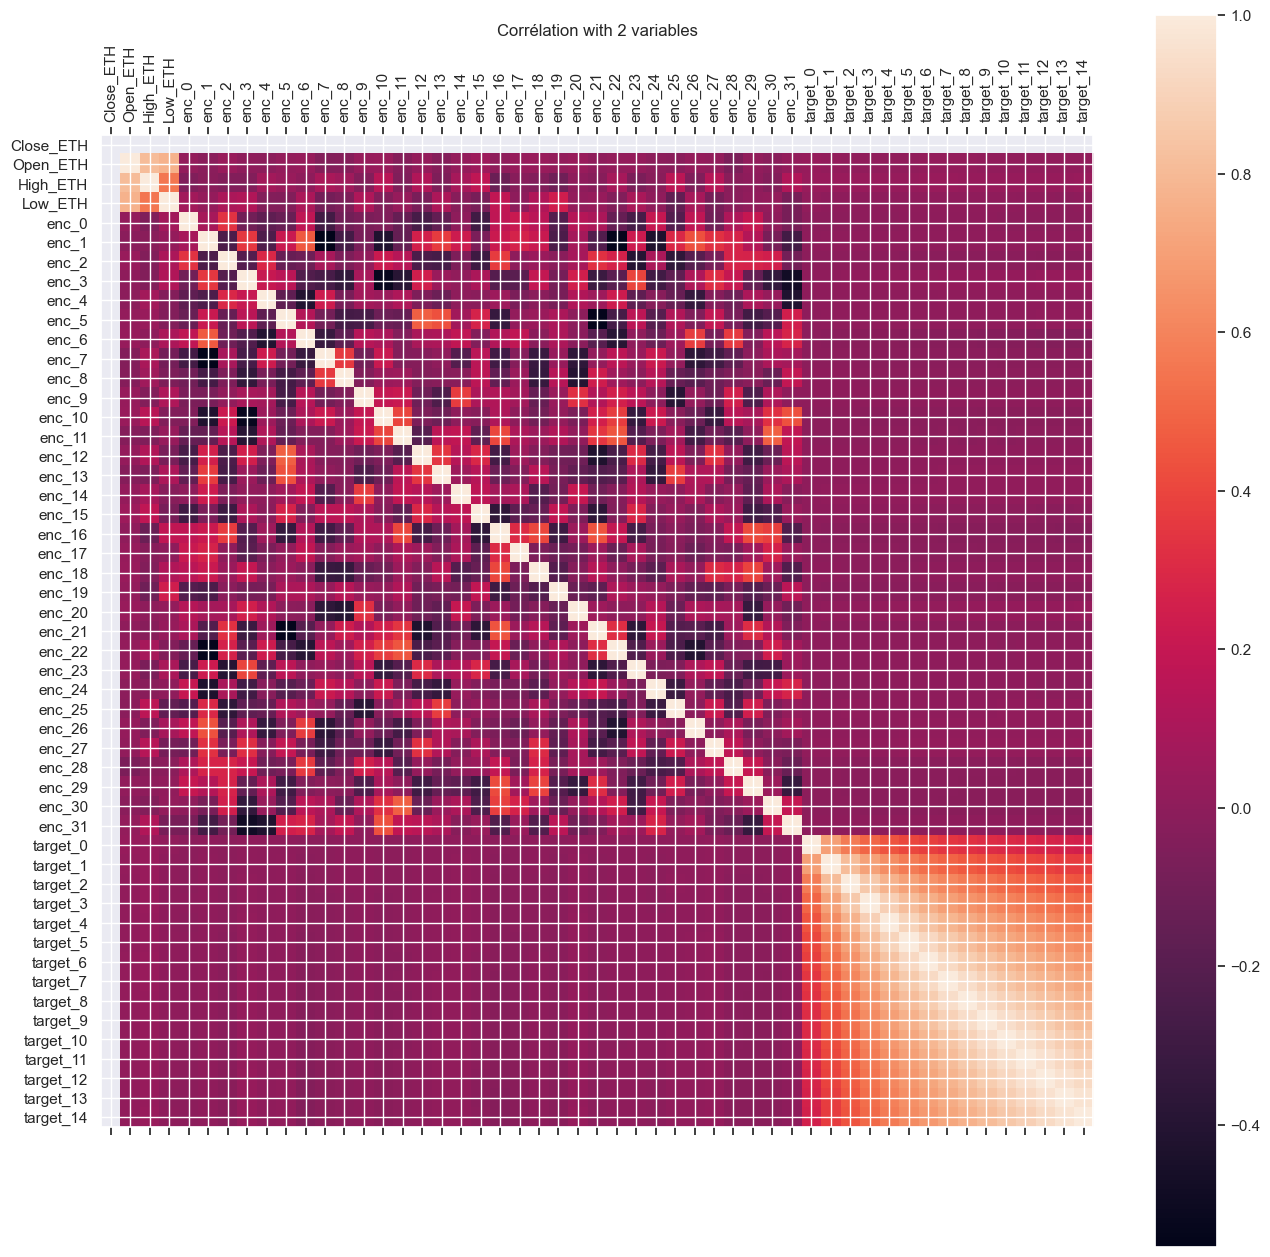

In [141]:
fig = plot_corr(corr_matrix_max) 

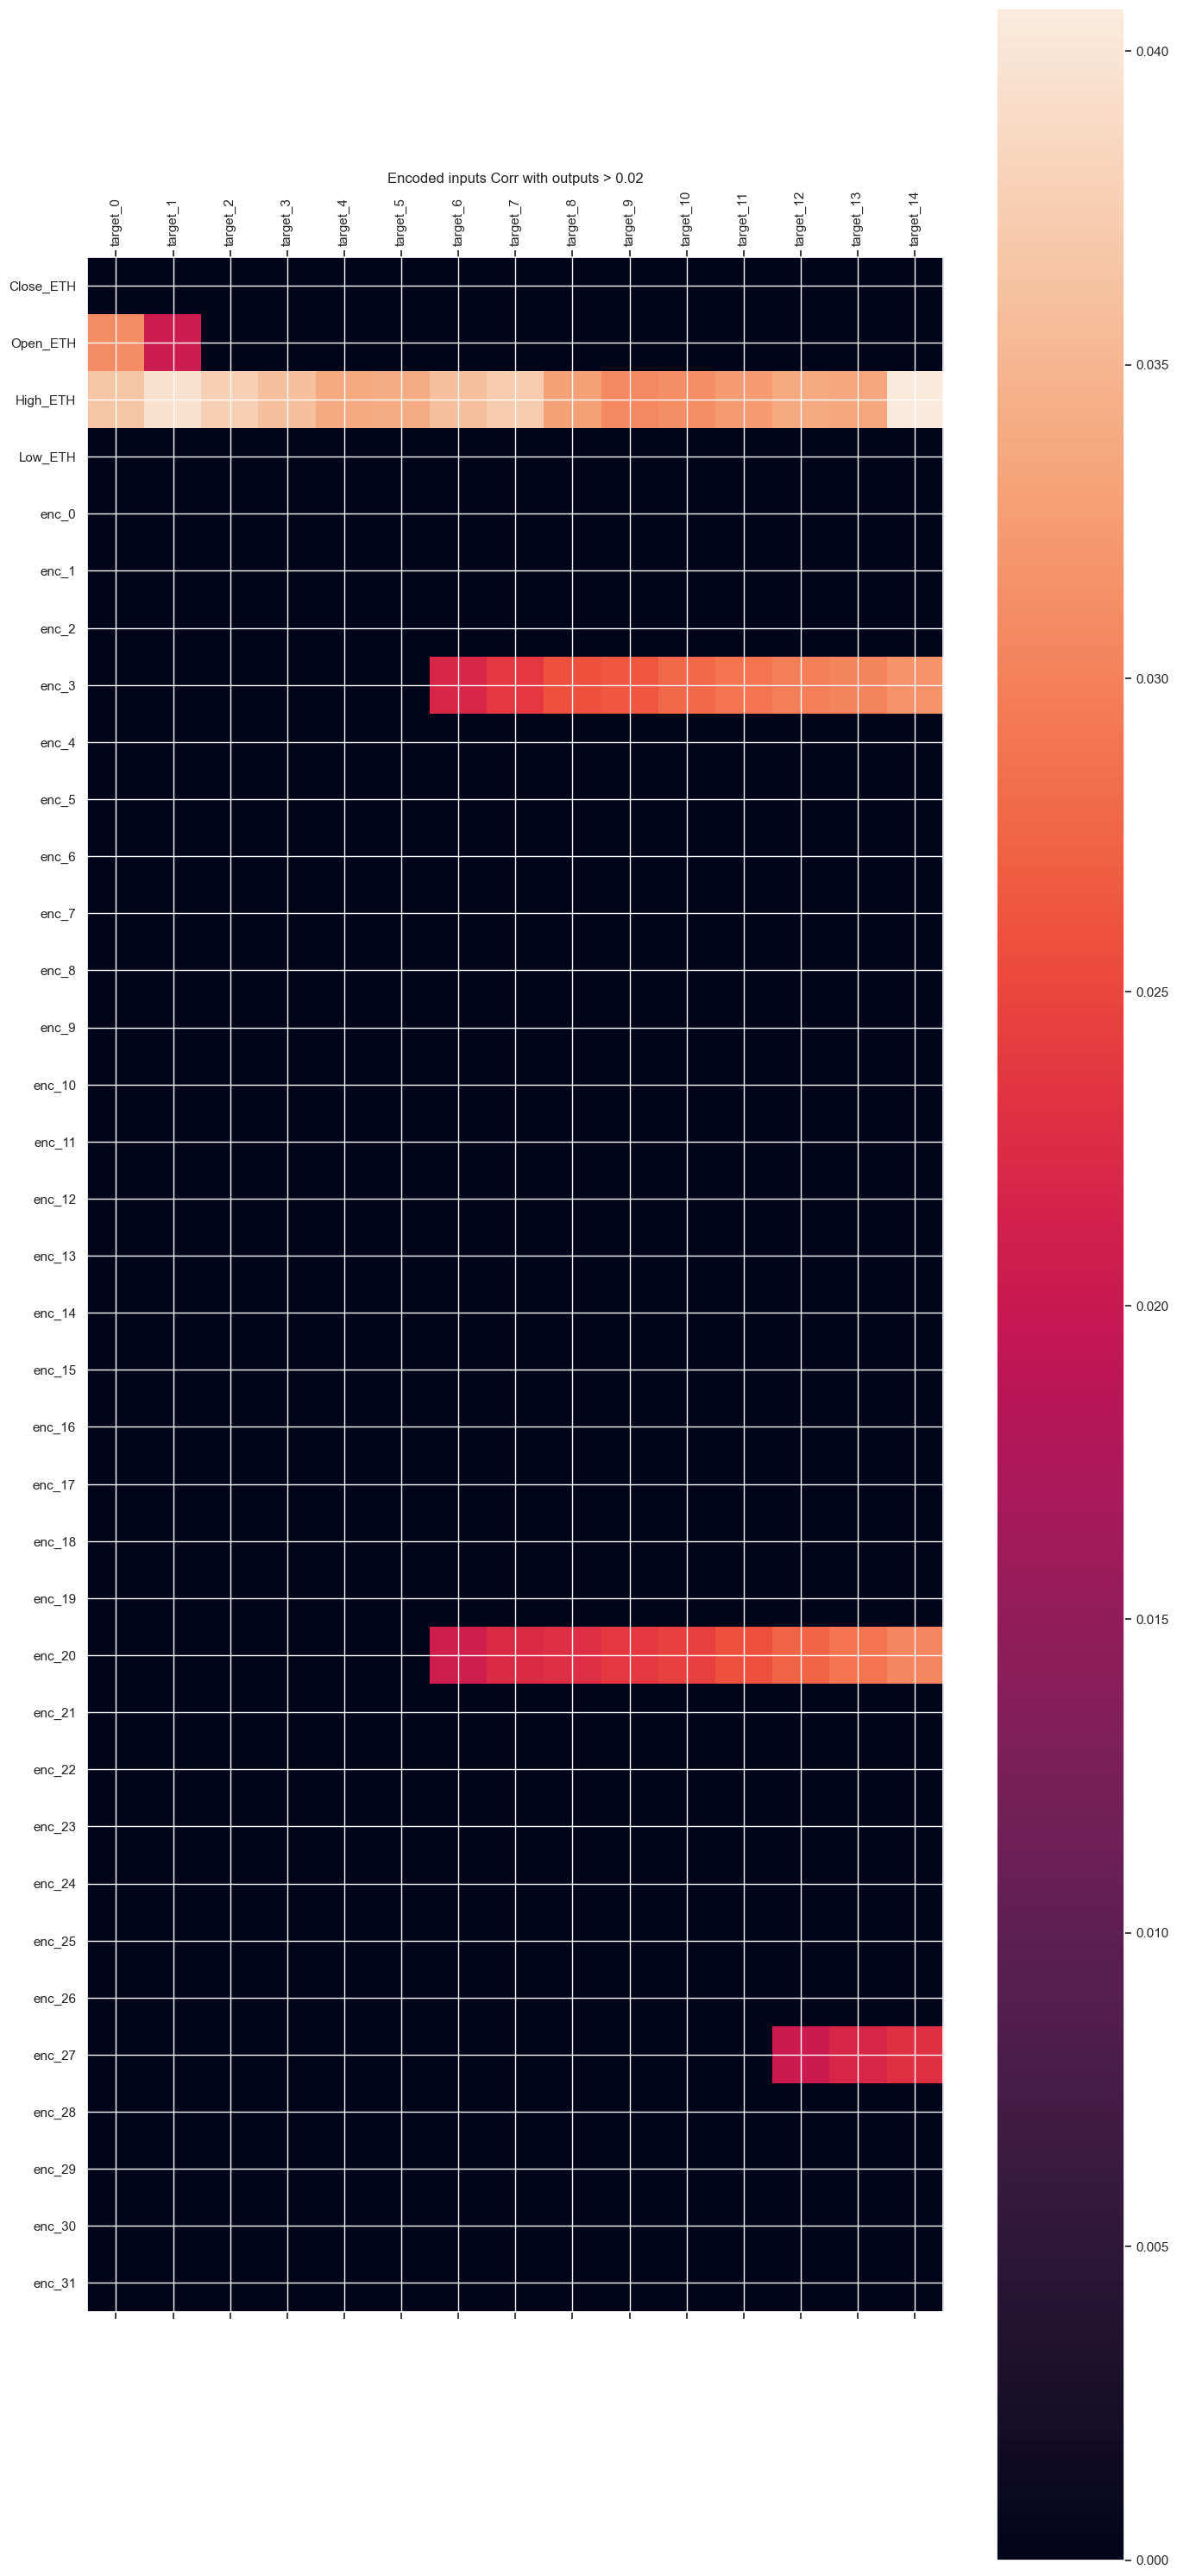

In [142]:
corr_matrix_targets_max = corr_matrix_max.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_max.where(corr_matrix_targets_max>0.02, 0), "Encoded inputs Corr with outputs > 0.02")

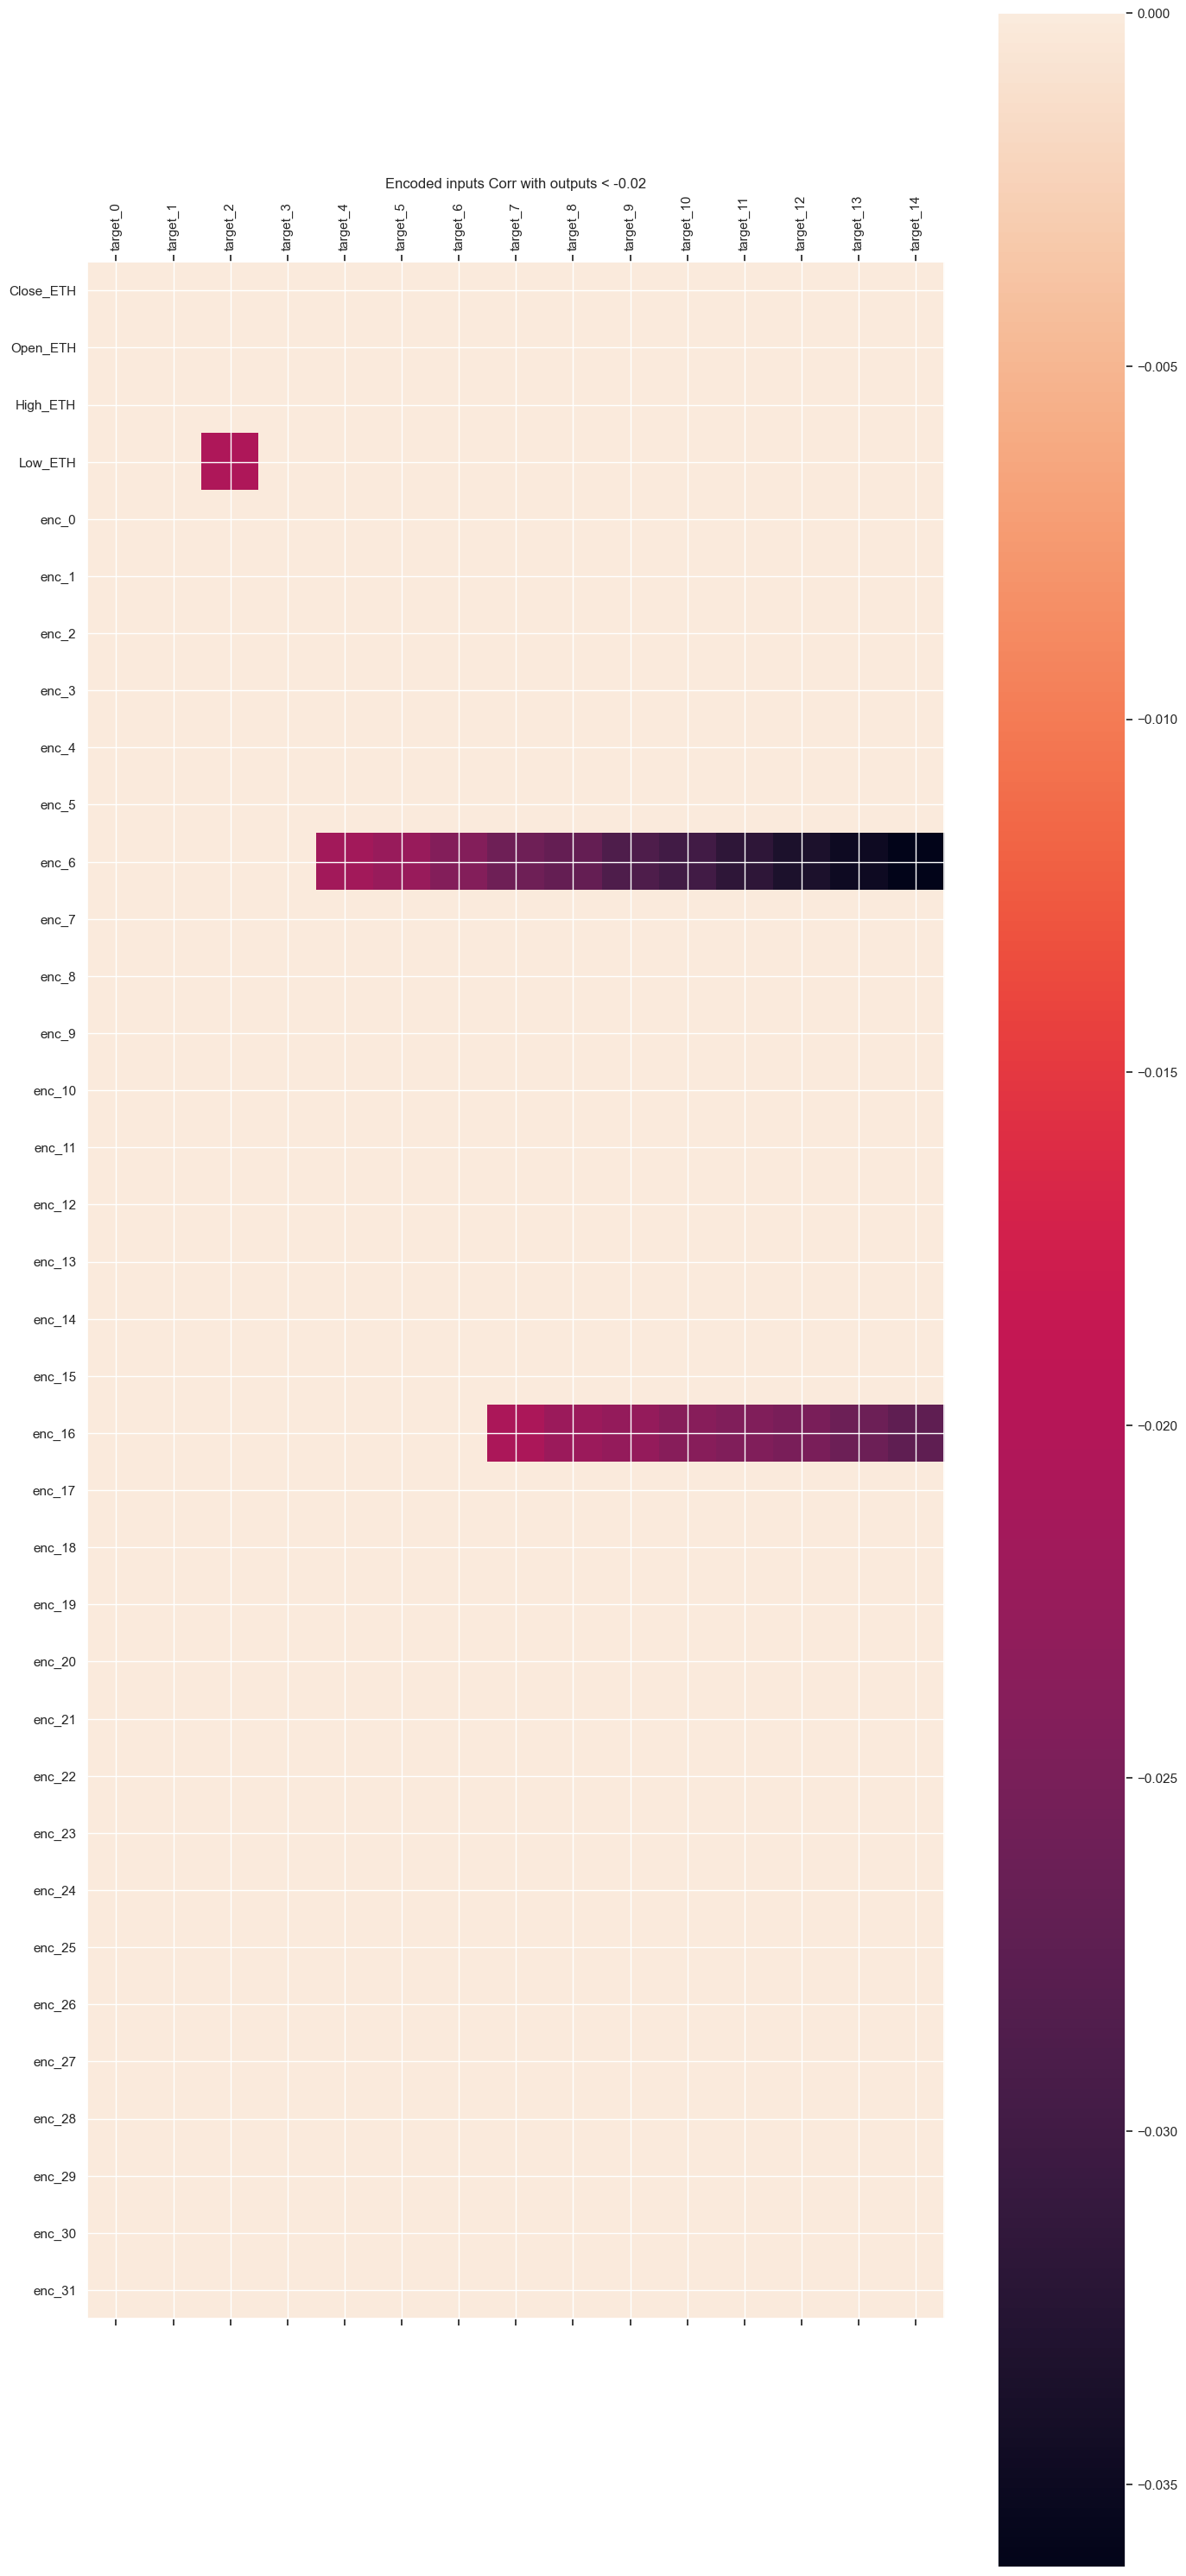

In [143]:
corr_matrix_targets_min = corr_matrix_min.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_min.where(corr_matrix_targets_min < -0.02, 0), "Encoded inputs Corr with outputs < -0.02")

In [144]:
"""list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)"""

'list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]\nlist_col_ae = list_col_select[:4] + list_col_enc\nnb_plot = len(list_col_ae)\nlist_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]\nlist_col_corr = list_col_ae + list_col_targets\n\n# Créer un DataFrame pandas à partir des données d\'entrée X et de la variable à prédire y\n#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), \n#    columns=list_col_select[:nb_plot] + [\'target\'])\ndf = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), \n    columns=list_col_corr)\n# Calculer la matrice de corrélation\ncorr_matrix = df.corr()\n\nfig = plot_corr(corr_matrix)'

In [145]:
"""corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")"""


'corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]\nfig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")'

In [146]:
"""fig = plot_corr(
    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),
    "Encoded inputs Corr with outputs < -0.02",
)"""

'fig = plot_corr(\n    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),\n    "Encoded inputs Corr with outputs < -0.02",\n)'

#### Auto select features 

In [147]:
MODE_AUTO_SELECT

0

In [148]:
# select corr var [1, 2, 5, 7, 10, 11, 16, 19, 23, 24, 27, 28, 31]
def unique_list(list1):
    x = np.array(list1)
    return list(np.unique(x))

if MODE_AUTO_SELECT == 1:
    #list_col_enc_select = []
    list_i_enc_select = []
    for i_enc , col_enc in enumerate(list_col_enc):
        if (np.any(corr_matrix_targets_min.loc[col_enc].values <  -0.02) |
            np.any(corr_matrix_targets_max.loc[col_enc].values >  0.02)
            ):
            #list_col_enc_select.append(col_enc)
            list_i_enc_select.append(i_enc)
    list_i_enc_select = unique_list(list_i_enc_select)
    # save list
    save_list(list_i_enc_select, path_save_auto_select)

elif MODE_AUTO_SELECT == 2:
    list_i_enc_select = load_list(path_save_auto_select)
else:
    list_i_enc_select = list(range(X_train_encoded_sca.shape[-1]))


print(list_i_enc_select)
print("nb encoded features: ", len(list_i_enc_select))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
nb encoded features:  32


In [149]:
X_train_.shape

(84878, 72, 36)

In [150]:
np.array(list(range(4)) + list(4+ np.array(list_i_enc_select)))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

In [151]:
X_train_ = X_train_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]
X_test_ = X_test_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]

In [152]:
X_train_.shape

(84878, 72, 36)

#### Train

In [153]:
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
EPOCHS = 800#30
patience = 0#10
#dropout_rate = 0.25#0.1
#n_units = 128#32
#reg = L1L2(l1=0.0001, l2=0.0001)

mse_curr_min = None
if MODE_TRAIN_PREDICTOR:
    for n_units in [128]: #[32, 64, 128]: #[128]: #
        for dropout_rate in  [0.25]: #[0.05, 0.15, 0.25]: #[0.1]:
            for seed in LIST_SEEDS:
                tf.keras.backend.clear_session()
                np.random.seed(seed)
                random.seed(seed)
                tf.random.set_seed(seed)
                optim = tf.keras.optimizers.legacy.Adam()
                #optim = tf.keras.optimizers.AdamW()
                if patience is not None:
                    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                                    verbose=1, patience=patience,
                                                    restore_best_weights=True)
                # create model
                multi_step_model = tf.keras.models.Sequential()
                multi_step_model.add(
                    tf.keras.layers.LSTM(
                        n_units,
                        return_sequences=False,
                        input_shape=X_train_.shape[-2:],
                        #kernel_regularizer=reg,
                        #bias_regularizer=reg,
                    )
                )
                multi_step_model.add(tf.keras.layers.LayerNormalization())
                multi_step_model.add(tf.keras.layers.Dropout(dropout_rate))
                #multi_step_model.add(tf.keras.layers.BatchNormalization())
                multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
                # compile
                multi_step_model.compile(optimizer=optim, loss='mse')
                # fitting
                if patience == 0:
                    multi_step_history = multi_step_model.fit(
                        X_train_, y_train_sca, epochs=EPOCHS,
                        batch_size=BATCH_SIZE, 
                        validation_data=(X_test_, y_test_sca), 
                        verbose=1,
                    )
                else:
                    multi_step_history = multi_step_model.fit(
                        X_train_, y_train_sca, epochs=EPOCHS,
                        batch_size=BATCH_SIZE, 
                        validation_data=(X_test_, y_test_sca), 
                        verbose=1, 
                        callbacks=[es],
                    )
                # eval
                if patience !=0:
                    # mode min val loss
                    i_epoch = np.argmin(multi_step_history.history['val_loss'])
                    mse_curr_train = multi_step_history.history['loss'][i_epoch]
                    mse_curr = multi_step_history.history['val_loss'][i_epoch]
                else:
                    # mode last
                    mse_curr_train = multi_step_history.history['loss'][-1]
                    mse_curr = multi_step_history.history['val_loss'][-1]

                print("MSE TRAIN : ", mse_curr_train)
                print("MSE TEST : ", mse_curr)
                    
                # plot MSE
                name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
                plot_train_history(
                    multi_step_history,
                    f"AE_LSTM MSE - units {n_units} - drop {dropout_rate} -\n AE {name_plt} \n MSE_TEST={mse_curr:2f}",
                    saveFolder="data",
                )

                # save the best
                if mse_curr_min == None:
                    mse_curr_min = mse_curr
                    n_units_min = n_units
                    dropout_rate_min = dropout_rate

                    print("Save model: ", path_mdl_predict_autoenc_lstm)
                    multi_step_model.save(path_mdl_predict_autoenc_lstm)
                else:
                    if mse_curr < mse_curr_min:
                        mse_curr_min = mse_curr
                        n_units_min = n_units
                        dropout_rate_min = dropout_rate
                        print("Save model: ", path_mdl_predict_autoenc_lstm)
                        multi_step_model.save(path_mdl_predict_autoenc_lstm)
    
    n_units = n_units_min#32
    dropout_rate = dropout_rate_min #0.25
    mse_curr = mse_curr_min

    
print("Load model: ", path_mdl_predict_autoenc_lstm)
multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
n_units = multi_step_model.layers[0].units#32
dropout_rate = multi_step_model.layers[2].rate#0.25
print(f"Best model: n_units={n_units} / dropout= {dropout_rate}")
print(multi_step_model.summary())

Load model:  data/mdl_predict_autoenc_lstm
Best model: n_units=128 / dropout= 0.25
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               84480     
                                                                 
 layer_normalization (Layer  (None, 128)               256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 15)                1935      
                                                                 
Total params: 86671 (338.56 KB)
Trainable params: 86671 (338.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
N

In [154]:
print(f"Best model: n_units={n_units} / dropout= {dropout_rate}")

Best model: n_units=128 / dropout= 0.25


In [155]:
np.min(y_train)

0.8990060972444147

In [156]:
np.max(y_train)

1.087790104524251

#### Results

##### Save mdl

In [157]:
X_train_.shape

(84878, 72, 36)

##### Predict

In [158]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
# predict
y_train_pred = multi_step_model.predict(X_train_)
# unscale
#y_train_pred_unscaled = scaler_y.inverse_transform(y_train_pred.reshape(-1,y_train_pred.shape[-1])).reshape(y_train_pred.shape)
y_train_pred_unscaled = scaler_y.inverse_transform(
    y_train_pred.ravel().reshape(-1, 1)).reshape(y_train_pred.shape)
#  multiply by  Close price last lag
y_train_pred_raw = y_train_pred_unscaled * X_train_raw[:,-1, 0][:, np.newaxis]
# predict
y_test_pred = multi_step_model.predict(X_test_)
# unscale
y_test_pred_unscaled = scaler_y.inverse_transform(
    y_test_pred.ravel().reshape(-1, 1)).reshape(y_test_pred.shape)
#  multiply by  Close price last lag
y_test_pred_raw = y_test_pred_unscaled * X_test_raw[:,-1, 0][:, np.newaxis]

25/25 [==============================] - 1s 20ms/step


##### Plots

In [159]:
print(y_train_raw[0::FUTURE_TARGET,:].ravel().shape)
print(y_train_pred_raw[0::FUTURE_TARGET,:].ravel().shape)

(84885,)
(84885,)


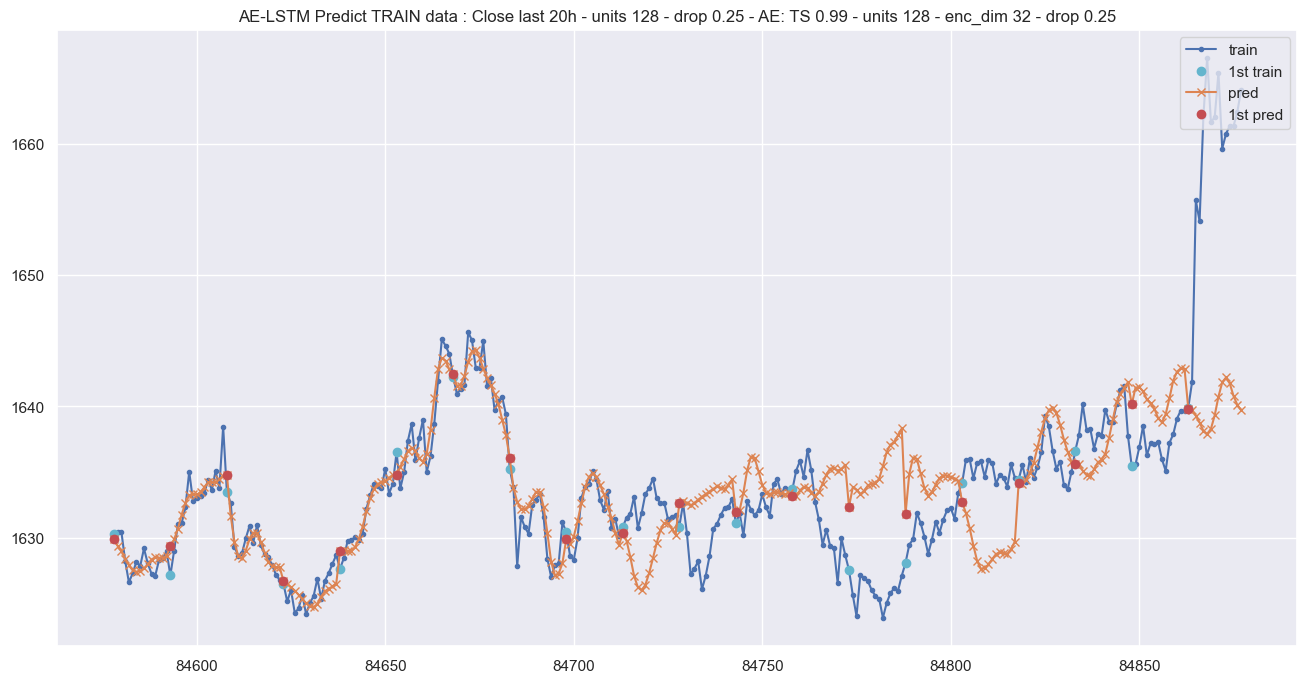

In [160]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TRAIN data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_train_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_train_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_train_raw_1 = y_train_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_train_pred_raw_1 = y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_train_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="train")
plt.plot(x_axis_1[-nb_pred:], y_train_raw_1[-nb_pred:], 'oc', label ='1st train')
plt.plot(x_axis[-nb_points:], y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_train_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TRAIN - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

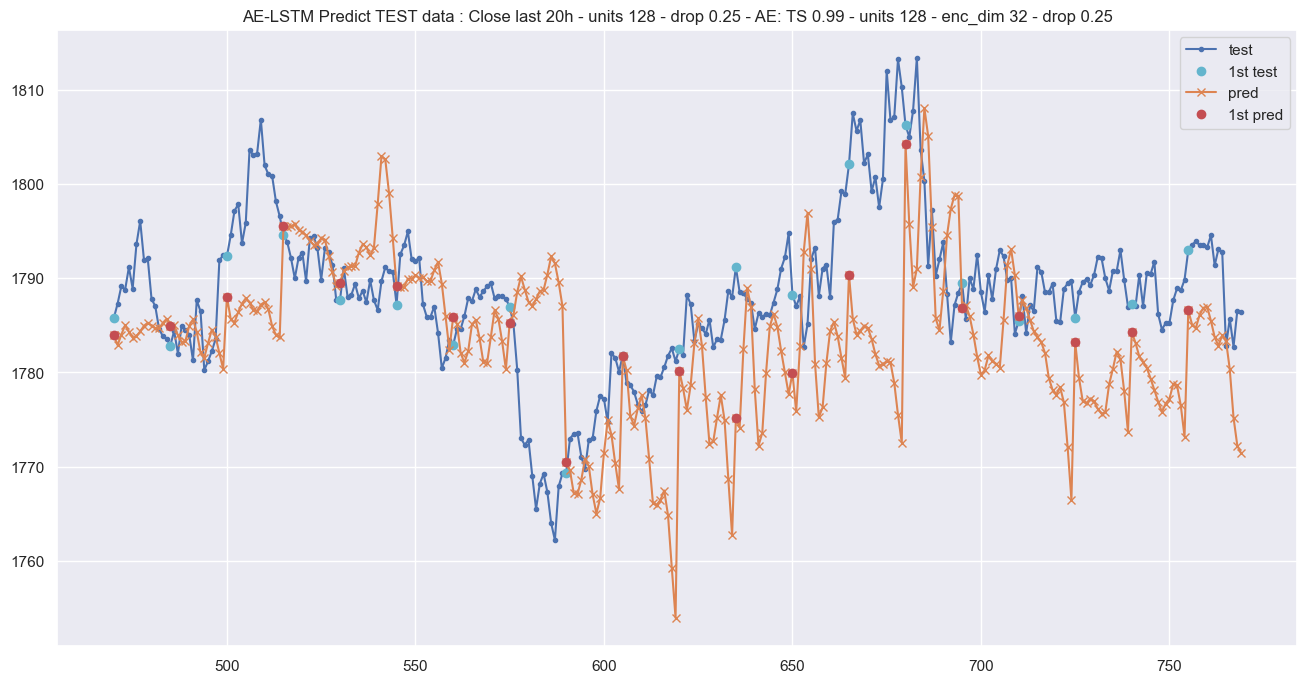

In [161]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TEST data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_test_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_test_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_test_raw_1 = y_test_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_test_pred_raw_1 = y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_test_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="test")
plt.plot(x_axis_1[-nb_pred:], y_test_raw_1[-nb_pred:], 'oc', label ='1st test')
plt.plot(x_axis[-nb_points:], y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_test_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TEST - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

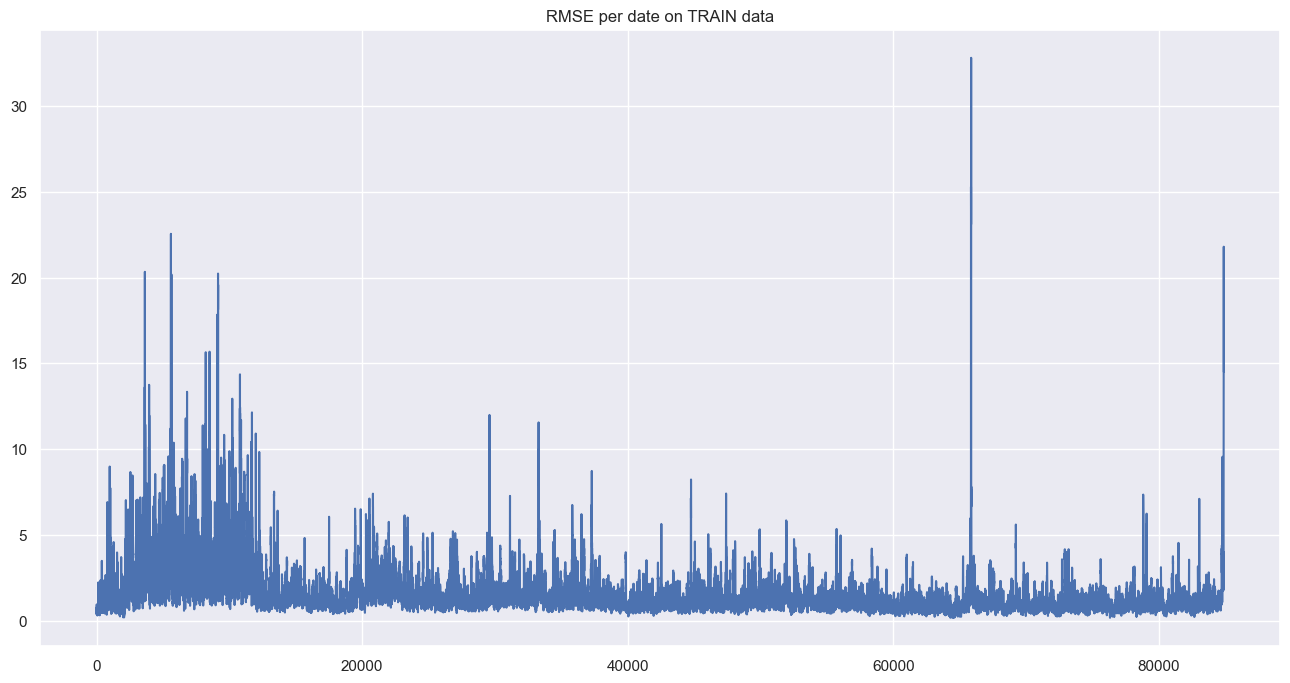

In [162]:
arr_mse_train = np.zeros((y_train_raw.shape[0]))
for i_date in range(y_train_raw.shape[0]):
    arr_mse_train[i_date] = mean_squared_error(
        y_train_raw[i_date], 
        y_train_pred_raw[i_date], 
        squared=False,
    )
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on TRAIN data")
plt.plot(arr_mse_train, label="mse")

Text(0.5, 1.0, 'Distrib. RMSE on TRAIN')

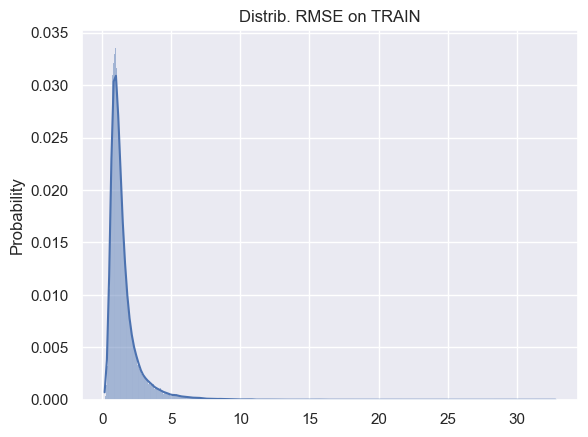

In [163]:
sns.histplot(x=arr_mse_train, stat="probability", kde=True)
fig = plt.gcf()
plt.title("Distrib. RMSE on TRAIN")

Text(0.5, 1.0, 'RMSE on TRAIN: mean= 1.54')

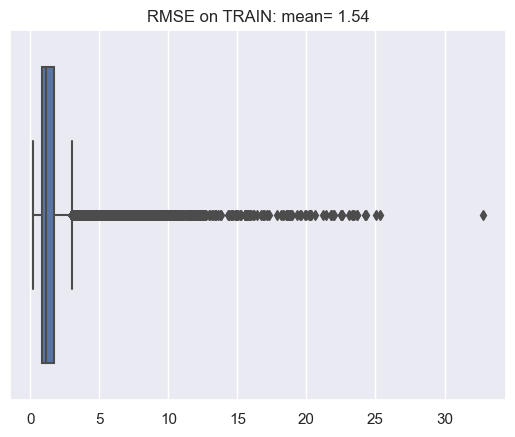

In [164]:

sns.boxplot(x=arr_mse_train)
fig = plt.gcf()
plt.title(f"RMSE on TRAIN: mean= {np.mean(arr_mse_train):.2f}")

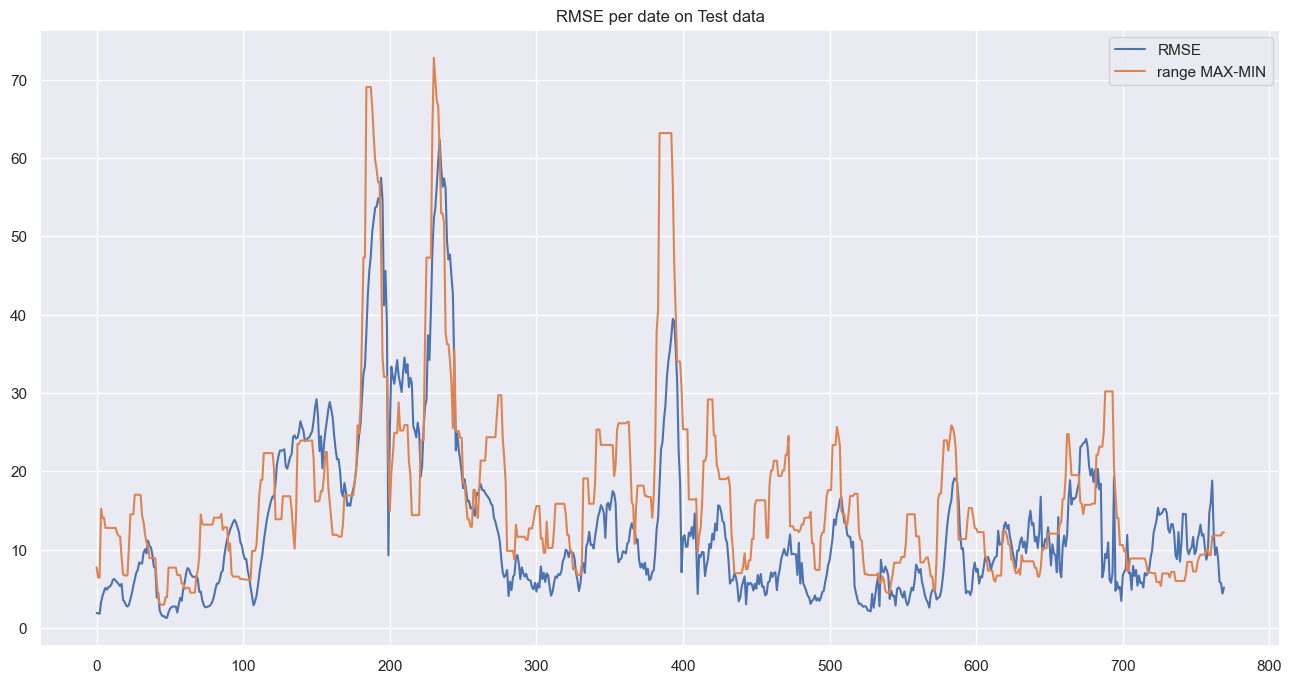

In [165]:
arr_mse = np.zeros((y_test_raw.shape[0]))
arr_range = np.zeros((y_test_raw.shape[0]))
for i_date in range(y_test_raw.shape[0]):
    arr_mse[i_date] = mean_squared_error(
        y_test_raw[i_date], 
        y_test_pred_raw[i_date],
        squared=False,
    )
    arr_range[i_date] = np.max(y_test_raw[i_date]) - np.min(y_test_raw[i_date])
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on Test data")
plt.plot(arr_mse, label="RMSE")
plt.plot(arr_range, label="range MAX-MIN")
plt.legend(loc='upper right')

In [166]:
np.mean(arr_range)

16.89297402597403

<AxesSubplot: ylabel='Probability'>

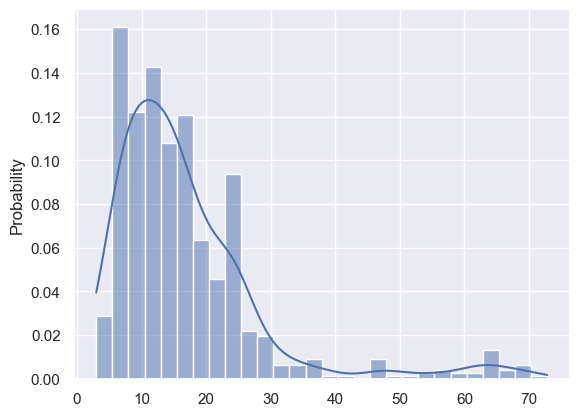

In [167]:
sns.histplot(x=arr_range,  stat="probability", kde=True)

In [168]:
np.mean(3*np.sqrt(np.var(y_test_raw, axis=1)))

14.626384671177268

<AxesSubplot: ylabel='Probability'>

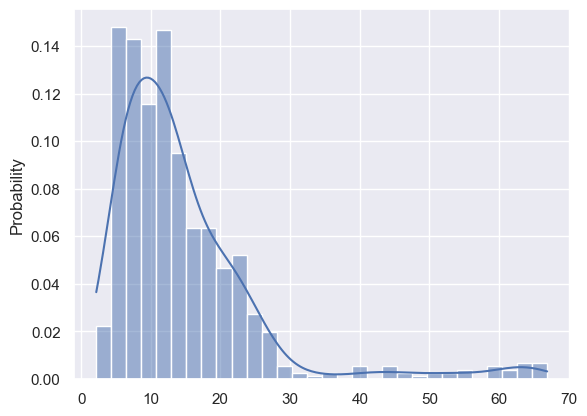

In [169]:
sns.histplot(x=3*np.sqrt(np.var(y_test_raw, axis=1)),  stat="probability", kde=True)

Text(0.5, 1.0, 'probability of RSME on each sequence')

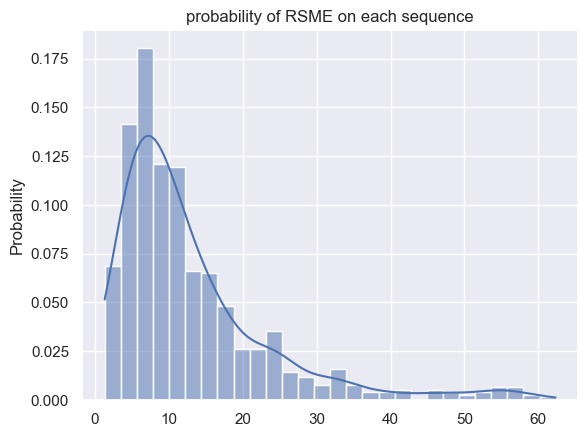

In [170]:
sns.histplot(x=arr_mse,  stat="probability", kde=True)
plt.title("probability of RSME on each sequence")

(0.0, 84.46487012987015)

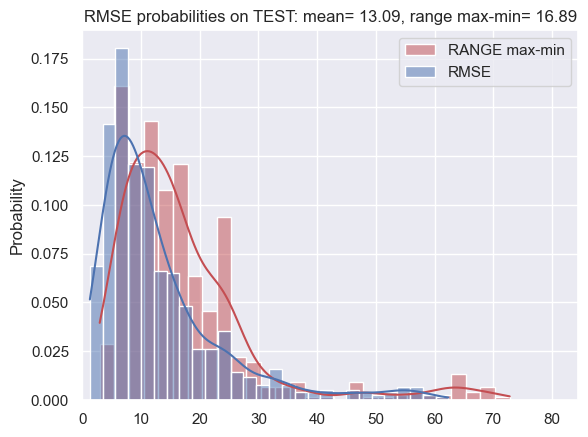

In [171]:
ax = sns.histplot(x=arr_range,  stat="probability", kde=True, label="RANGE max-min", color="r")
sns.histplot(x=arr_mse,  stat="probability", kde=True, label="RMSE", ax=ax)
plt.title(f"RMSE probabilities on TEST: mean= {np.mean(arr_mse):.2f}, range max-min= {np.mean(arr_range):.2f}")
plt.legend(loc='upper right')
ax.set_xlim([0,np.mean(arr_range)*5])

(0.0, 65.43746719779732)

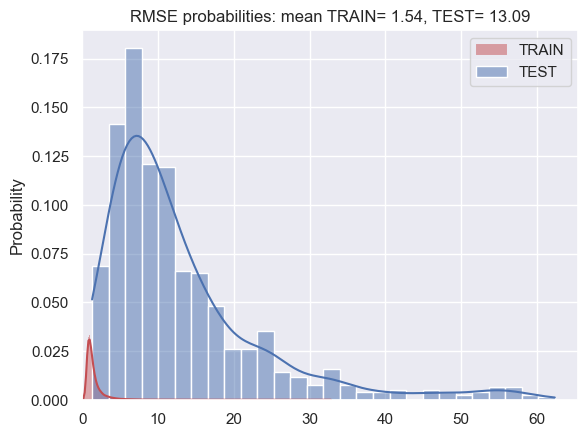

In [172]:
ax = sns.histplot(x=arr_mse_train,  stat="probability", kde=True, label="TRAIN", color="r")
sns.histplot(x=arr_mse,  stat="probability", kde=True, label="TEST", ax=ax)
plt.title(f"RMSE probabilities: mean TRAIN= {np.mean(arr_mse_train):.2f}, TEST= {np.mean(arr_mse):.2f}")
plt.legend(loc='upper right')
ax.set_xlim([0,np.mean(arr_mse)*5])

Text(0.5, 1.0, 'RMSE on TEST: mean= 13.09')

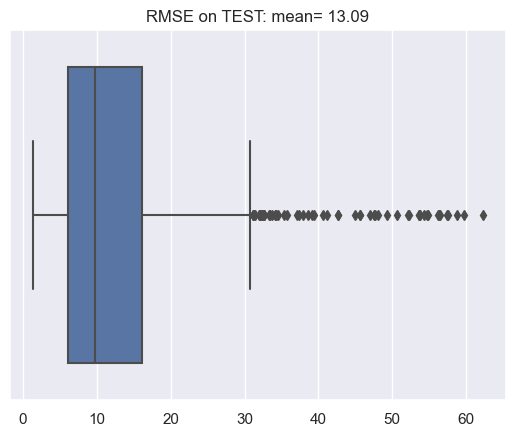

In [173]:
sns.boxplot(x=arr_mse)
fig = plt.gcf()
plt.title(f"RMSE on TEST: mean= {np.mean(arr_mse):.2f}")

In [174]:
print(y_test_raw[-3,:])
print(y_test_pred_raw[-3,:])

[1793.92 1793.52 1793.58 1793.28 1794.57 1791.38 1793.11 1792.78 1782.82
 1785.7  1782.75 1786.55 1786.43 1785.92 1786.76]
[1790.18976756 1788.37719154 1787.23897291 1787.6723662  1787.61004052
 1786.41612434 1784.17806601 1782.03985705 1780.92558516 1782.36837643
 1783.03011902 1783.34014381 1782.12495351 1781.00052564 1780.12839381]


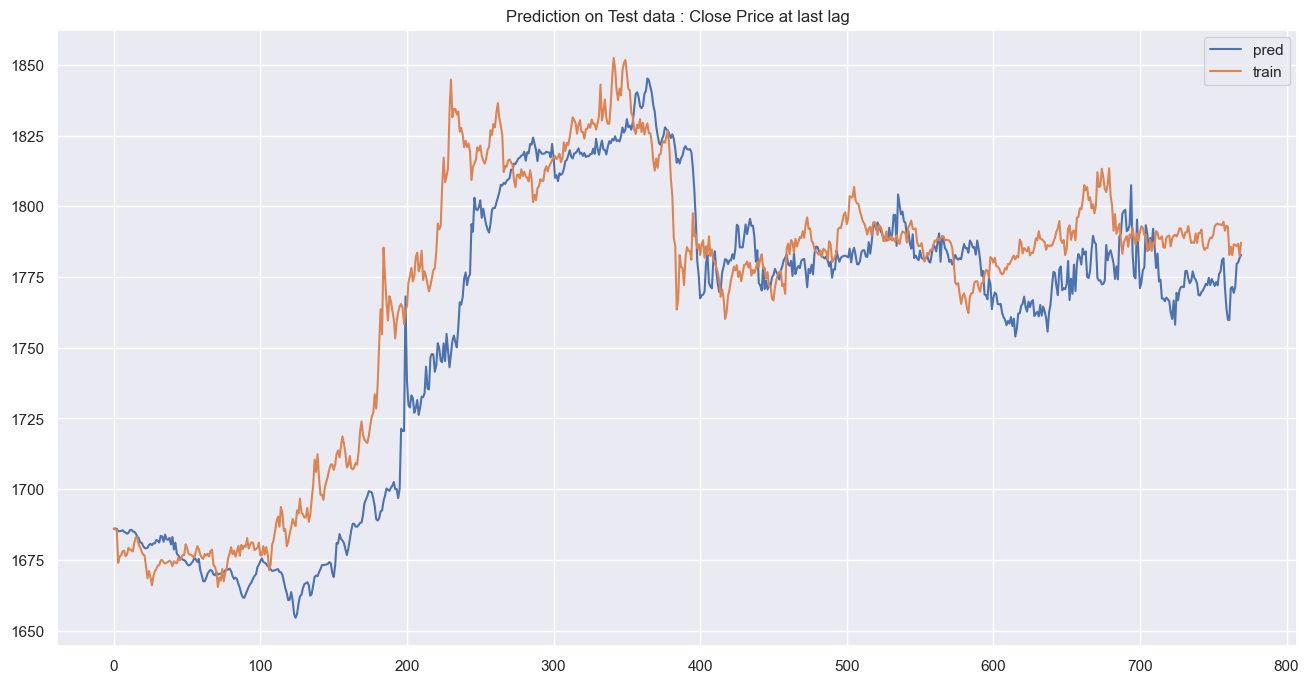

In [175]:
fig = plt.figure(figsize=(16, 8))
plt.title("Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

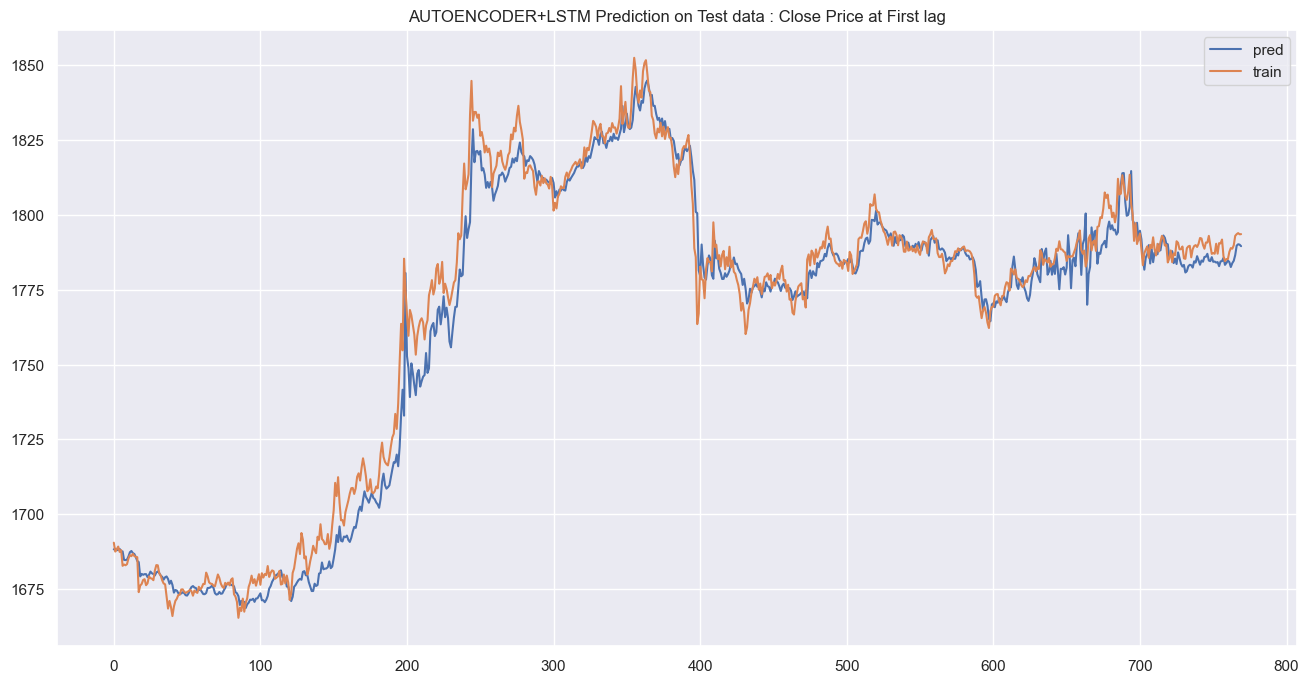

In [176]:
fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at First lag")
plt.plot(y_test_pred_raw[:1000, 0], label="pred")
plt.plot(y_test_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

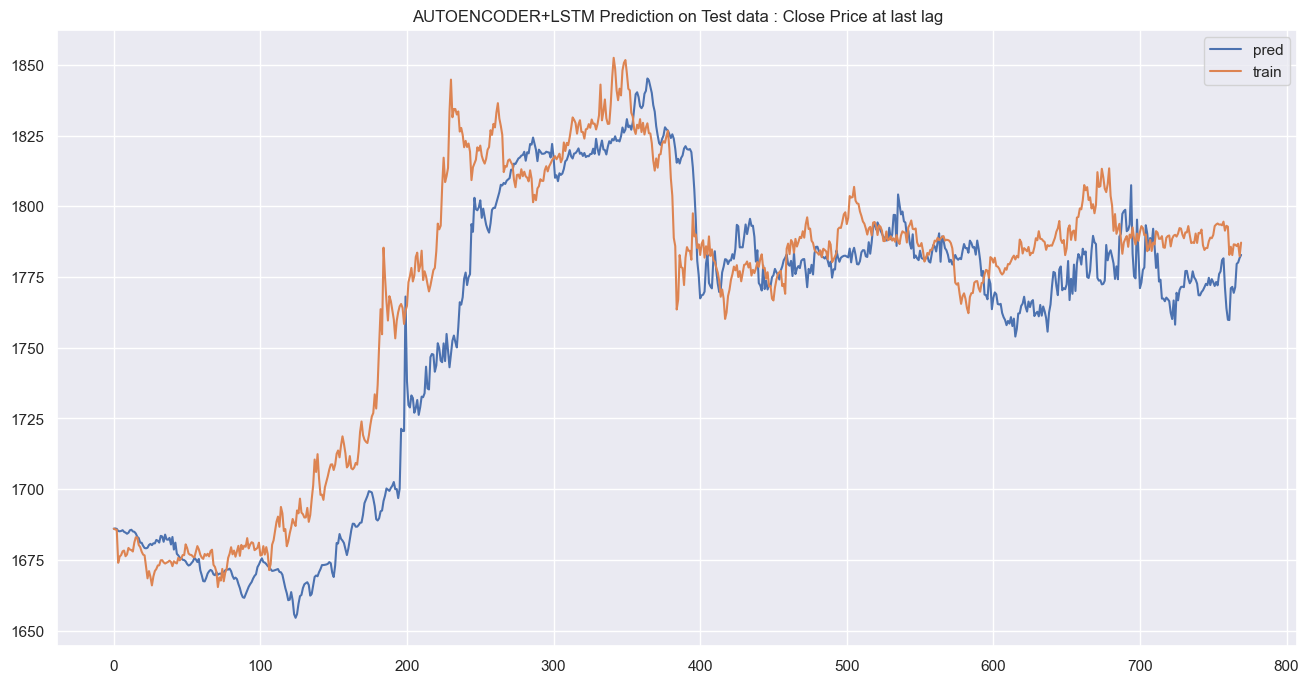

In [177]:

fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

## Compare

## Predict last prediction

In [178]:
X_test_sca.shape

(770, 72, 102)

In [179]:
df_feat["Close_ETH"].iloc[-1]

1784.95

In [180]:
df_feat["Close_ETH"].iloc[-1]

1784.95

In [181]:
len(list_i_enc_select)

32

In [182]:
# reload MDLS
#multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
#encoder_model = tf.keras.models.load_model(path_mdl_encoder)
print("[batch, lags, features]")
X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
X_last = X_last_raw.copy()
#list(np.array(list_col_select)[i_col_price_dep])/ df_feat["Close_ETH"].iloc[-1]
print("X_last[0,:,0]:")
print(X_last[0,:,0])
# Scale by ETH price
X_last[:,:,i_col_price_dep] = X_last[:,:,i_col_price_dep] / df_feat["Close_ETH"].iloc[-1]
assert X_last[0,-1,0] == 1, "Scaling by ETH price is not good!"
print("X_last[0,:,0] after divide by price:")
print(X_last[0,:,0])
print(X_last.shape)
# Standardize
X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
print("X_last_sca[0,:,0]:")
print(X_last_sca[0,:,0])
print(X_last_sca.shape)
# Encode
X_last_encoded = encoder_model.predict(X_last_sca)
print("X_last_encoded[0,:,0]:")
print(X_last_encoded[0,:,0])
print(X_last_encoded.shape)
# Standardize encoded
X_last_encoded_sca = scaler_enc.transform(
    X_last_encoded.reshape(
        -1, 
        X_last_encoded.shape[-1]
    )
).reshape(X_last_encoded.shape)
print("X_last_encoded_sca[0,:,0]:")
print(X_last_encoded_sca[0,:,0])
print(X_last_encoded_sca.shape)
print("X_last_sca[0,0,0:4]:")
print(X_last_sca[0,0,0:4])
print("X_last_encoded_sca[0,0,:]:")
print(X_last_encoded_sca[0,0,:])
# Concatenate (auto selected encoded features)
X_last_ = np.concatenate([
        X_last_sca[:,:,0:4], 
        X_last_encoded_sca[:, :, np.array(list_i_enc_select)]
    ],
    axis=-1,
)
print("X_last_[0,0,:]:")
print(X_last_[0,0,:])
print(X_last_.shape)
# Predict
y_last_pred = multi_step_model.predict(X_last_)
print("y_last_pred (scaled):")
print(y_last_pred)
print(y_last_pred.shape)
# Unscale
#scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.ravel().reshape(-1, 1)).reshape(y_last_pred.shape)
print("y_last_pred_unscaled:")
print(y_last_pred_unscaled)
print(y_last_pred_unscaled.shape)
# Multiply by price
y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
print("y_last_pred_raw:")
print(y_last_pred_raw)
print(y_last_pred_raw.shape)
nb_last_hour = 12
list_pred = list(y_last_pred_raw.squeeze()[-nb_last_hour:])
print("list_pred:")
print(list_pred)
print(len(list_pred))


[batch, lags, features]
X_last[0,:,0]:
[1787.77 1790.95 1792.99 1792.34 1789.77 1790.   1784.11 1785.44 1788.12
 1784.2  1787.13 1786.53 1791.2  1790.69 1788.51 1788.53 1789.44 1785.48
 1785.32 1788.86 1789.48 1789.68 1785.83 1788.55 1789.6  1789.91 1789.29
 1790.36 1792.29 1792.11 1789.99 1788.7  1790.79 1790.74 1793.   1789.81
 1786.99 1787.24 1787.01 1790.36 1787.05 1790.58 1790.45 1791.77 1786.21
 1784.56 1785.25 1785.25 1787.65 1788.92 1788.71 1789.84 1793.   1793.57
 1793.92 1793.52 1793.58 1793.28 1794.57 1791.38 1793.11 1792.78 1782.82
 1785.7  1782.75 1786.55 1786.43 1785.92 1786.76 1782.37 1787.15 1784.95]
X_last[0,:,0] after divide by price:
[1.00157988 1.00336144 1.00450433 1.00414017 1.00270036 1.00282921
 0.9995294  1.00027452 1.00177596 0.99957982 1.00122132 1.00088518
 1.0035015  1.00321578 1.00199445 1.00200566 1.00251548 1.00029693
 1.00020729 1.00219054 1.00253789 1.00264993 1.00049301 1.00201686
 1.00260511 1.00277879 1.00243144 1.0030309  1.00411216 1.00401132
 1.0

In [183]:
X_last_encoded_sca.shape

(1, 72, 32)

In [184]:
list_i_enc_select

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31]

In [185]:
X_last_encoded_sca[:,:, np.array(list_i_enc_select)].shape

(1, 72, 32)

In [186]:
X_last_sca[:,:,0:4].shape

(1, 72, 4)

In [187]:
X_train_.shape

(84878, 72, 36)

In [188]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
85817  1698276300000   1786.43   1787.61  1785.59    1785.92    412.2097   
85818  1698276600000   1785.93   1787.83  1785.92    1786.76    806.0853   
85819  1698276900000   1786.76   1787.02  1781.50    1782.37    522.3319   
85820  1698277200000   1782.38   1787.38  1782.37    1787.15    530.5340   
85821  1698277500000   1787.16   1787.30  1784.94    1784.95    392.4814   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1725.587791       1725.167882   
1      2023-01-01 00:05:00       1725.587791       1725.167882   
2      2023-01-01 00:10:00       1725.587791       1725.167882   
3      2023-01-01 00:15:00       1725.587791       1725.167882   
4      2023-01-01 00:20:00       1725.587791       1725.167882   
...                    ...               ...               ...   
85817  2023-10-25 23:25:00       1789.052500       1786.520000   
85818  2023-10-25 23:30:00       1789.052500       1788.065000   
85819  2023-10-25 23:35:00       1789.052500       1788.065000   
85820  2023-10-25 23:40:00       1789.000000       1788.065000   
85821  2023-10-25 23:45:00       1787.527500       1787.875000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0             1194.71  ...         0.0            0.0           0.0   
1             1194.71  ...         0.0            0.0           0.0   
2             1194.71  ...         0.0            0.0           0.0   
3             1194.71  ...         0.0            0.0           0.0   
4             1194.71  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
85817         1786.23  ...         NaN            NaN           NaN   
85818         1786.23  ...         NaN            NaN           NaN   
85819         1786.23  ...         NaN            NaN           NaN   
85820         1786.23  ...         NaN            NaN           NaN   
85821         1786.23  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
85817               NaN         0.0               NaN         0.0      0.0   
85818               NaN         0.0               NaN         0.0      0.0   
85819               NaN         0.0               NaN         0.0      0.0   
85820               NaN         0.0               NaN         0.0      0.0   
85821               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
85817                  NaN  False  
85818                  NaN  False  
85819                  NaN  False  
85820                  NaN  False  
85821                  NaN  False  

[85822 rows x 136 columns]

In [189]:
mode_lstm_simple = False
if mode_lstm_simple:
    # TODO : finish pred
    X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
    # divided price
    X_last = X_last_raw / df_feat["Close_ETH"].iloc[-1]
    # scaler
    X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
    y_last_pred = multi_step_model_1.predict(X_last_sca)
    y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.reshape(-1,y_last_pred.shape[-1])).reshape(y_last_pred.shape)
    y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
    print(y_last_pred_raw)
    nb_last_pred = 12
    list_pred = list(y_last_pred_raw.squeeze()[-nb_last_pred:])
    print(list_pred)

In [190]:
y_last_pred_unscaled

array([[0.99713296, 0.9950994 , 0.99431866, 0.9953383 , 0.9965585 ,
        0.9967955 , 0.9956025 , 0.99397516, 0.99294764, 0.9937162 ,
        0.9944831 , 0.9954838 , 0.9954428 , 0.99493295, 0.9940787 ]],
      dtype=float32)

In [191]:
df_feat["Close_ETH"].iloc[-1]

1784.95

In [192]:
y_last_pred_raw

array([[1779.8324, 1776.2026, 1774.8091, 1776.629 , 1778.807 , 1779.23  ,
        1777.1006, 1774.1959, 1772.3618, 1773.7336, 1775.1025, 1776.8888,
        1776.8156, 1775.9055, 1774.3807]], dtype=float32)

In [193]:
y_last_pred_raw.shape

(1, 15)

## Save last prediction

In [194]:
list_pred

[1776.629,
 1778.807,
 1779.23,
 1777.1006,
 1774.1959,
 1772.3618,
 1773.7336,
 1775.1025,
 1776.8888,
 1776.8156,
 1775.9055,
 1774.3807]

In [195]:
save_list(list_pred, path_save_pred_vals)

In [196]:
list_pred_reload = load_list(path_save_pred_vals)
from numpy.testing import assert_almost_equal
assert_almost_equal(list_pred_reload,list_pred, decimal=3)
#"Reload prediction list not good!"

In [198]:
list_pred_reload

[1776.629,
 1778.807,
 1779.23,
 1777.1006,
 1774.1959,
 1772.3618,
 1773.7336,
 1775.1025,
 1776.8888,
 1776.8156,
 1775.9055,
 1774.3807]